# Предсказание коэффициента восстановления золота из золотосодержащей руды

## Описание проекта

**Постановка задачи:**
Необходимо подготовить прототип модели машинного обучения для компании, котора разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Тип задачи:**
Обучение с учителем, модели регрессии (LR, DTR, RFR).

**Описание этапов обработки руды:**
1. **Флотация:** Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. **Очистка:** Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Эффективность обогащения рассчитывается по формуле:**
$Recovery = (C * (F - T)) / (F * (C - T)) * 100\% $
* `C` — доля золота в концентрате после флотации/очистки;
* `F` — доля золота в сырье/концентрате до флотации/очистки;
* `T` — доля золота в отвальных хвостах после флотации/очистки.
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества:**
<br> $sMAPE = \frac {1}{N} * \sum_{i=1}^{N} \frac {|y_i-\hat y_i|}{(|y_i| + |\hat y_i|) / 2} * 100\% $ 

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата `rougher.output.recovery`;
* эффективность обогащения финального концентрата `final.output.recovery`.

**Итоговая метрика складывается из двух величин:**
<br> $Итоговоеs \  MAPE = 25\% * sMAPE(rougher) + 75\% * sMAPE(final)$


## Описание данных

**Технологический процесс:**
* `Rougher feed` — исходное сырье
* `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * `Xanthate` — ксантогенат (промотер, или активатор флотации);
    * `Sulphate` — сульфат (на данном производстве сульфид натрия);
    * `Depressant` — депрессант (силикат натрия).
* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

**Параметры этапов:**
* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

**Наименование признаков:**
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**
`rougher` — флотация
`primary_cleaner` — первичная очистка
`secondary_cleaner` — вторичная очистка
`final` — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики

## Импорты и настройки

In [1]:
# Импорты
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Настройки
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Зафиксируем random state для всего проекта
np.random.seed(777)

## План работы

* Подготовка данных;
* Исследовательский анализ данных;
* Создание и обучение модели;
* Общие выводы по проекту.

## Подготовка данных

### Загрузка данных

In [4]:
# Загрузка данных
try:
    df_train = pd.read_csv('/datasets/gold_industry_train.csv', index_col='date')
    df_test = pd.read_csv('/datasets/gold_industry_test.csv', index_col='date')
    df_full = pd.read_csv('/datasets/gold_industry_full.csv', index_col='date')
    display('Данные из практикума загружены.')
except:
    df_train = pd.read_csv('datasets/gold_industry_train.csv', index_col='date')
    df_test = pd.read_csv('datasets/gold_industry_test.csv', index_col='date')
    df_full = pd.read_csv('datasets/gold_industry_full.csv', index_col='date')
    display('Локальные данные загружены.')

df_train.name='df_train'
df_test.name='df_test'
df_full.name='df_full'

'Локальные данные загружены.'

### Первоначальный осмотр данных

In [5]:
def first_meet(df):
    display(f'============================= Датафрейм: {df.name} =============================')
    display(f'Размеры: {df.shape}')
    display('Типы:', df_train.dtypes.value_counts())
    display('Голова:', df.head())
    display('Хвост:', df.tail())
    display('Инфо:')
    display(df.info());

# Первоначальный осмотр данных
for df in [df_train, df_test, df_full]:
    first_meet(df);

'============================= Датафрейм: df_train ============================='

'Размеры: (14579, 86)'

'Типы:'

float64    86
dtype: int64

'Голова:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2016-01-15 00:00:00                   6.49                   6.10   
2016-01-15 01:00:00                   6.48                   6.16   
2016-01-15 02:00:00                   6.36                   6.12   
2016-01-15 03:00:00                   6.12                   6.04   
2016-01-15 04:00:00                   5.66                   6.06   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2016-01-15 00:00:00                   2.28                   36.81   
2016-01-15 01:00:00                   2.27                   35.75   
2016-01-15 02:00:00                   2.16                   35.97   
2016-01-15 03:00:00                   2.04                   36.86   
2016-01-15 04:00:00                   1.79                   34.35   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2016-01-15 00:00:00                   523.55                    55.49   
2016-01-15 01:00:00                   525.29                    57.28   
2016-01-15 02:00:00                   530.03                    57.51   
2016-01-15 03:00:00                   542.59                    57.79   
2016-01-15 04:00:00                   540.53                    56.05   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2016-01-15 00:00:00                              11.99   
2016-01-15 01:00:00                              11.97   
2016-01-15 02:00:00                              11.92   
2016-01-15 03:00:00                              11.63   
2016-01-15 04:00:00                              10.96   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2016-01-15 00:00:00                                6.01   
2016-01-15 01:00:00                                6.01   
2016-01-15 02:00:00                                6.20   
2016-01-15 03:00:00                                6.20   
2016-01-15 04:00:00                                6.20   

                     rougher.state.floatbank10_a_air  \
date                                                   
2016-01-15 00:00:00                           999.71   
2016-01-15 01:00:00                          1000.29   
2016-01-15 02:00:00                           999.72   
2016-01-15 03:00:00                           999.81   
2016-01-15 04:00:00                           999.68   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2016-01-15 00:00:00                            -404.07  ...   
2016-01-15 01:00:00                            -400.07  ...   
2016-01-15 02:00:00                            -400.07  ...   
2016-01-15 03:00:00                            -400.20  ...   
2016-01-15 04:00:00                            -399.75  ...   

                     secondary_cleaner.output.tail_sol  \
date                                                     
2016-01-15 00:00:00                               8.76   
2016-01-15 01:00:00                               9.00   
2016-01-15 02:00:00                               8.84   
2016-01-15 03:00:00                               9.12   
2016-01-15 04:00:00                               8.87   

                     final.output.concentrate_au  final.output.concentrate_ag  \
date                                                                            
2016-01-15 00:00:00                        42.19                         6.06   
2016-01-15 01:00:00                        42.70                         6.03   
2016-01-15 02:00:00                        42.66                         6.06   
2016-01-15 03:00:00                        42.69                  

'Хвост:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2017-12-09 09:59:59                   4.60                   5.82   
2017-12-09 10:59:59                   4.66                   5.84   
2017-12-09 11:59:59                   5.34                   6.09   
2017-12-09 12:59:59                   4.84                   6.12   
2017-12-09 13:59:59                   4.53                   5.97   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2017-12-09 09:59:59                   4.26                   37.48   
2017-12-09 10:59:59                   4.24                   37.40   
2017-12-09 11:59:59                   4.62                   37.37   
2017-12-09 12:59:59                   4.14                   38.59   
2017-12-09 13:59:59                   4.02                   40.07   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2017-12-09 09:59:59                   559.90                    85.25   
2017-12-09 10:59:59                   561.46                    83.86   
2017-12-09 11:59:59                   560.89                    85.72   
2017-12-09 12:59:59                   559.03                   119.50   
2017-12-09 13:59:59                   555.68                   122.26   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2017-12-09 09:59:59                               6.78   
2017-12-09 10:59:59                               6.77   
2017-12-09 11:59:59                               7.76   
2017-12-09 12:59:59                               7.36   
2017-12-09 13:59:59                               6.59   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2017-12-09 09:59:59                                9.01   
2017-12-09 10:59:59                                9.00   
2017-12-09 11:59:59                                9.16   
2017-12-09 12:59:59                                9.30   
2017-12-09 13:59:59                                9.30   

                     rougher.state.floatbank10_a_air  \
date                                                   
2017-12-09 09:59:59                          1200.45   
2017-12-09 10:59:59                          1200.96   
2017-12-09 11:59:59                          1199.25   
2017-12-09 12:59:59                          1196.57   
2017-12-09 13:59:59                          1204.87   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2017-12-09 09:59:59                            -300.01  ...   
2017-12-09 10:59:59                            -300.01  ...   
2017-12-09 11:59:59                            -300.85  ...   
2017-12-09 12:59:59                            -299.51  ...   
2017-12-09 13:59:59                            -299.24  ...   

                     secondary_cleaner.output.tail_sol  \
date                                                     
2017-12-09 09:59:59                               0.00   
2017-12-09 10:59:59                               0.00   
2017-12-09 11:59:59                               0.00   
2017-12-09 12:59:59                               0.00   
2017-12-09 13:59:59                               0.00   

                     final.output.concentrate_au  final.output.concentrate_ag  \
date                                                                            
2017-12-09 09:59:59                        47.77                         2.93   
2017-12-09 10:59:59                        46.96                         3.08   
2017-12-09 11:59:59                        46.71                         3.22   
2017-12-09 12:59:59                        46.87                  

'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air                  

None

'============================= Датафрейм: df_test ============================='

'Размеры: (4860, 52)'

'Типы:'

float64    86
dtype: int64

'Голова:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2017-12-09 14:59:59                   4.37                   6.16   
2017-12-09 15:59:59                   4.36                   6.05   
2017-12-09 16:59:59                   5.08                   6.08   
2017-12-09 17:59:59                   5.15                   6.08   
2017-12-09 18:59:59                   5.74                   6.17   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2017-12-09 14:59:59                   3.88                   39.14   
2017-12-09 15:59:59                   3.90                   39.71   
2017-12-09 16:59:59                   4.56                   37.21   
2017-12-09 17:59:59                   4.77                   36.81   
2017-12-09 18:59:59                   4.51                   37.81   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2017-12-09 14:59:59                   555.82                    94.54   
2017-12-09 15:59:59                   544.73                   123.74   
2017-12-09 16:59:59                   558.16                    82.61   
2017-12-09 17:59:59                   539.71                    77.98   
2017-12-09 18:59:59                   558.71                    86.43   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2017-12-09 14:59:59                               6.15   
2017-12-09 15:59:59                               6.21   
2017-12-09 16:59:59                               7.36   
2017-12-09 17:59:59                               6.93   
2017-12-09 18:59:59                               7.82   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2017-12-09 14:59:59                                9.31   
2017-12-09 15:59:59                                9.30   
2017-12-09 16:59:59                                9.00   
2017-12-09 17:59:59                                8.96   
2017-12-09 18:59:59                                7.49   

                     rougher.state.floatbank10_a_air  \
date                                                   
2017-12-09 14:59:59                          1196.24   
2017-12-09 15:59:59                          1201.90   
2017-12-09 16:59:59                          1200.83   
2017-12-09 17:59:59                          1199.29   
2017-12-09 18:59:59                          1198.01   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2017-12-09 14:59:59                            -299.86  ...   
2017-12-09 15:59:59                            -299.91  ...   
2017-12-09 16:59:59                            -300.12  ...   
2017-12-09 17:59:59                            -299.78  ...   
2017-12-09 18:59:59                            -300.28  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2017-12-09 14:59:59                                     23.02   
2017-12-09 15:59:59                                     23.02   
2017-12-09 16:59:59                                     22.99   
2017-12-09 17:59:59                                     23.03   
2017-12-09 18:59:59                                     23.00   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2017-12-09 14:59:59                                     -500.49   
2017-12-09 15:59:59                                     -501.15   
2017-12-09 16:59:59                                     -501.56   
2017-12-09 17:59:59                                     -501.29   
2017-12-09 18:59:59 

'Хвост:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2018-08-18 06:59:59                   6.62                   5.99   
2018-08-18 07:59:59                   6.74                   6.16   
2018-08-18 08:59:59                   6.63                   6.02   
2018-08-18 09:59:59                   6.70                   6.10   
2018-08-18 10:59:59                   6.63                   5.91   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2018-08-18 06:59:59                   2.59                   39.93   
2018-08-18 07:59:59                   2.65                   40.18   
2018-08-18 08:59:59                   2.47                   39.84   
2018-08-18 09:59:59                   2.28                   37.73   
2018-08-18 10:59:59                   2.44                   36.96   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2018-08-18 06:59:59                   578.65                    63.47   
2018-08-18 07:59:59                   571.62                    62.82   
2018-08-18 08:59:59                   563.73                    61.29   
2018-08-18 09:59:59                   549.81                    59.64   
2018-08-18 10:59:59                   573.08                    58.51   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2018-08-18 06:59:59                              14.69   
2018-08-18 07:59:59                              14.89   
2018-08-18 08:59:59                              13.72   
2018-08-18 09:59:59                              13.75   
2018-08-18 10:59:59                              13.71   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2018-08-18 06:59:59                                6.90   
2018-08-18 07:59:59                                6.90   
2018-08-18 08:59:59                                6.70   
2018-08-18 09:59:59                                6.71   
2018-08-18 10:59:59                                6.82   

                     rougher.state.floatbank10_a_air  \
date                                                   
2018-08-18 06:59:59                           999.69   
2018-08-18 07:59:59                          1000.48   
2018-08-18 08:59:59                          1000.01   
2018-08-18 09:59:59                           999.64   
2018-08-18 10:59:59                          1000.59   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2018-08-18 06:59:59                            -399.22  ...   
2018-08-18 07:59:59                            -399.57  ...   
2018-08-18 08:59:59                            -400.32  ...   
2018-08-18 09:59:59                            -399.48  ...   
2018-08-18 10:59:59                            -398.88  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2018-08-18 06:59:59                                     14.00   
2018-08-18 07:59:59                                     14.03   
2018-08-18 08:59:59                                     14.00   
2018-08-18 09:59:59                                     13.98   
2018-08-18 10:59:59                                     13.99   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2018-08-18 06:59:59                                     -503.15   
2018-08-18 07:59:59                                     -503.47   
2018-08-18 08:59:59                                     -503.00   
2018-08-18 09:59:59                                     -503.68   
2018-08-18 10:59:59 

'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

None

'============================= Датафрейм: df_full ============================='

'Размеры: (19439, 86)'

'Типы:'

float64    86
dtype: int64

'Голова:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2016-01-15 00:00:00                   6.49                   6.10   
2016-01-15 01:00:00                   6.48                   6.16   
2016-01-15 02:00:00                   6.36                   6.12   
2016-01-15 03:00:00                   6.12                   6.04   
2016-01-15 04:00:00                   5.66                   6.06   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2016-01-15 00:00:00                   2.28                   36.81   
2016-01-15 01:00:00                   2.27                   35.75   
2016-01-15 02:00:00                   2.16                   35.97   
2016-01-15 03:00:00                   2.04                   36.86   
2016-01-15 04:00:00                   1.79                   34.35   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2016-01-15 00:00:00                   523.55                    55.49   
2016-01-15 01:00:00                   525.29                    57.28   
2016-01-15 02:00:00                   530.03                    57.51   
2016-01-15 03:00:00                   542.59                    57.79   
2016-01-15 04:00:00                   540.53                    56.05   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2016-01-15 00:00:00                              11.99   
2016-01-15 01:00:00                              11.97   
2016-01-15 02:00:00                              11.92   
2016-01-15 03:00:00                              11.63   
2016-01-15 04:00:00                              10.96   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2016-01-15 00:00:00                                6.01   
2016-01-15 01:00:00                                6.01   
2016-01-15 02:00:00                                6.20   
2016-01-15 03:00:00                                6.20   
2016-01-15 04:00:00                                6.20   

                     rougher.state.floatbank10_a_air  \
date                                                   
2016-01-15 00:00:00                           999.71   
2016-01-15 01:00:00                          1000.29   
2016-01-15 02:00:00                           999.72   
2016-01-15 03:00:00                           999.81   
2016-01-15 04:00:00                           999.68   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2016-01-15 00:00:00                            -404.07  ...   
2016-01-15 01:00:00                            -400.07  ...   
2016-01-15 02:00:00                            -400.07  ...   
2016-01-15 03:00:00                            -400.20  ...   
2016-01-15 04:00:00                            -399.75  ...   

                     secondary_cleaner.output.tail_sol  \
date                                                     
2016-01-15 00:00:00                               8.76   
2016-01-15 01:00:00                               9.00   
2016-01-15 02:00:00                               8.84   
2016-01-15 03:00:00                               9.12   
2016-01-15 04:00:00                               8.87   

                     final.output.concentrate_au  final.output.concentrate_ag  \
date                                                                            
2016-01-15 00:00:00                        42.19                         6.06   
2016-01-15 01:00:00                        42.70                         6.03   
2016-01-15 02:00:00                        42.66                         6.06   
2016-01-15 03:00:00                        42.69                  

'Хвост:'

rougher.input.feed_au  rougher.input.feed_ag  \
date                                                                
2018-08-18 06:59:59                   6.62                   5.99   
2018-08-18 07:59:59                   6.74                   6.16   
2018-08-18 08:59:59                   6.63                   6.02   
2018-08-18 09:59:59                   6.70                   6.10   
2018-08-18 10:59:59                   6.63                   5.91   

                     rougher.input.feed_pb  rougher.input.feed_sol  \
date                                                                 
2018-08-18 06:59:59                   2.59                   39.93   
2018-08-18 07:59:59                   2.65                   40.18   
2018-08-18 08:59:59                   2.47                   39.84   
2018-08-18 09:59:59                   2.28                   37.73   
2018-08-18 10:59:59                   2.44                   36.96   

                     rougher.input.feed_rate  rougher.input.feed_size  \
date                                                                    
2018-08-18 06:59:59                   578.65                    63.47   
2018-08-18 07:59:59                   571.62                    62.82   
2018-08-18 08:59:59                   563.73                    61.29   
2018-08-18 09:59:59                   549.81                    59.64   
2018-08-18 10:59:59                   573.08                    58.51   

                     rougher.input.floatbank10_sulfate  \
date                                                     
2018-08-18 06:59:59                              14.69   
2018-08-18 07:59:59                              14.89   
2018-08-18 08:59:59                              13.72   
2018-08-18 09:59:59                              13.75   
2018-08-18 10:59:59                              13.71   

                     rougher.input.floatbank10_xanthate  \
date                                                      
2018-08-18 06:59:59                                6.90   
2018-08-18 07:59:59                                6.90   
2018-08-18 08:59:59                                6.70   
2018-08-18 09:59:59                                6.71   
2018-08-18 10:59:59                                6.82   

                     rougher.state.floatbank10_a_air  \
date                                                   
2018-08-18 06:59:59                           999.69   
2018-08-18 07:59:59                          1000.48   
2018-08-18 08:59:59                          1000.01   
2018-08-18 09:59:59                           999.64   
2018-08-18 10:59:59                          1000.59   

                     rougher.state.floatbank10_a_level  ...  \
date                                                    ...   
2018-08-18 06:59:59                            -399.22  ...   
2018-08-18 07:59:59                            -399.57  ...   
2018-08-18 08:59:59                            -400.32  ...   
2018-08-18 09:59:59                            -399.48  ...   
2018-08-18 10:59:59                            -398.88  ...   

                     secondary_cleaner.output.tail_sol  \
date                                                     
2018-08-18 06:59:59                              10.01   
2018-08-18 07:59:59                               9.84   
2018-08-18 08:59:59                              10.12   
2018-08-18 09:59:59                               9.88   
2018-08-18 10:59:59                               9.81   

                     final.output.concentrate_au  final.output.concentrate_ag  \
date                                                                            
2018-08-18 06:59:59                        42.44                         5.72   
2018-08-18 07:59:59                        43.44                         5.41   
2018-08-18 08:59:59                        44.28                         5.44   
2018-08-18 09:59:59                        43.34                  

'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air                  

None

In [6]:
# Преобразуем названия столбцов, они излишне длинные
raname_dict = {'rougher.': 'r_',
               'primary_cleaner.': 'pc_',
               'secondary_cleaner.': 'sc_',
               'final.': 'f_',
               'input.': 'i_',
               'state.': 's_',
               'calculation.': 'c_',
               'output.': 'o_'}

for df in [df_train, df_test, df_full]:
    col_names = df.columns
    for key in raname_dict:
        col_names = [name.replace(key, raname_dict[key]) for name in col_names]
    df.columns = col_names

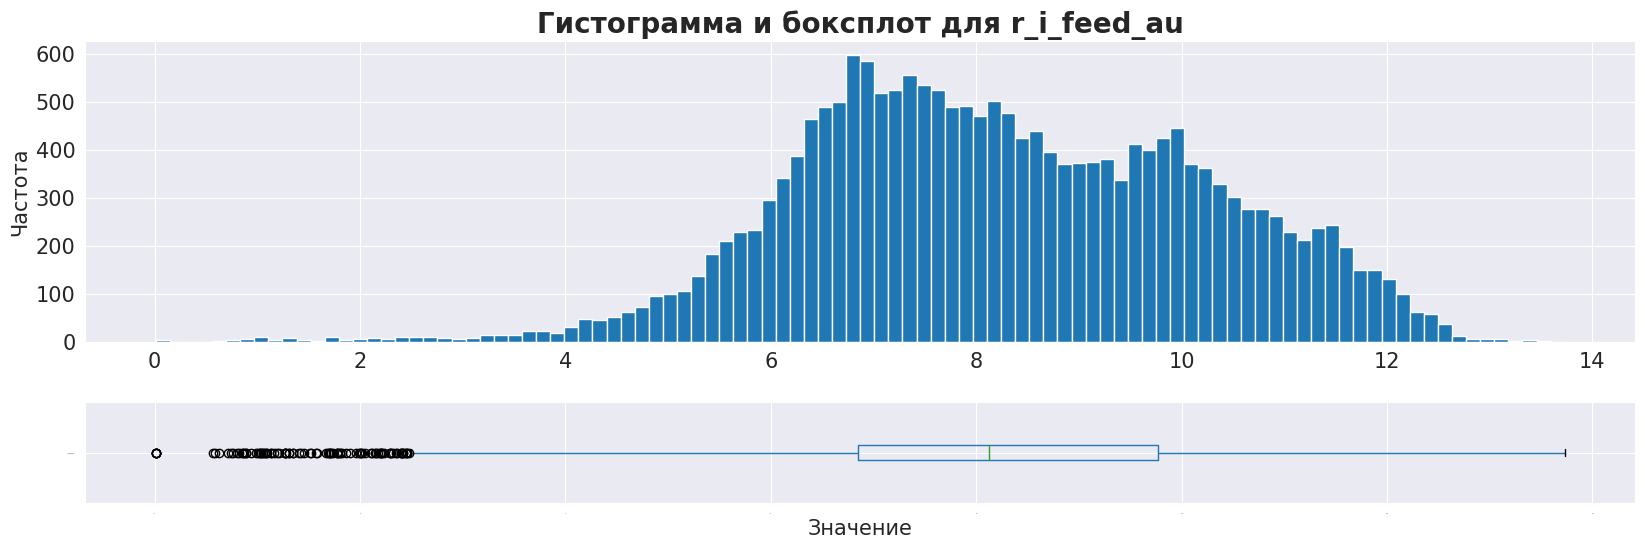

'Количество уникальных значений в столбце r_i_feed_au: 19409'

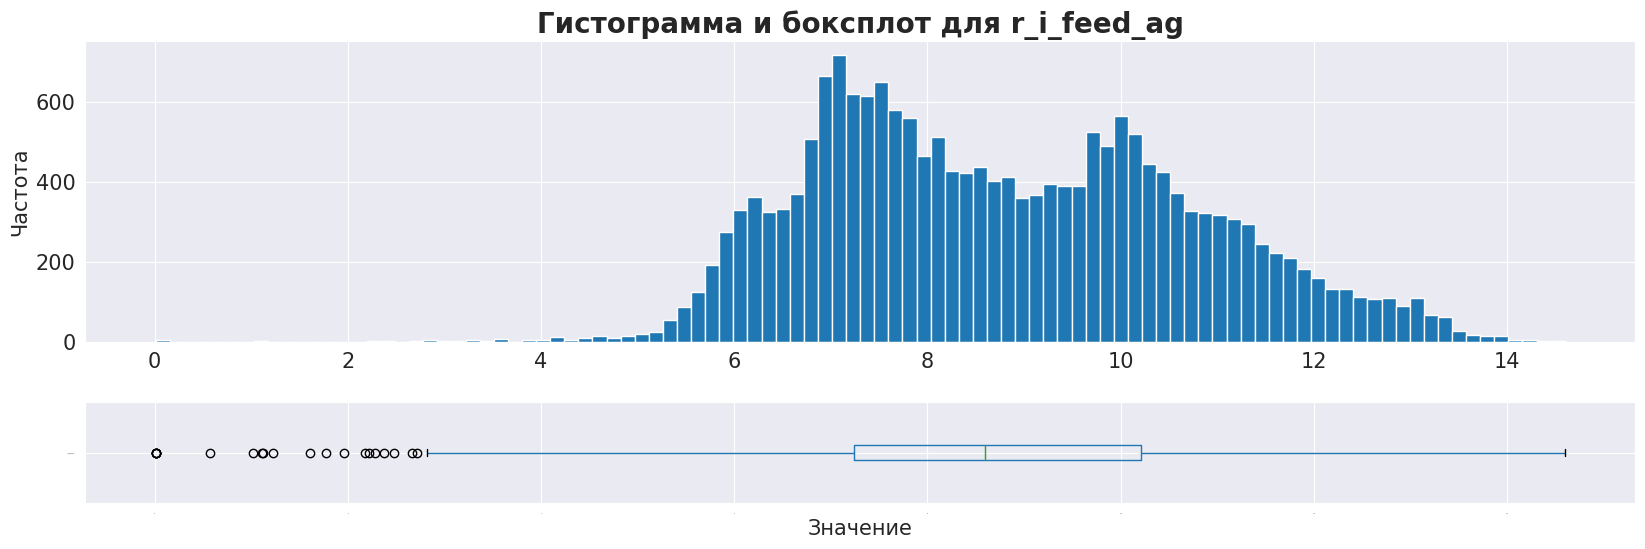

'Количество уникальных значений в столбце r_i_feed_ag: 19409'

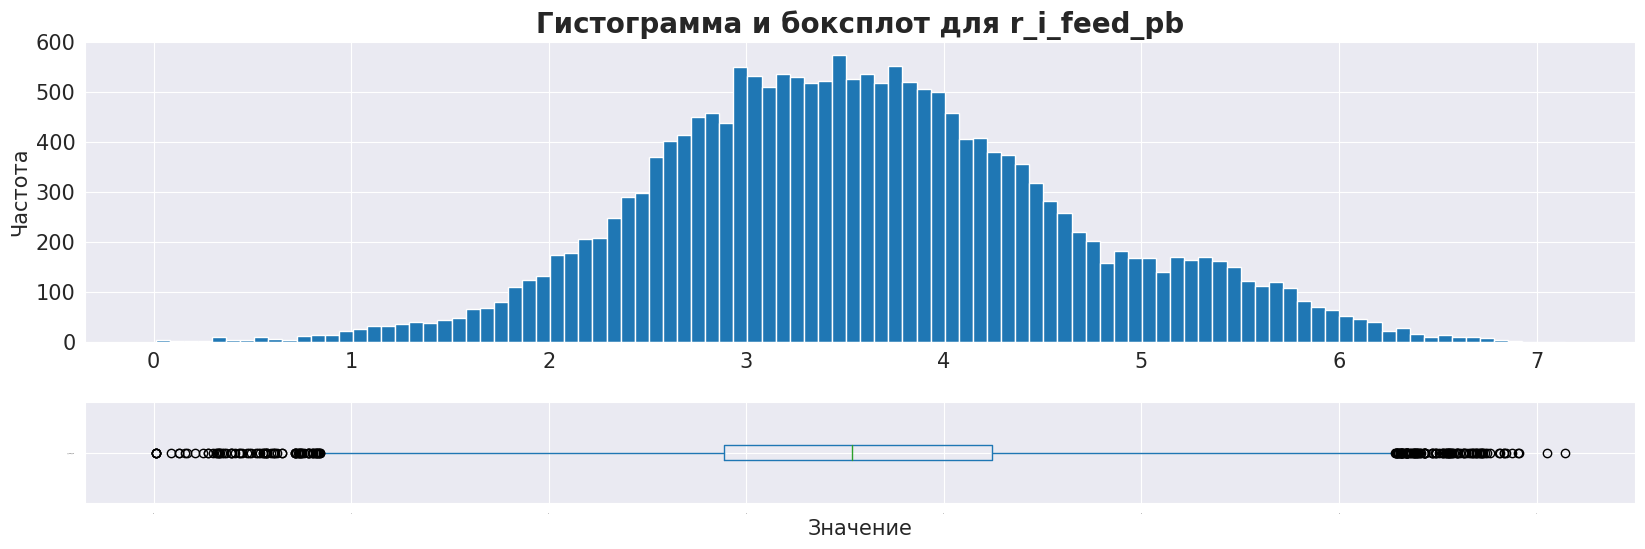

'Количество уникальных значений в столбце r_i_feed_pb: 19300'

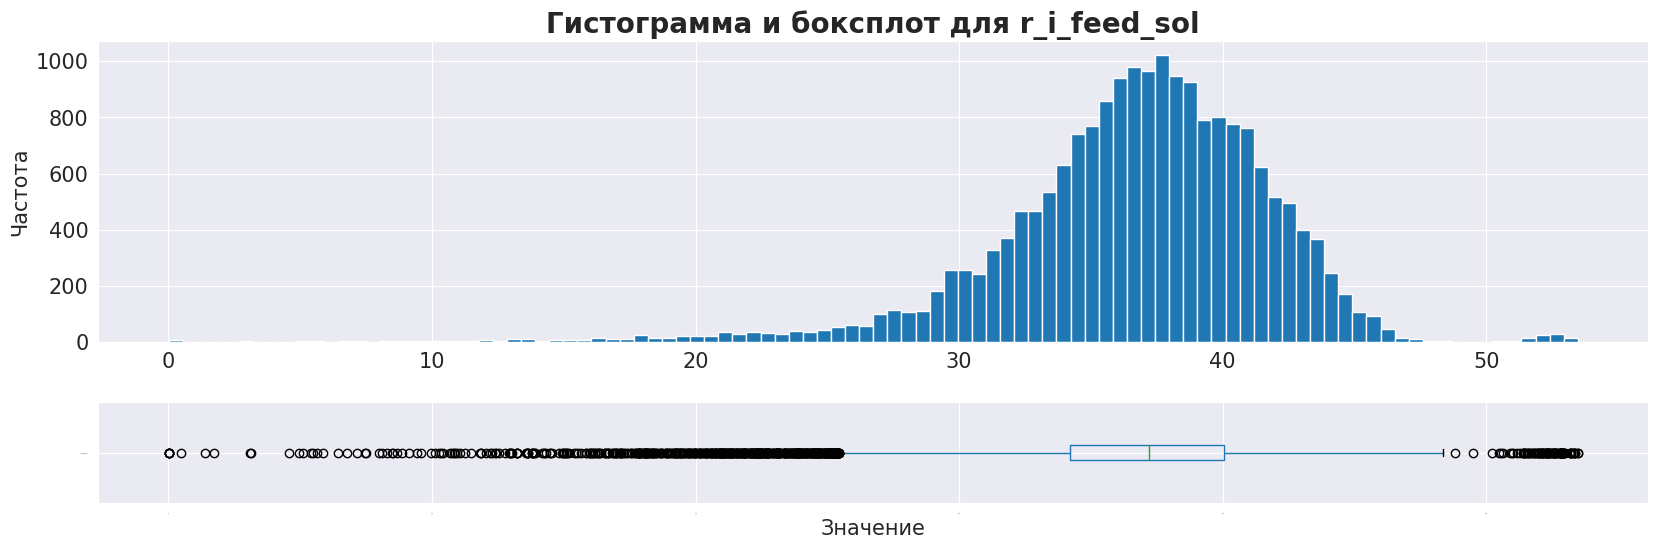

'Количество уникальных значений в столбце r_i_feed_sol: 19292'

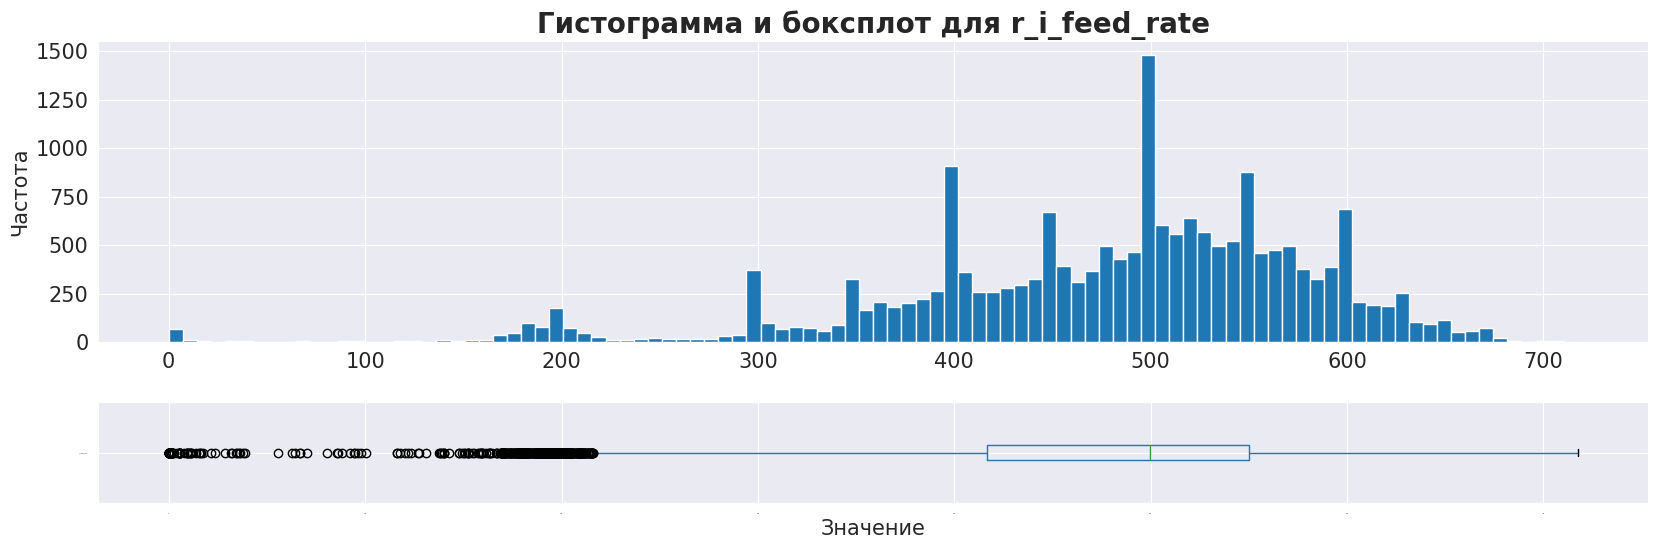

'Количество уникальных значений в столбце r_i_feed_rate: 19428'

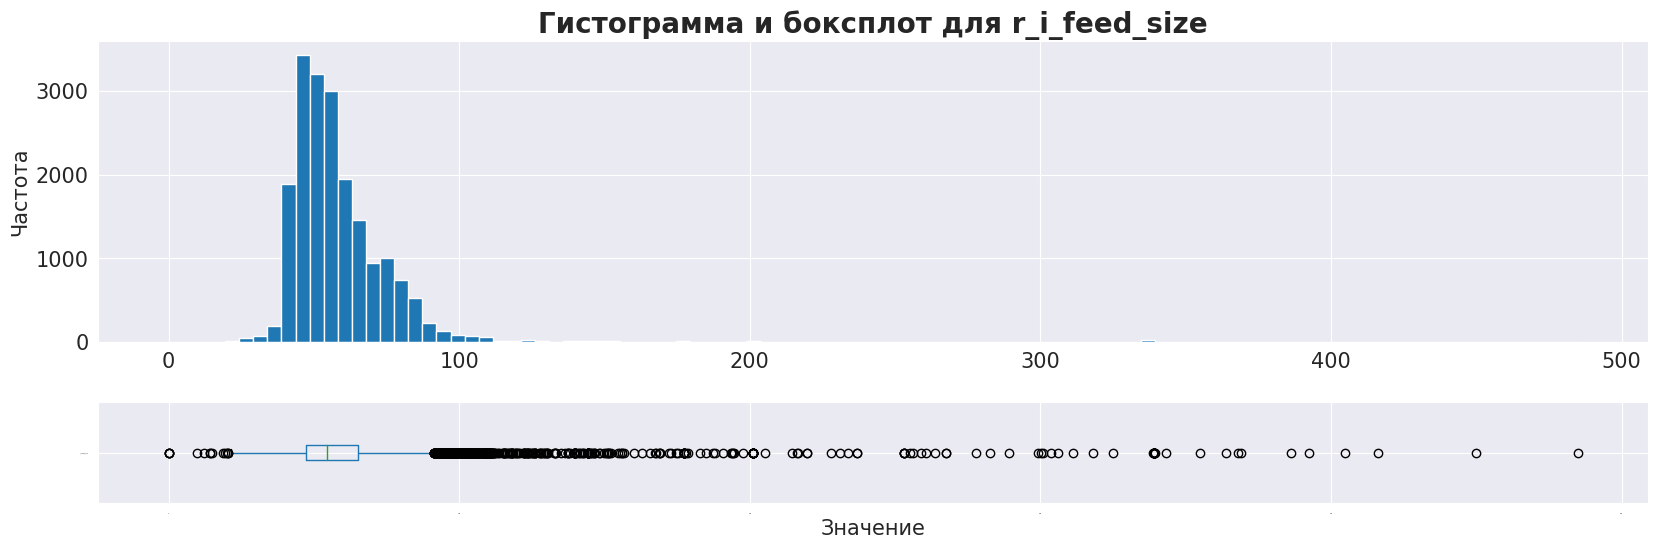

'Количество уникальных значений в столбце r_i_feed_size: 19286'

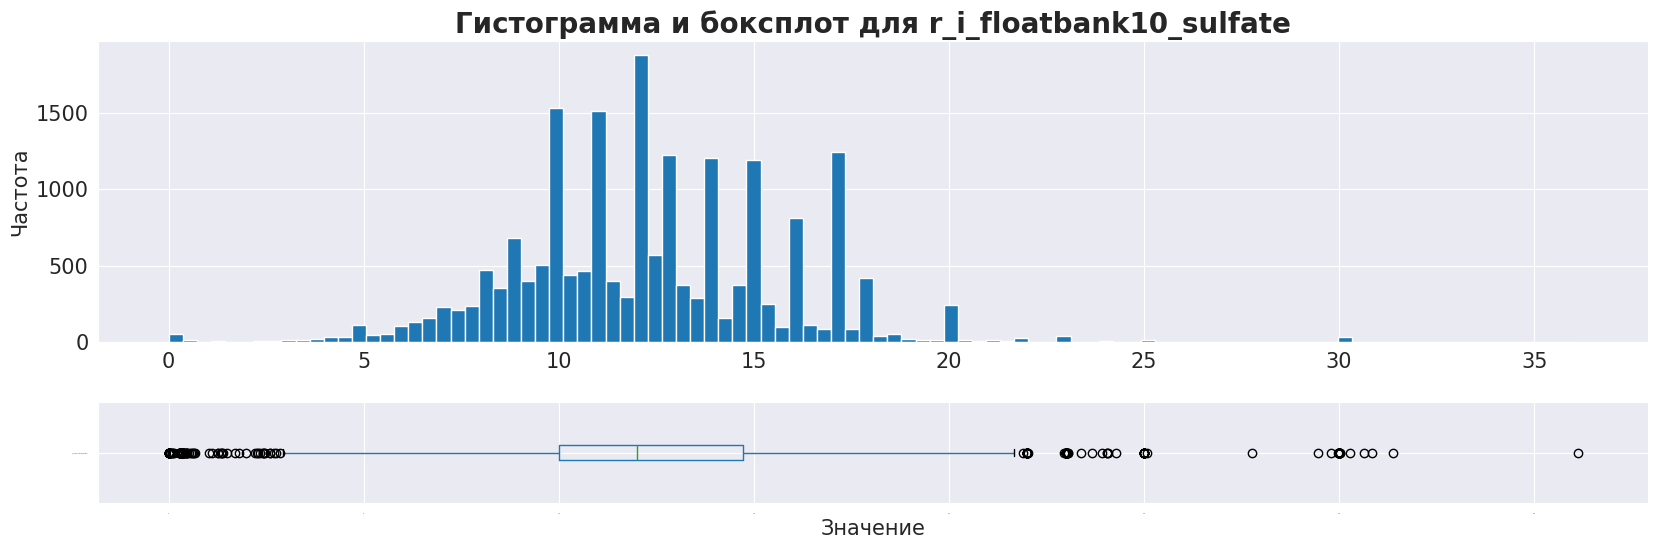

'Количество уникальных значений в столбце r_i_floatbank10_sulfate: 19405'

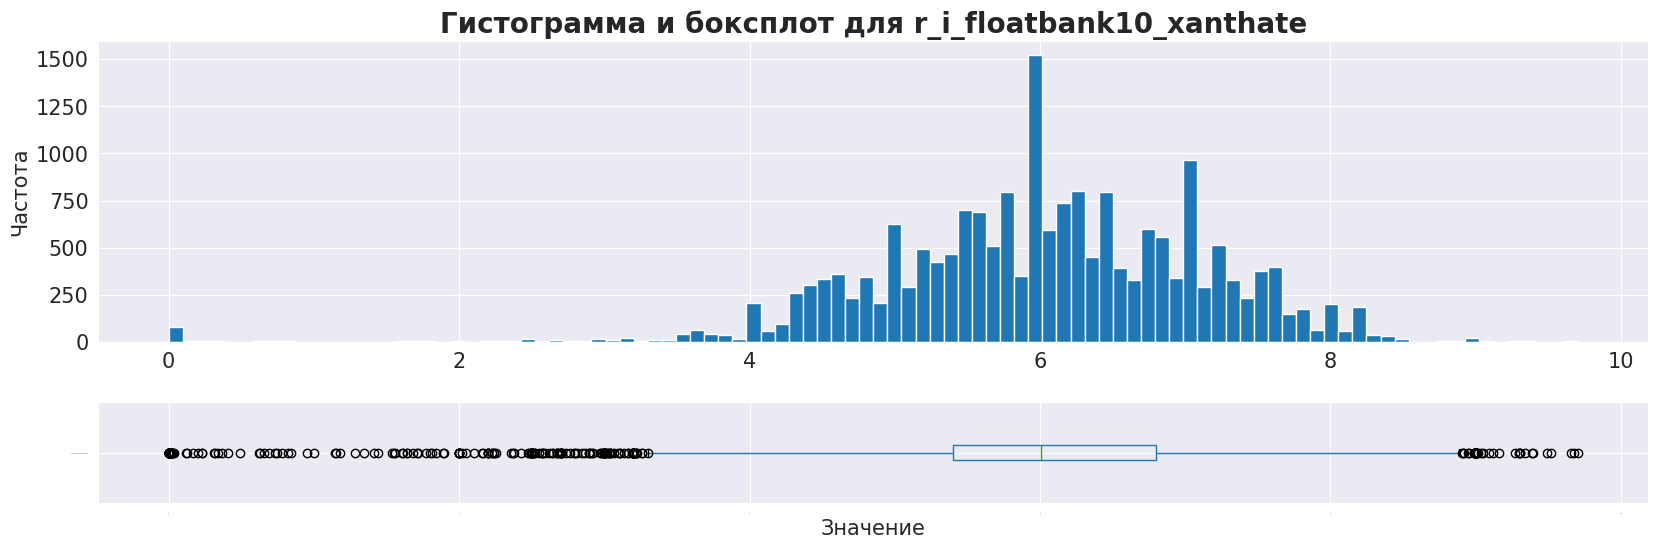

'Количество уникальных значений в столбце r_i_floatbank10_xanthate: 19431'

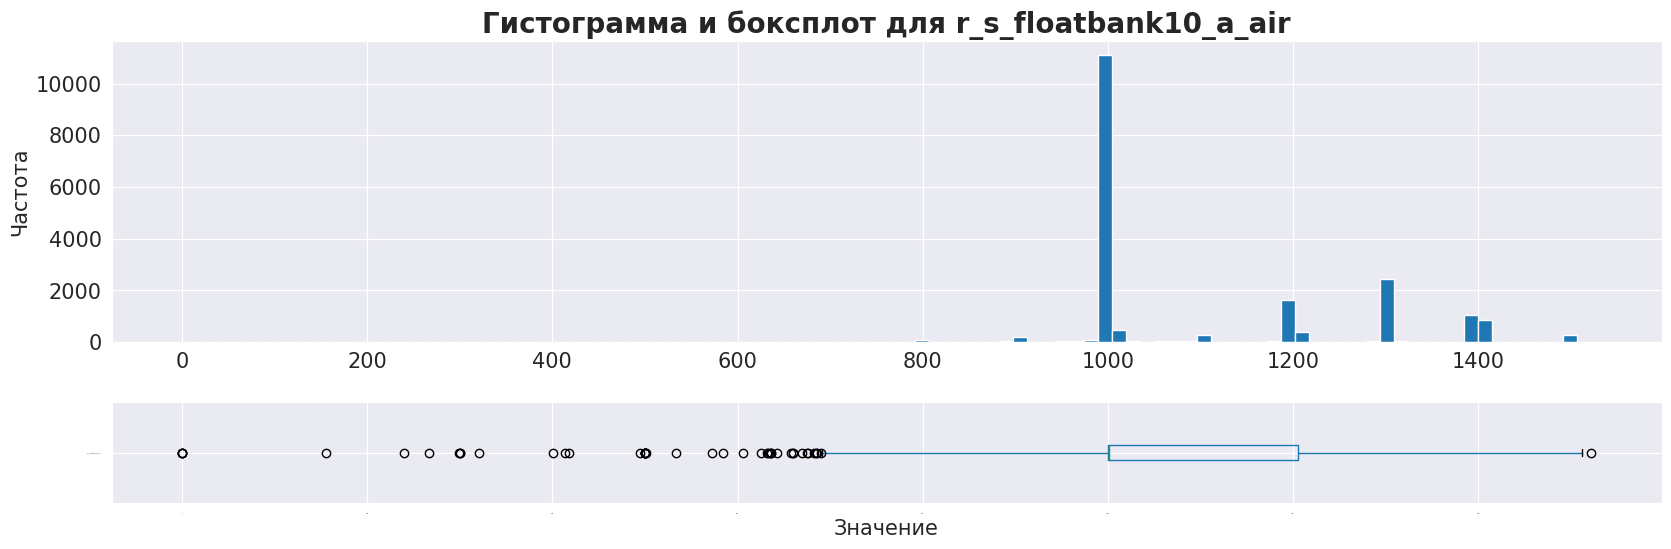

'Количество уникальных значений в столбце r_s_floatbank10_a_air: 19438'

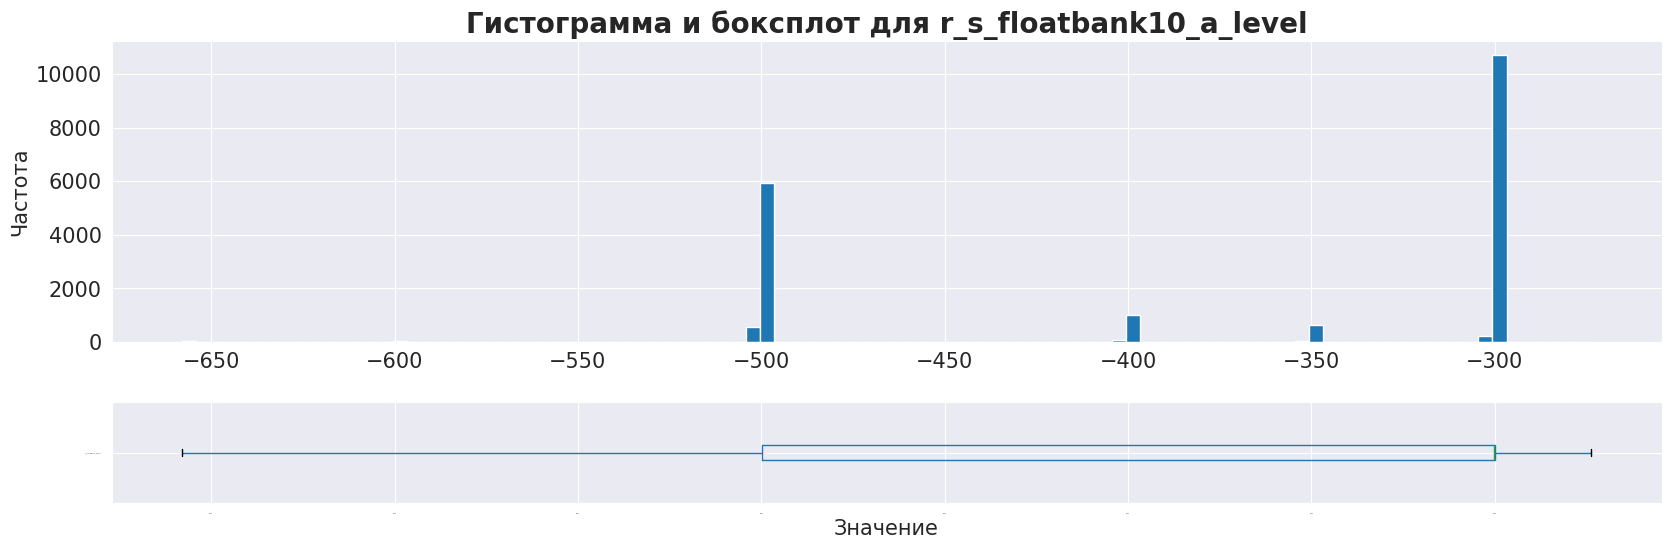

'Количество уникальных значений в столбце r_s_floatbank10_a_level: 19438'

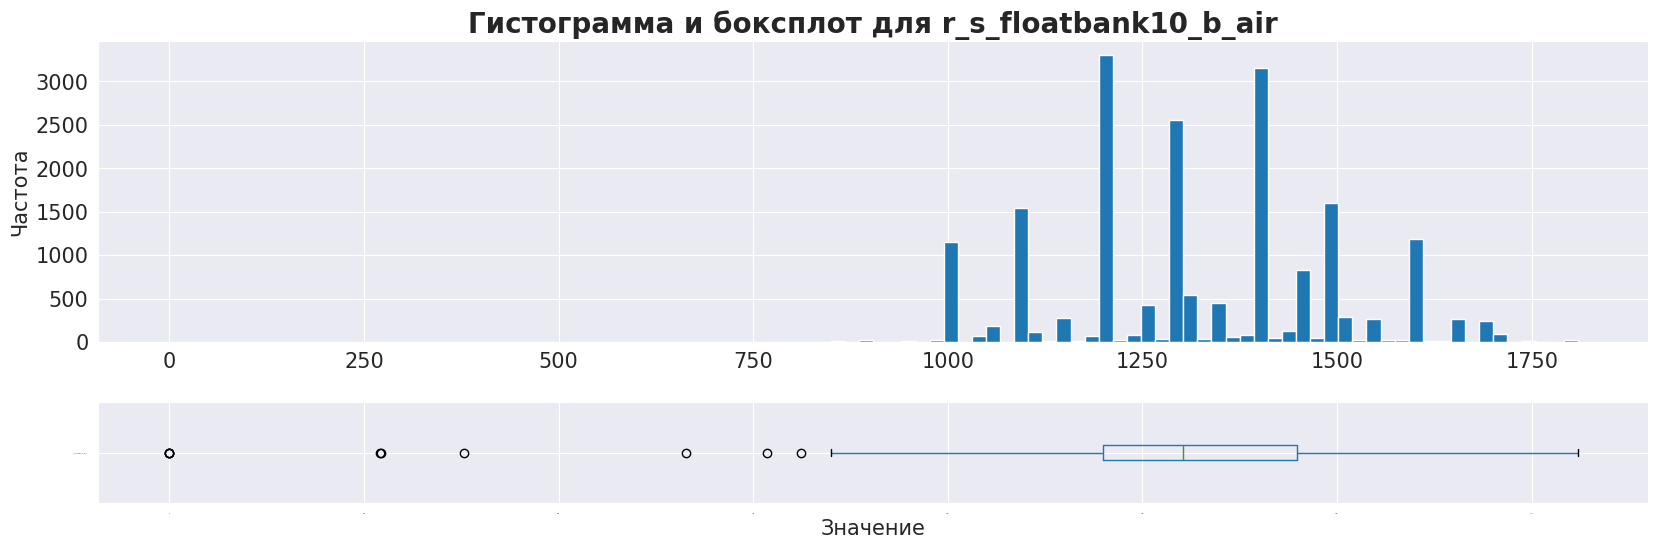

'Количество уникальных значений в столбце r_s_floatbank10_b_air: 19438'

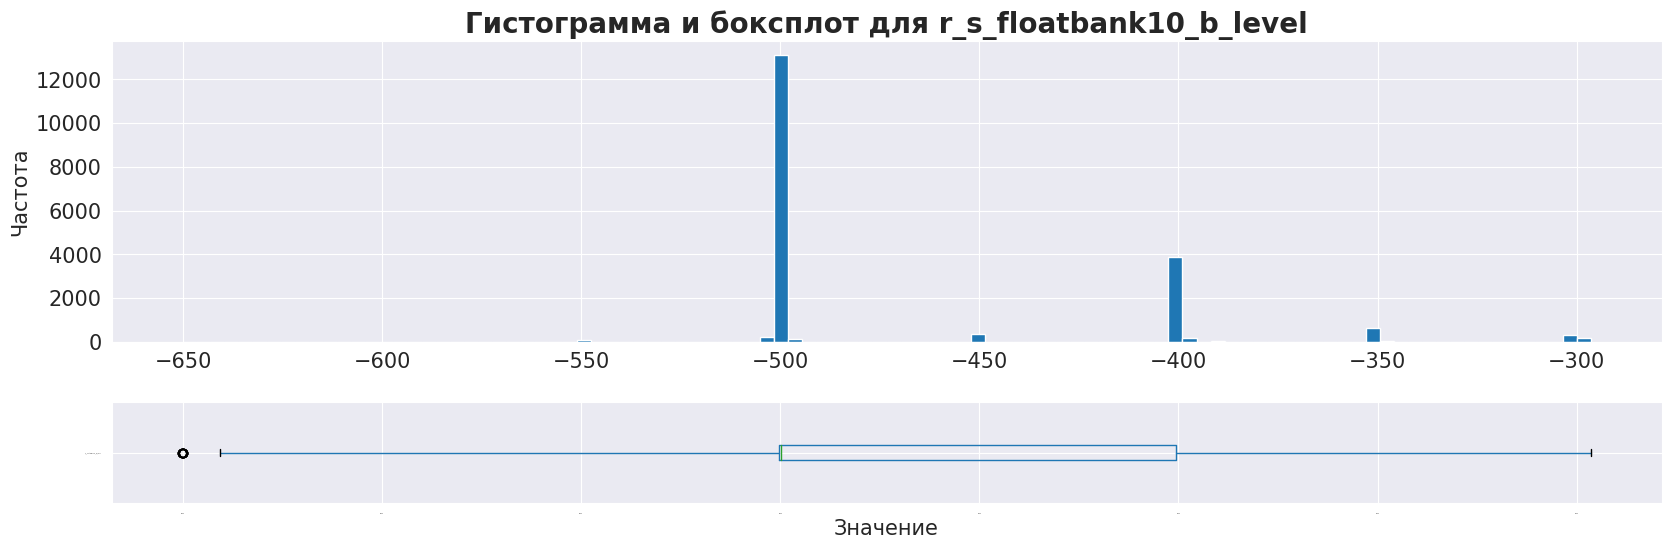

'Количество уникальных значений в столбце r_s_floatbank10_b_level: 19438'

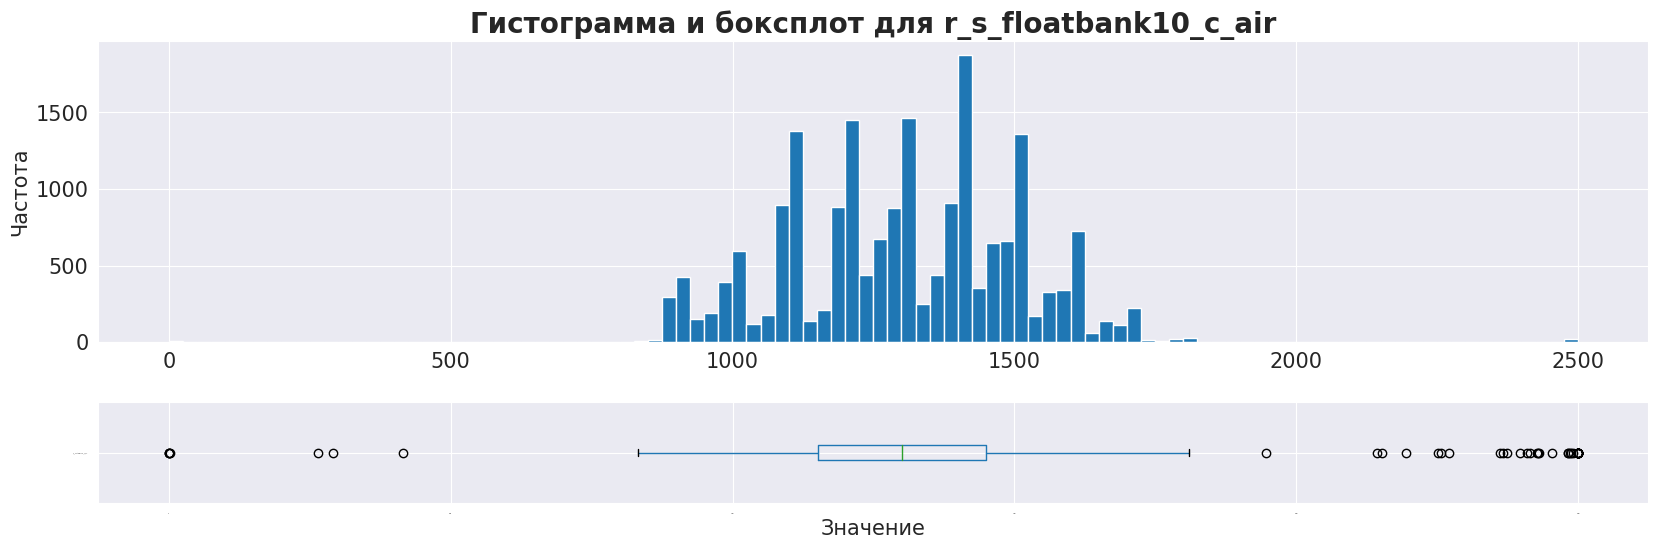

'Количество уникальных значений в столбце r_s_floatbank10_c_air: 19438'

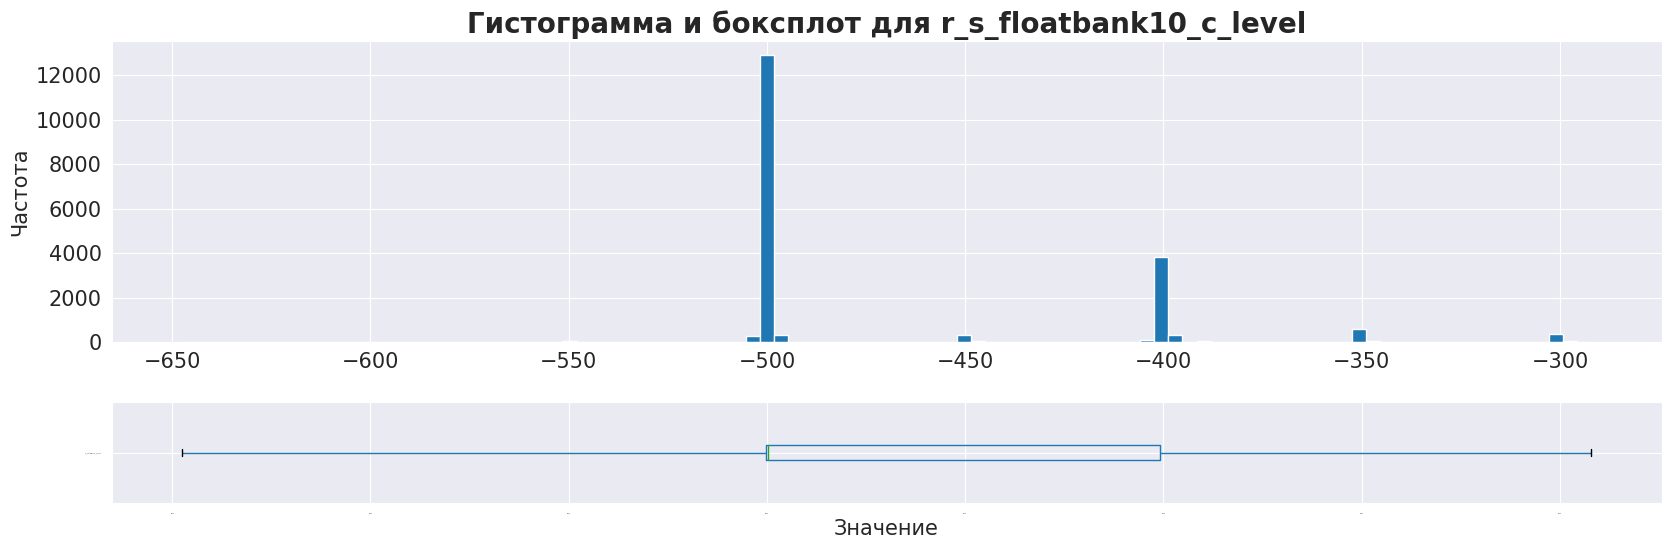

'Количество уникальных значений в столбце r_s_floatbank10_c_level: 19438'

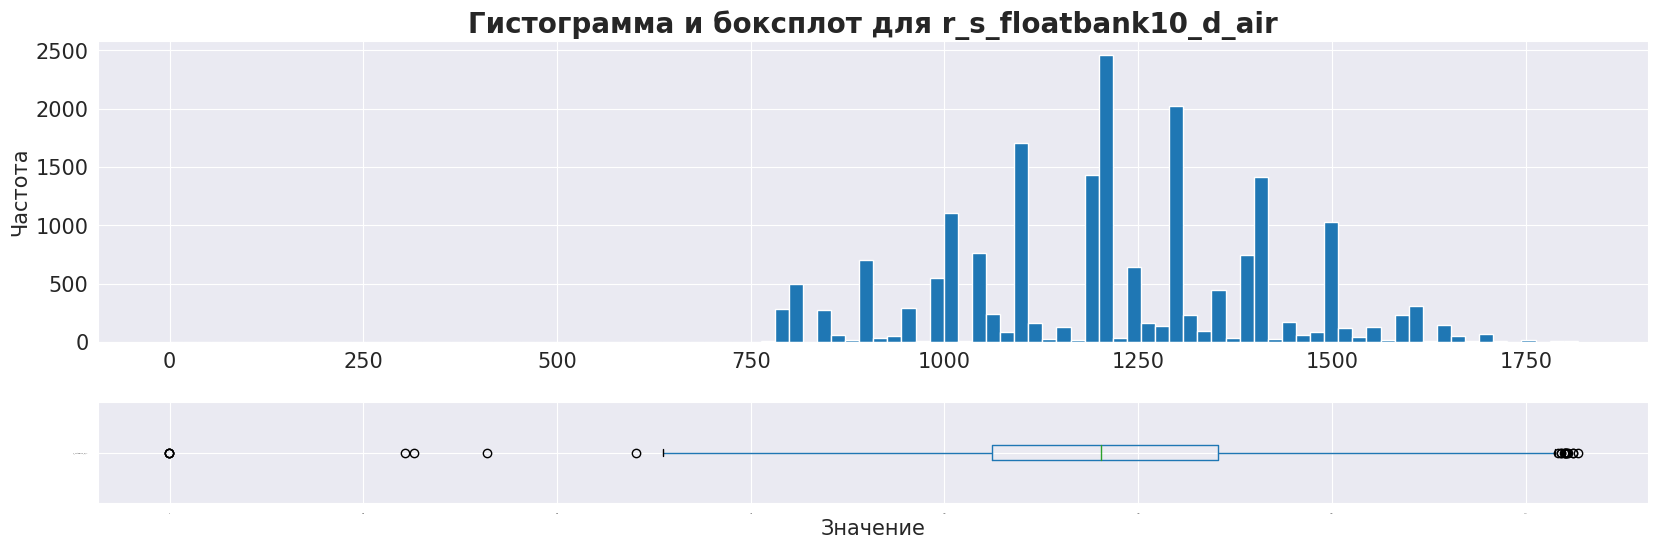

'Количество уникальных значений в столбце r_s_floatbank10_d_air: 19439'

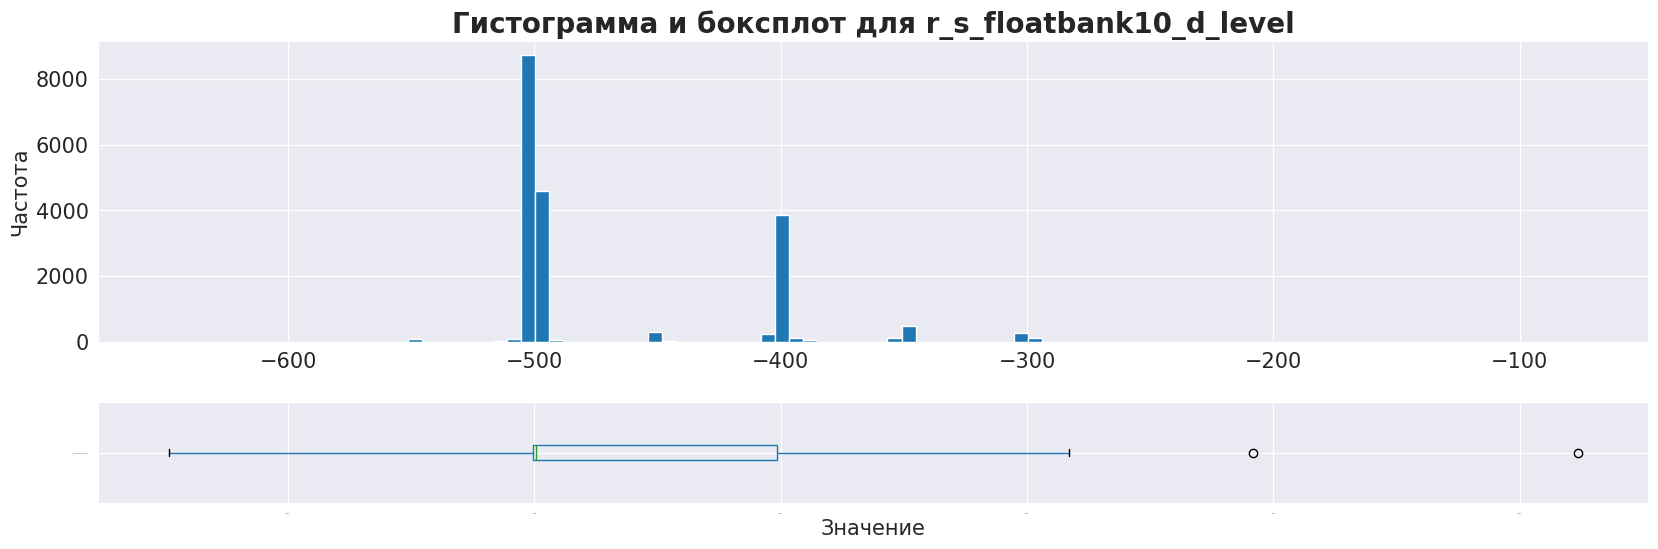

'Количество уникальных значений в столбце r_s_floatbank10_d_level: 19439'

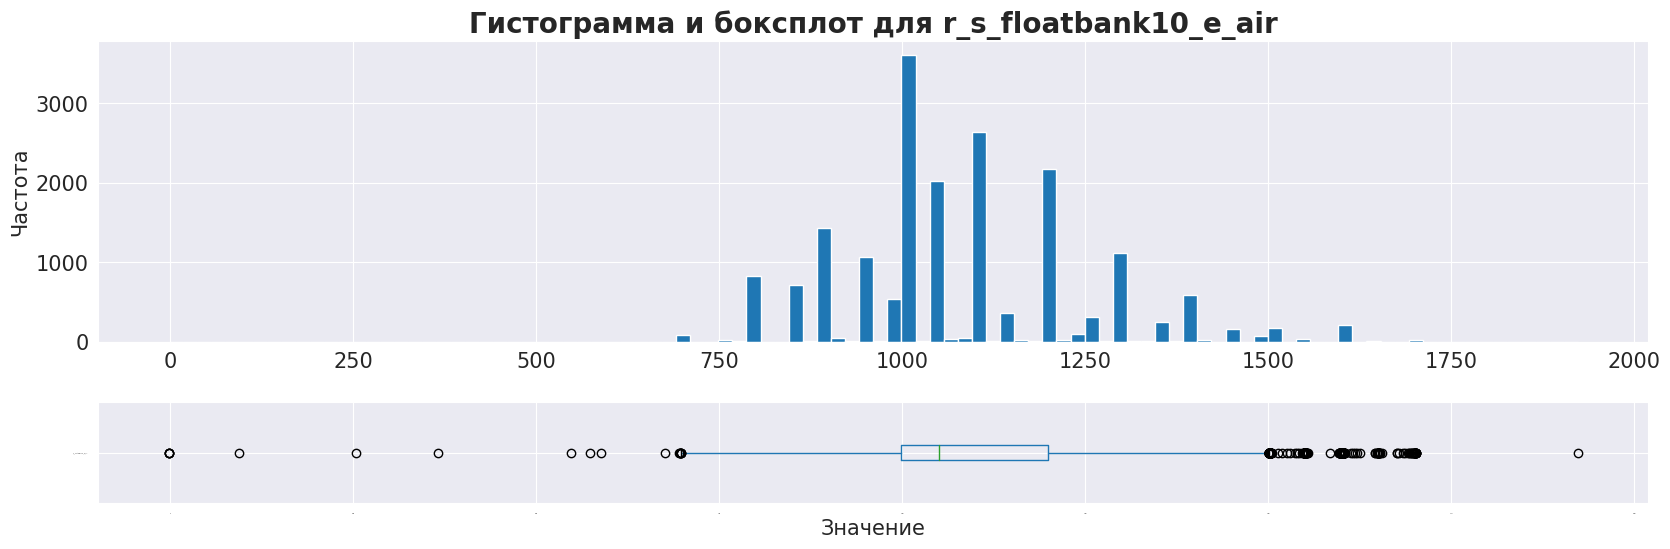

'Количество уникальных значений в столбце r_s_floatbank10_e_air: 19003'

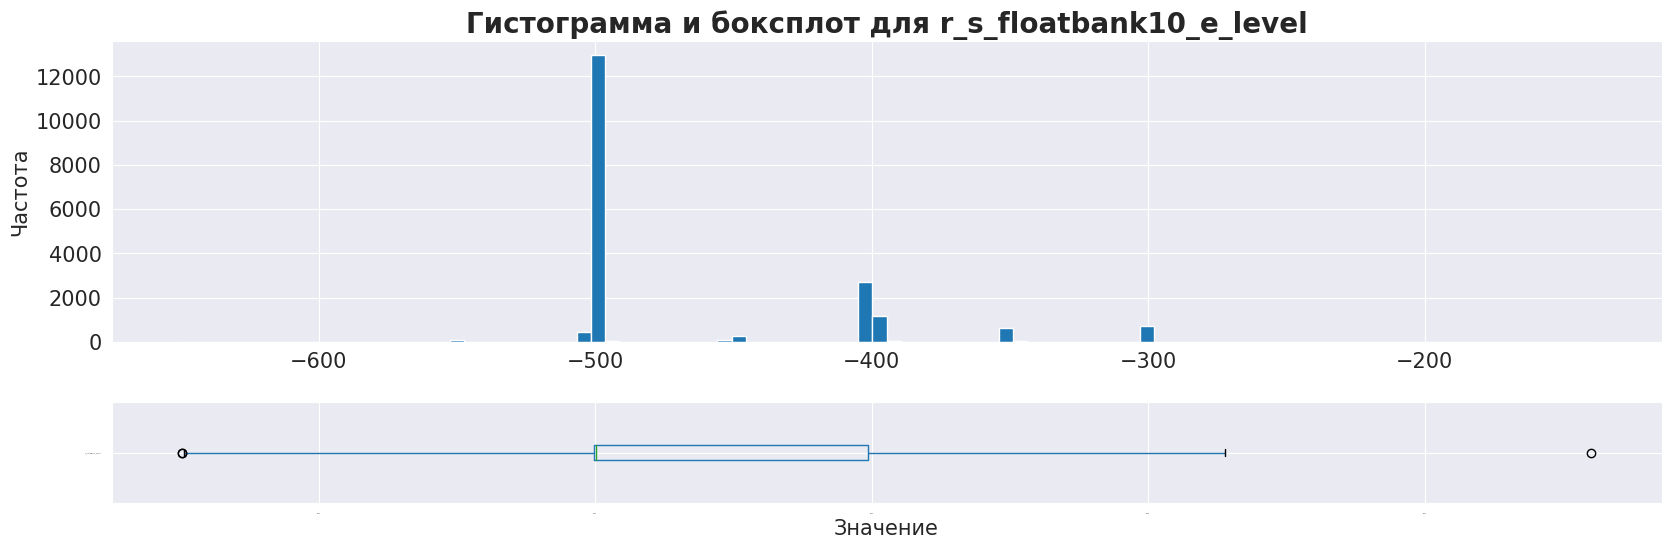

'Количество уникальных значений в столбце r_s_floatbank10_e_level: 19439'

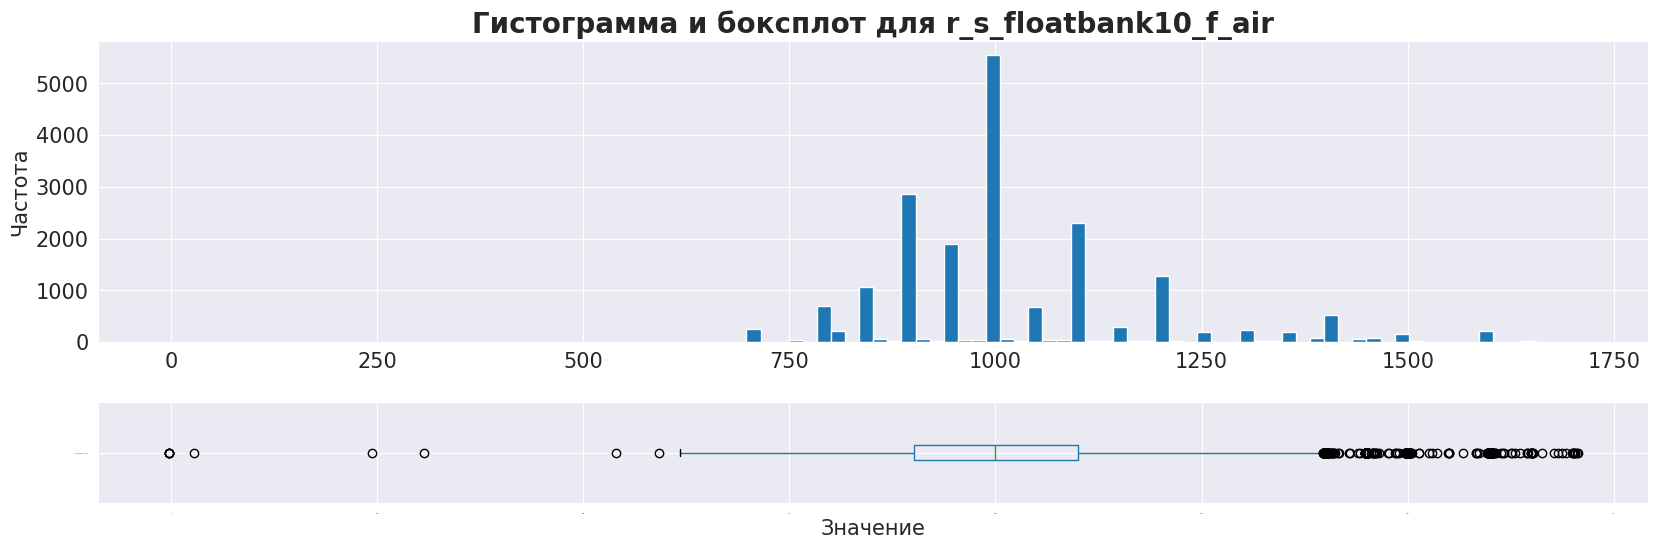

'Количество уникальных значений в столбце r_s_floatbank10_f_air: 19439'

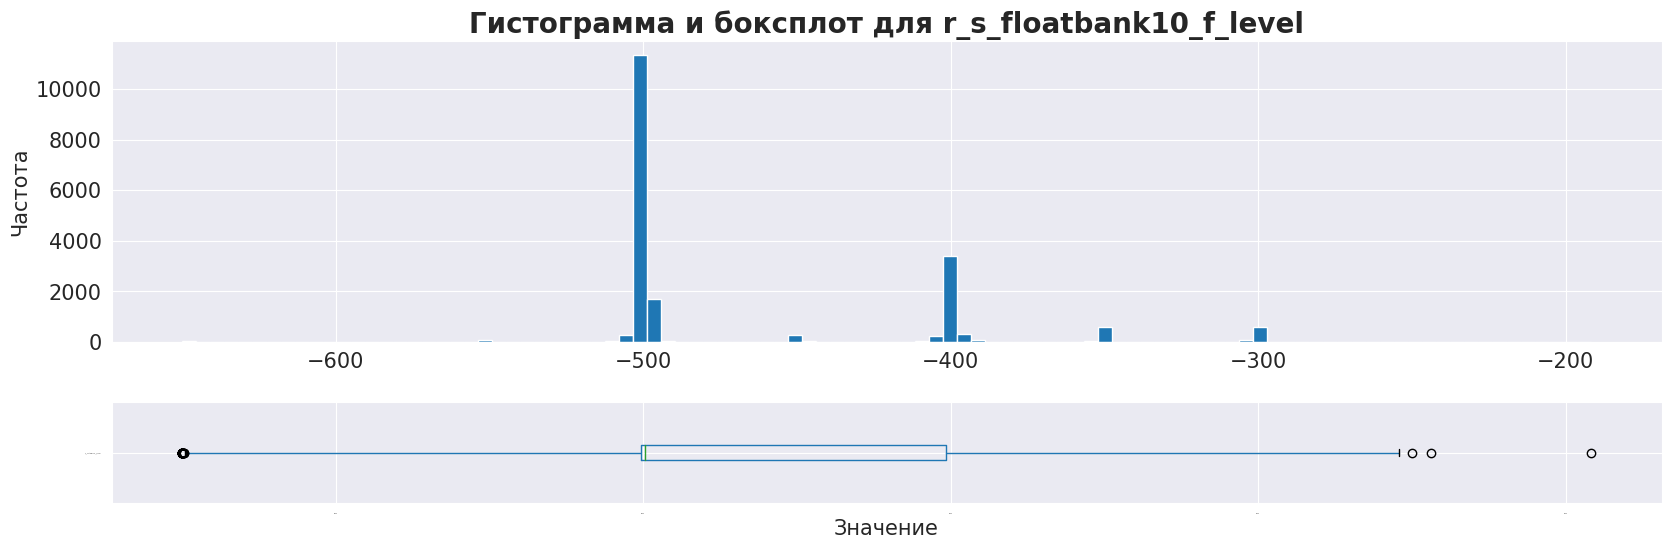

'Количество уникальных значений в столбце r_s_floatbank10_f_level: 19438'

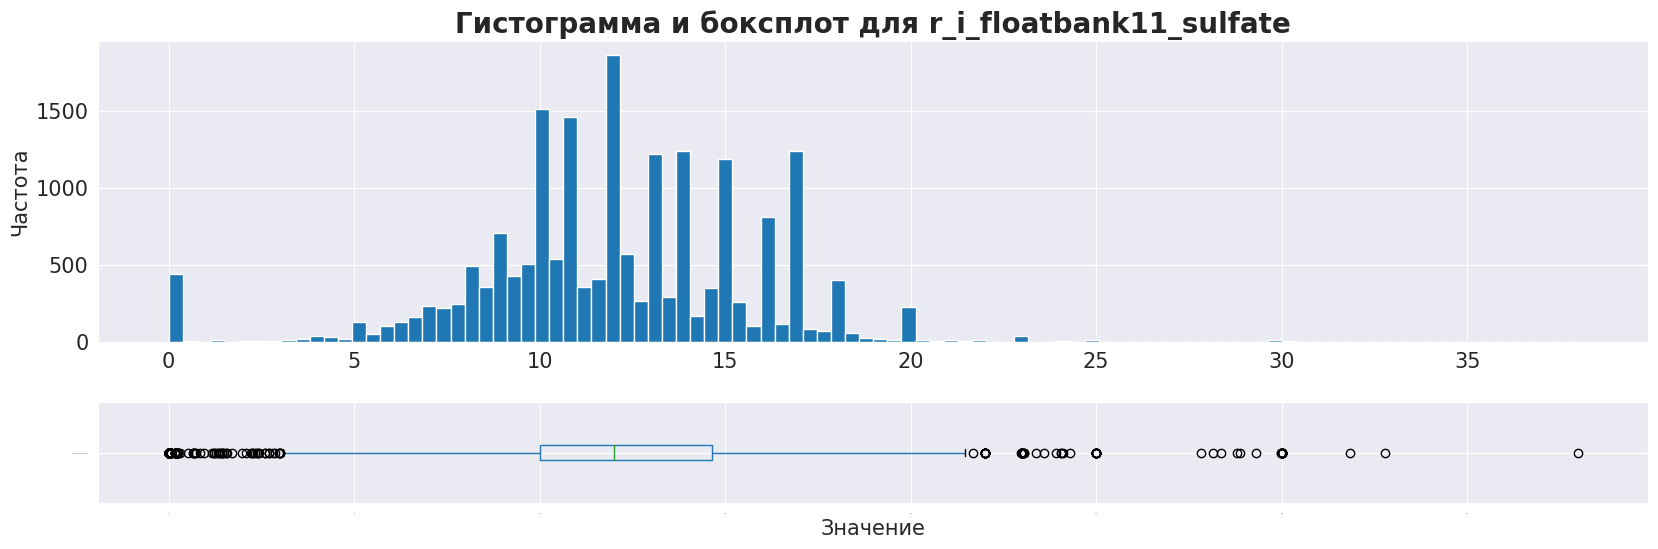

'Количество уникальных значений в столбце r_i_floatbank11_sulfate: 19395'

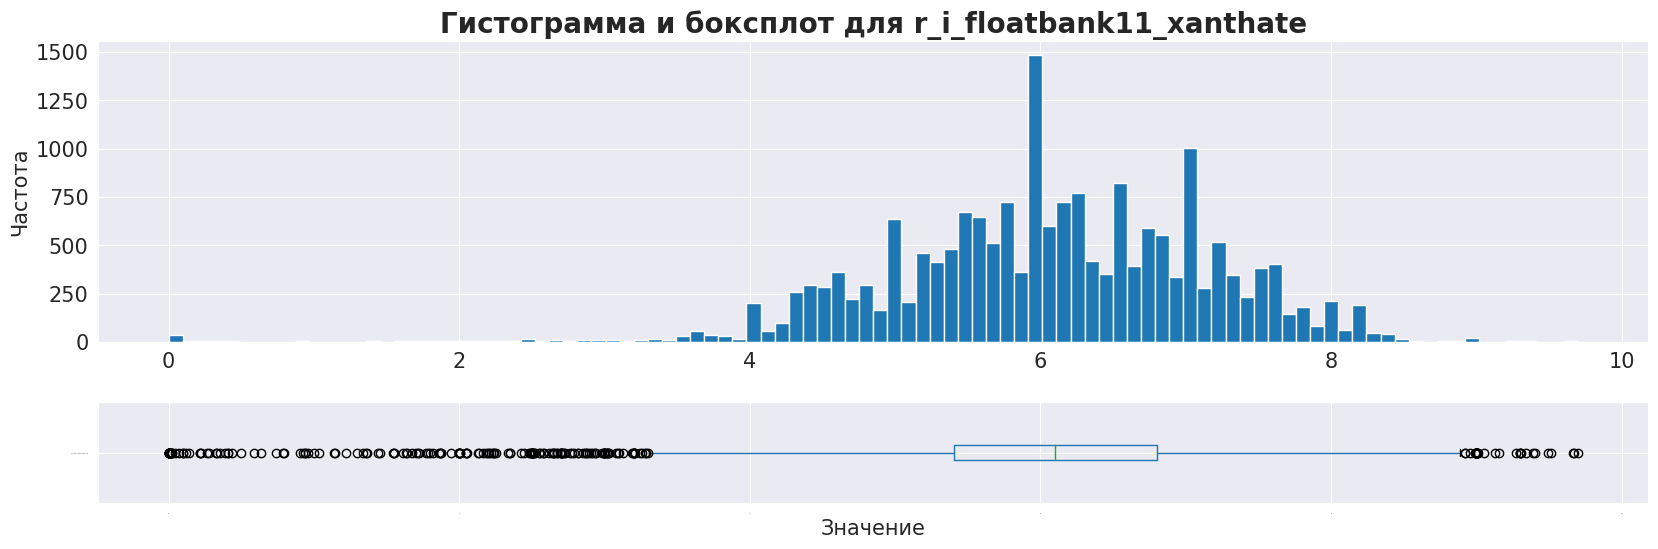

'Количество уникальных значений в столбце r_i_floatbank11_xanthate: 18971'

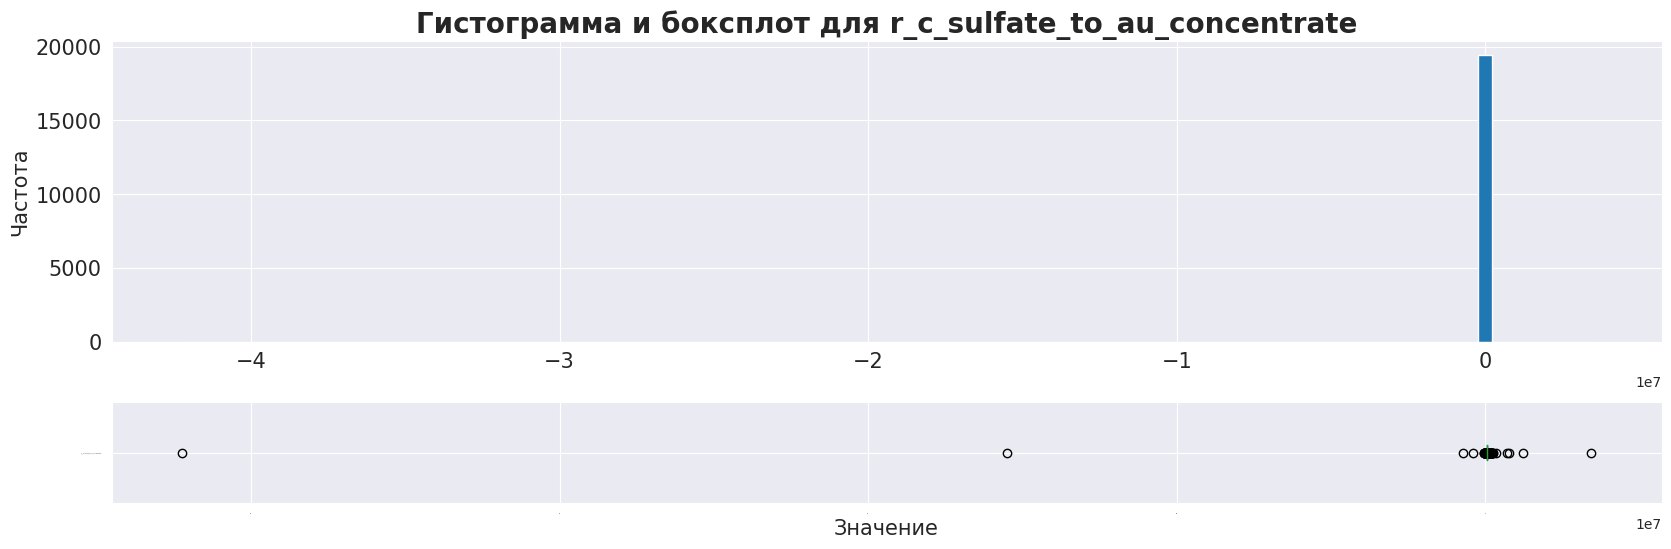

'Количество уникальных значений в столбце r_c_sulfate_to_au_concentrate: 19437'

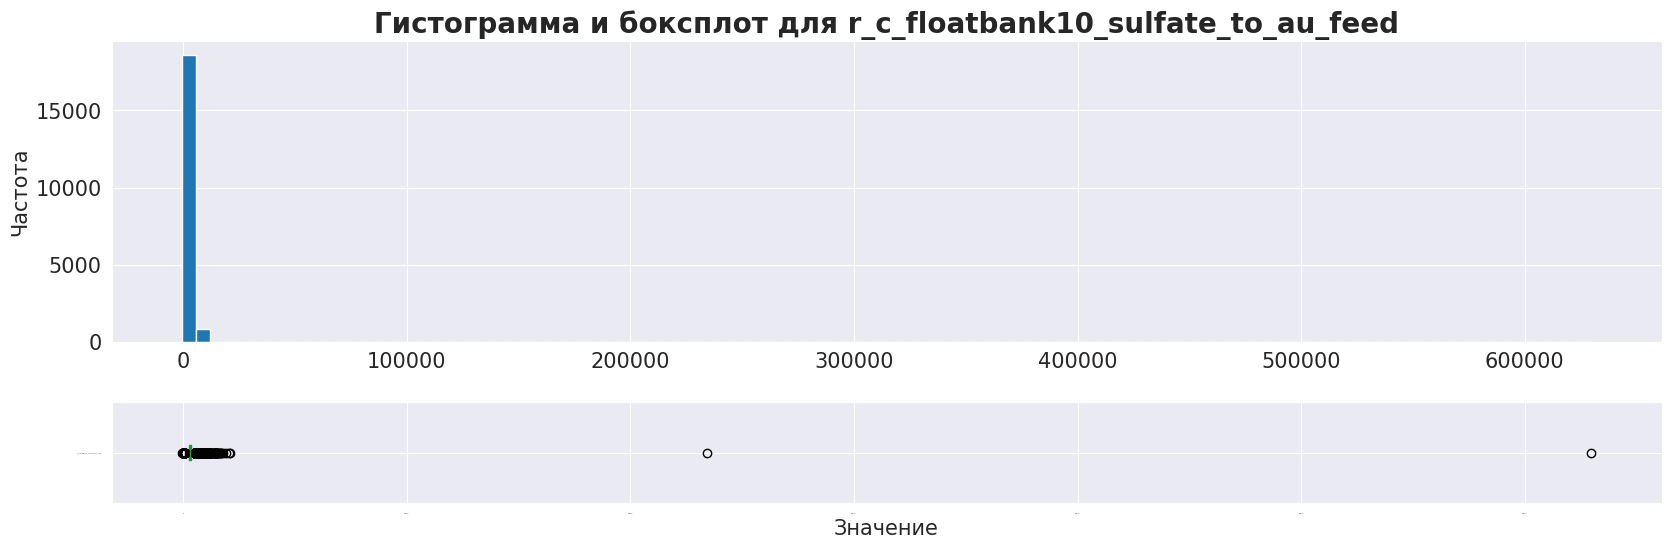

'Количество уникальных значений в столбце r_c_floatbank10_sulfate_to_au_feed: 19437'

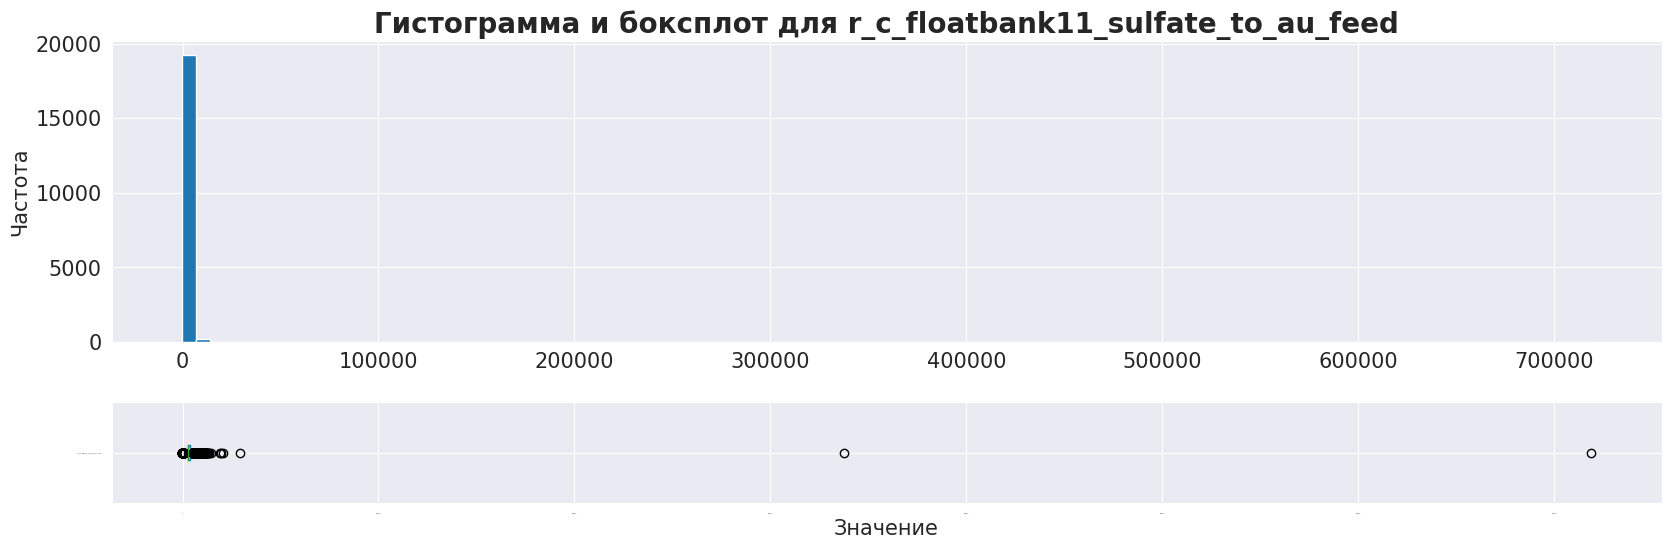

'Количество уникальных значений в столбце r_c_floatbank11_sulfate_to_au_feed: 19437'

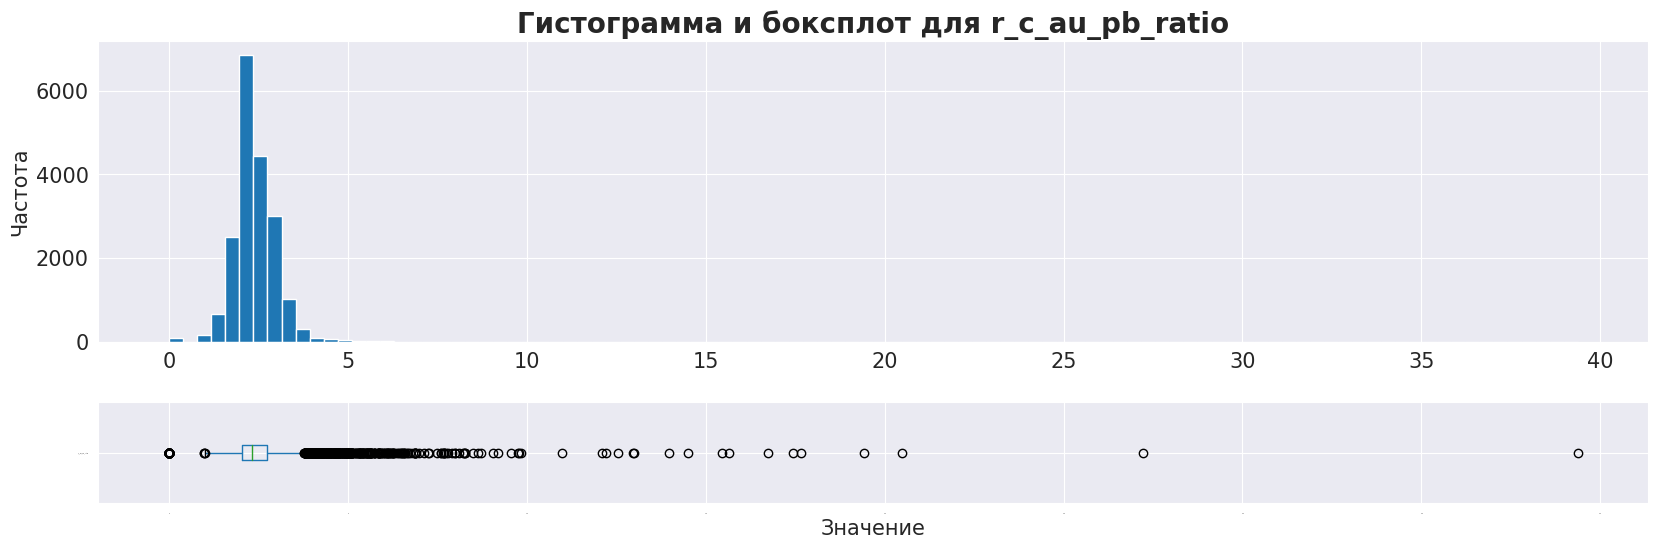

'Количество уникальных значений в столбце r_c_au_pb_ratio: 19409'

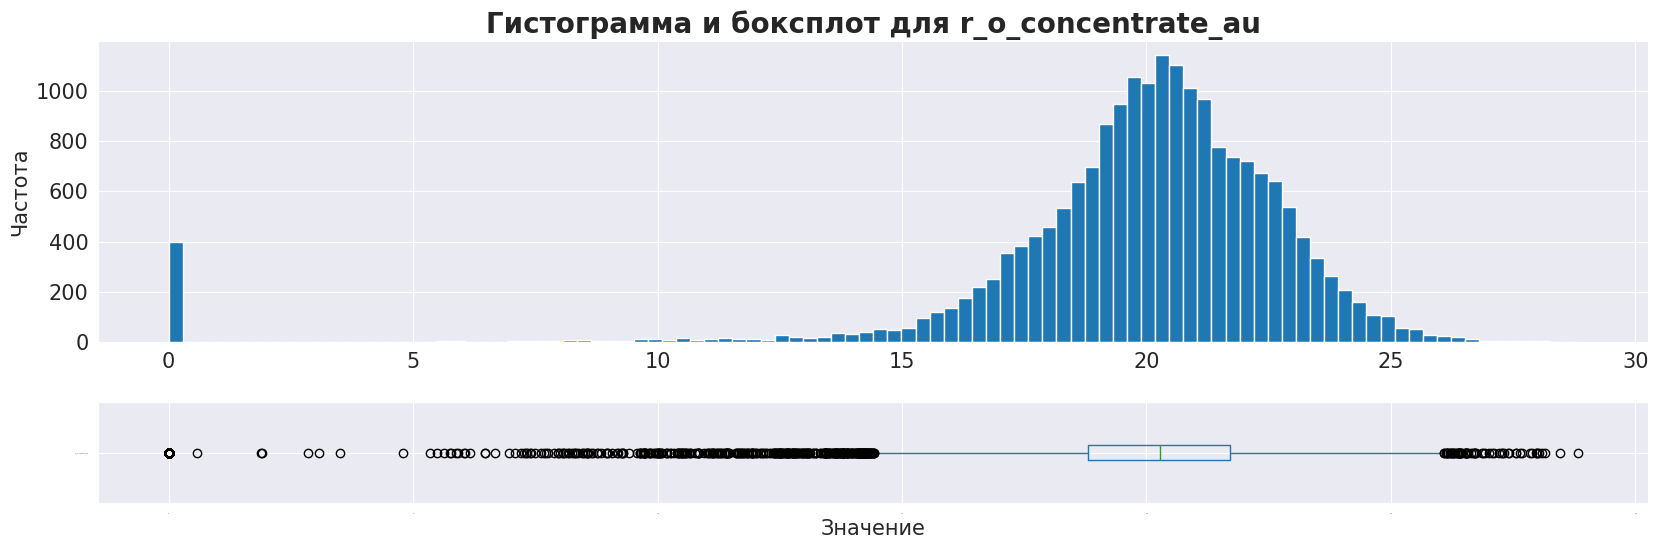

'Количество уникальных значений в столбце r_o_concentrate_au: 19015'

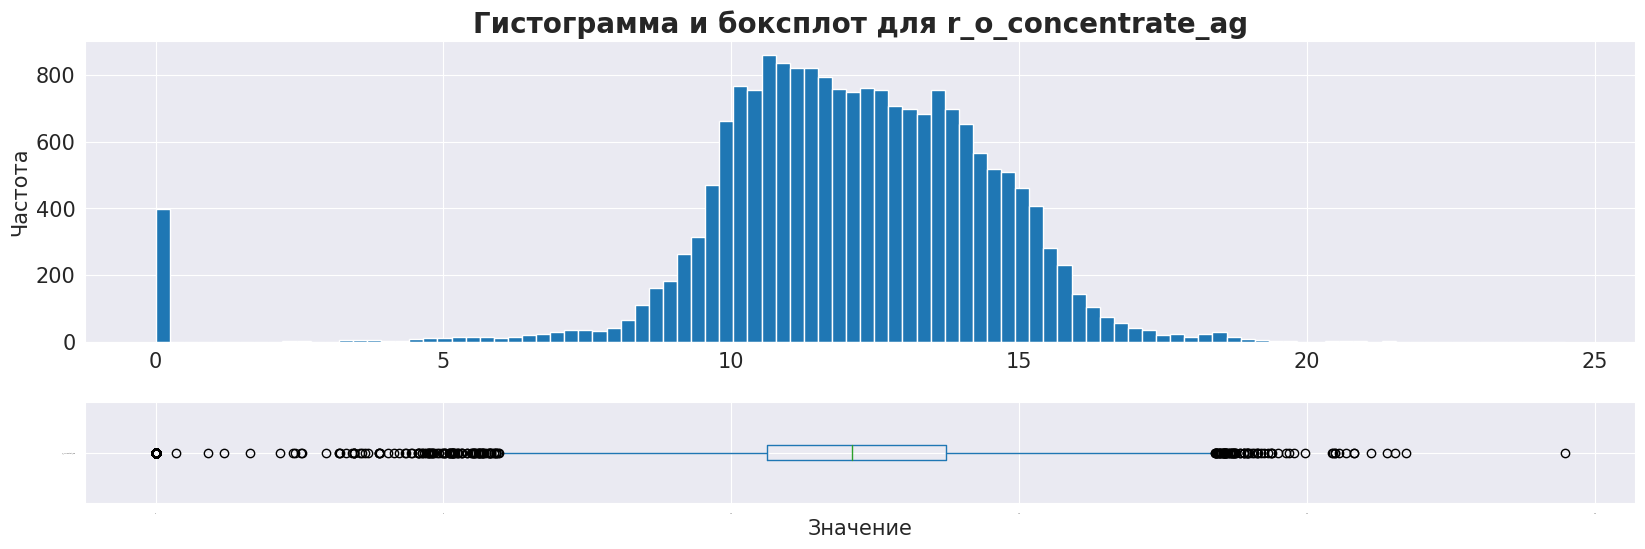

'Количество уникальных значений в столбце r_o_concentrate_ag: 19015'

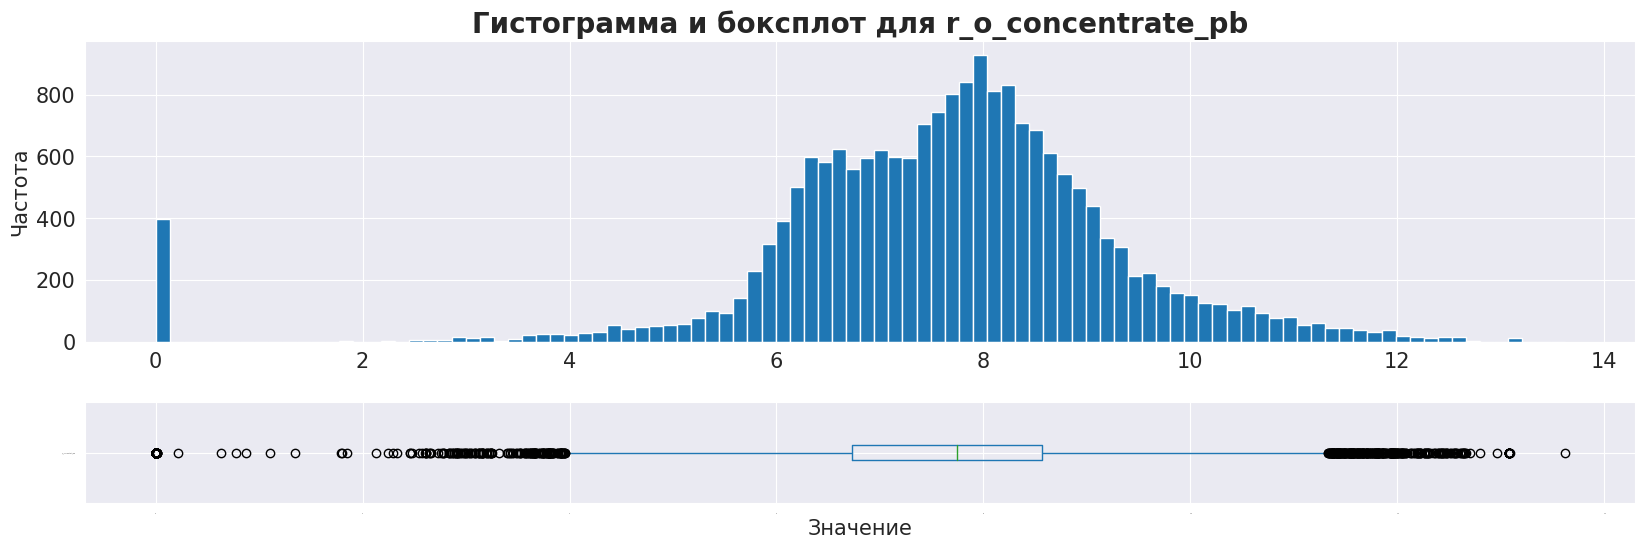

'Количество уникальных значений в столбце r_o_concentrate_pb: 18956'

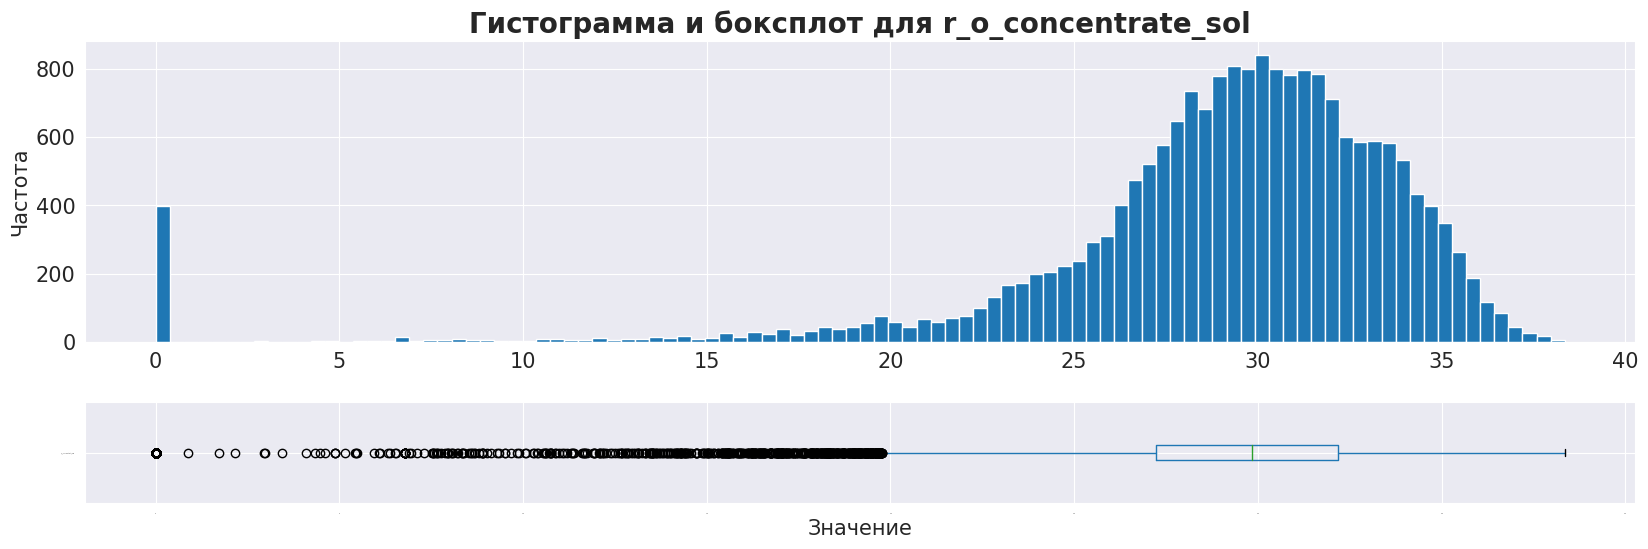

'Количество уникальных значений в столбце r_o_concentrate_sol: 18664'

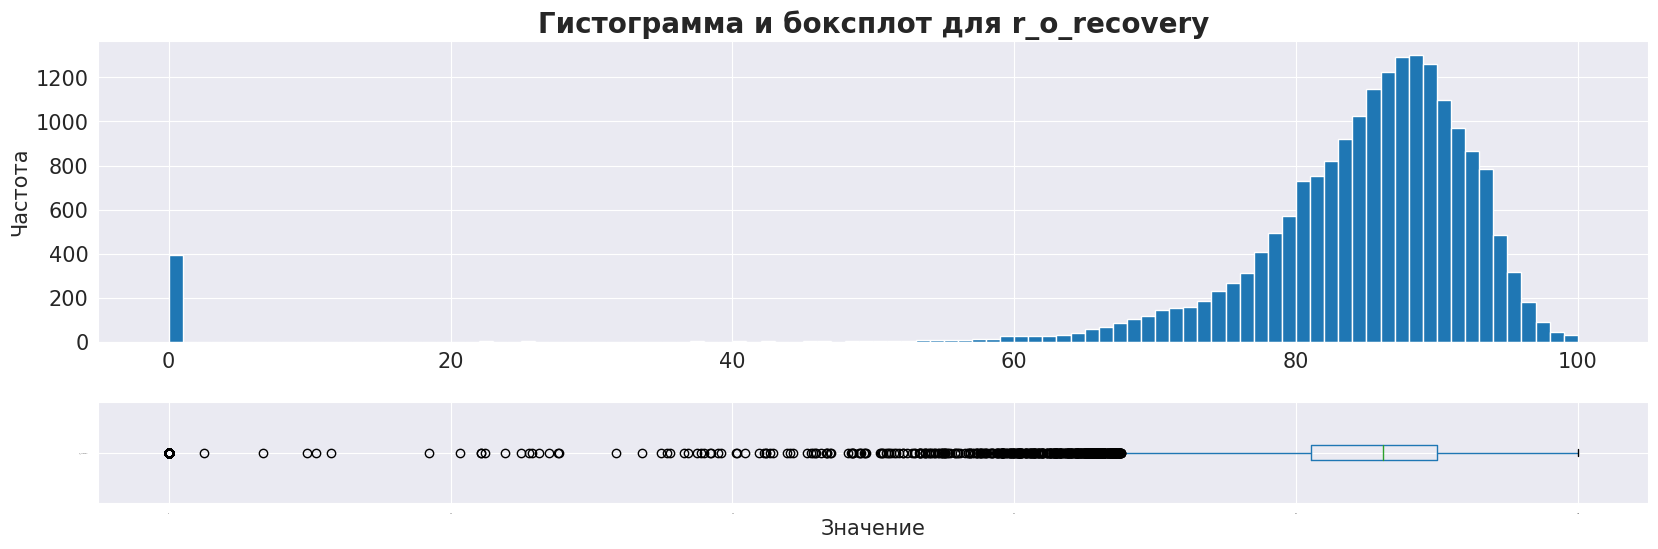

'Количество уникальных значений в столбце r_o_recovery: 19017'

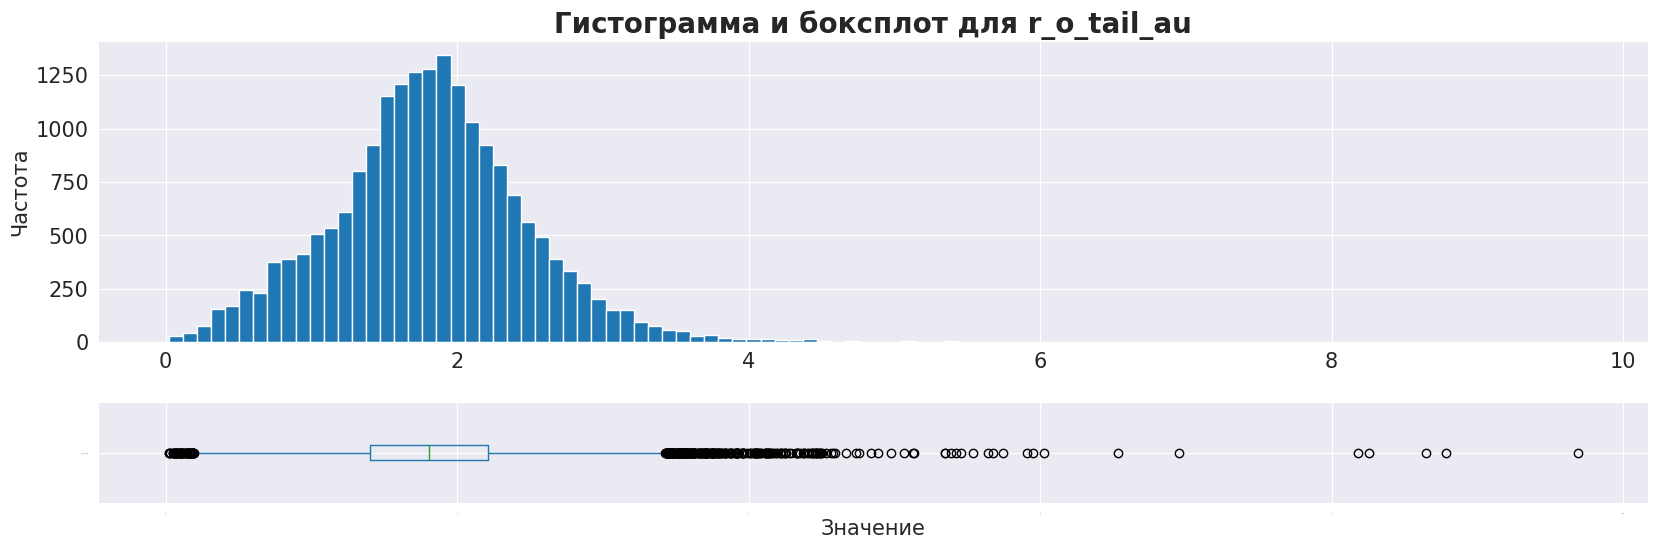

'Количество уникальных значений в столбце r_o_tail_au: 19399'

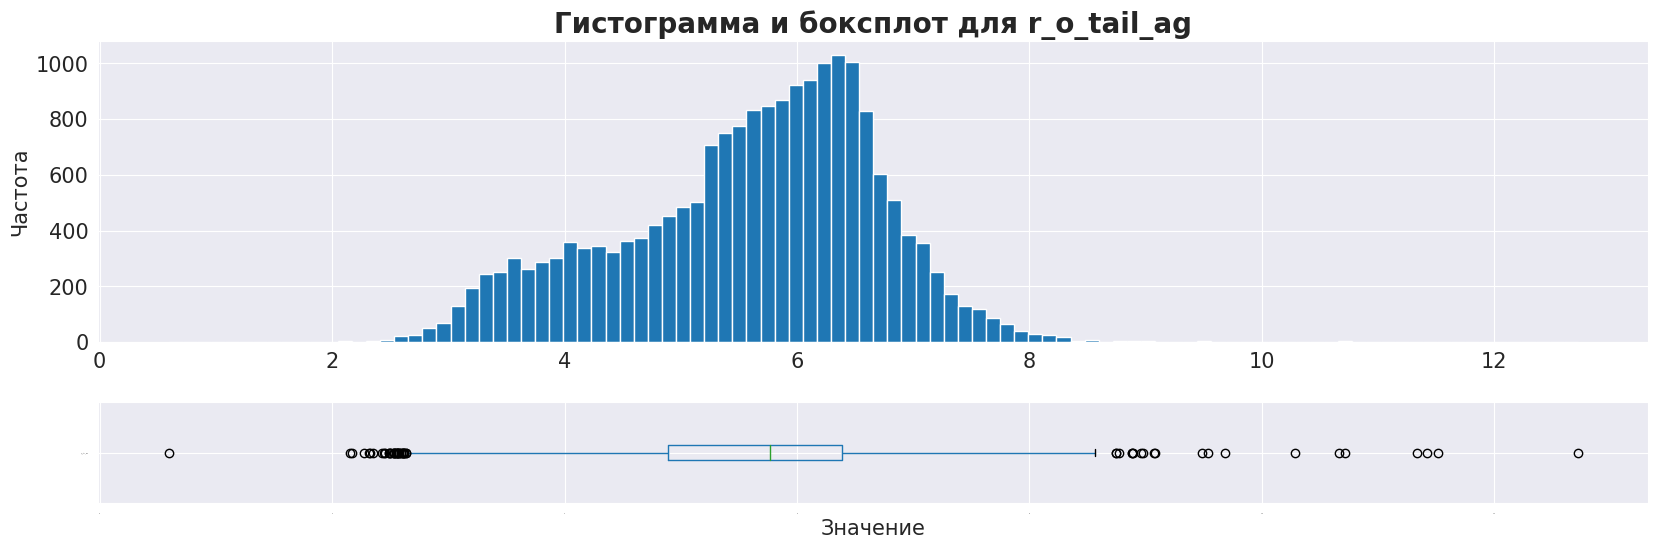

'Количество уникальных значений в столбце r_o_tail_ag: 19397'

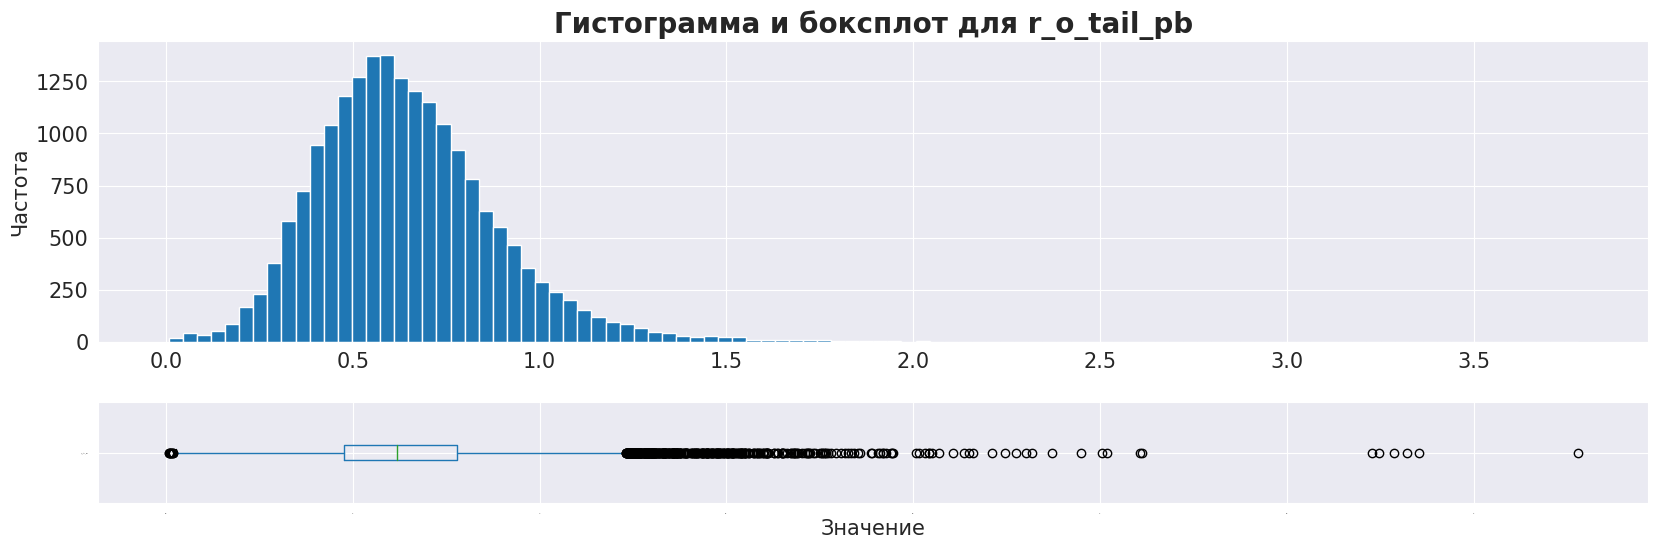

'Количество уникальных значений в столбце r_o_tail_pb: 19409'

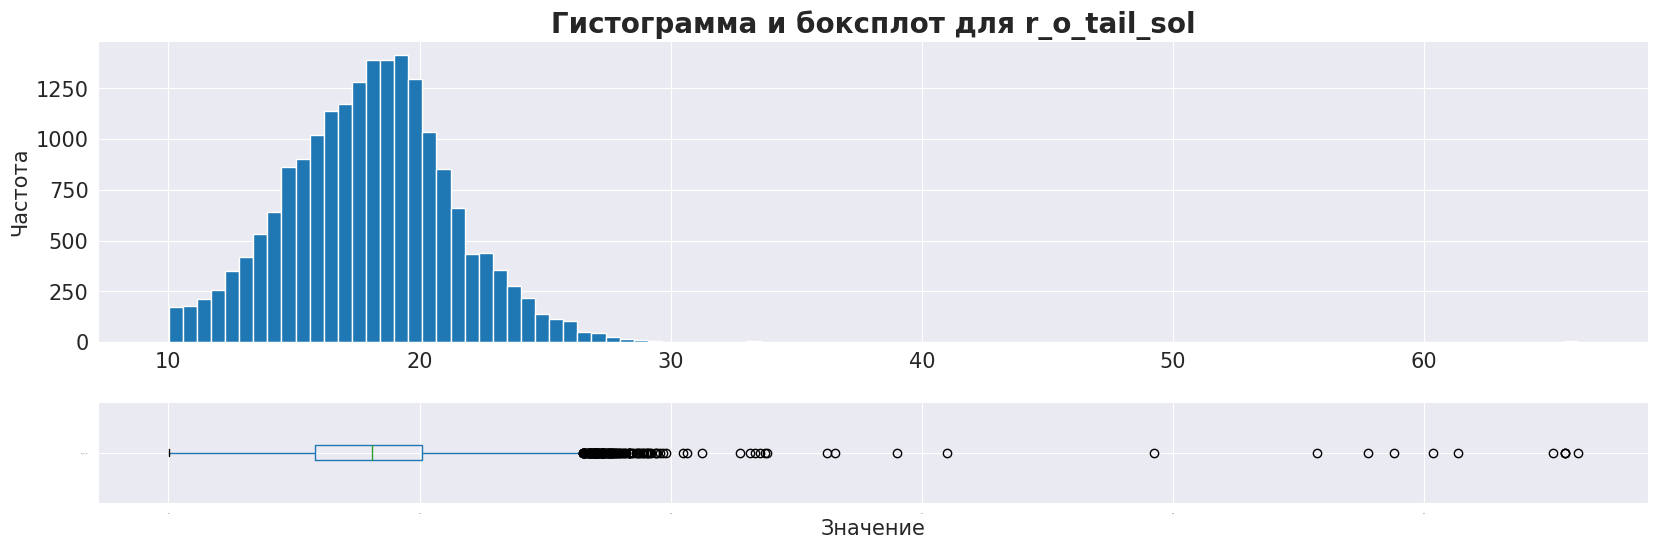

'Количество уникальных значений в столбце r_o_tail_sol: 19272'

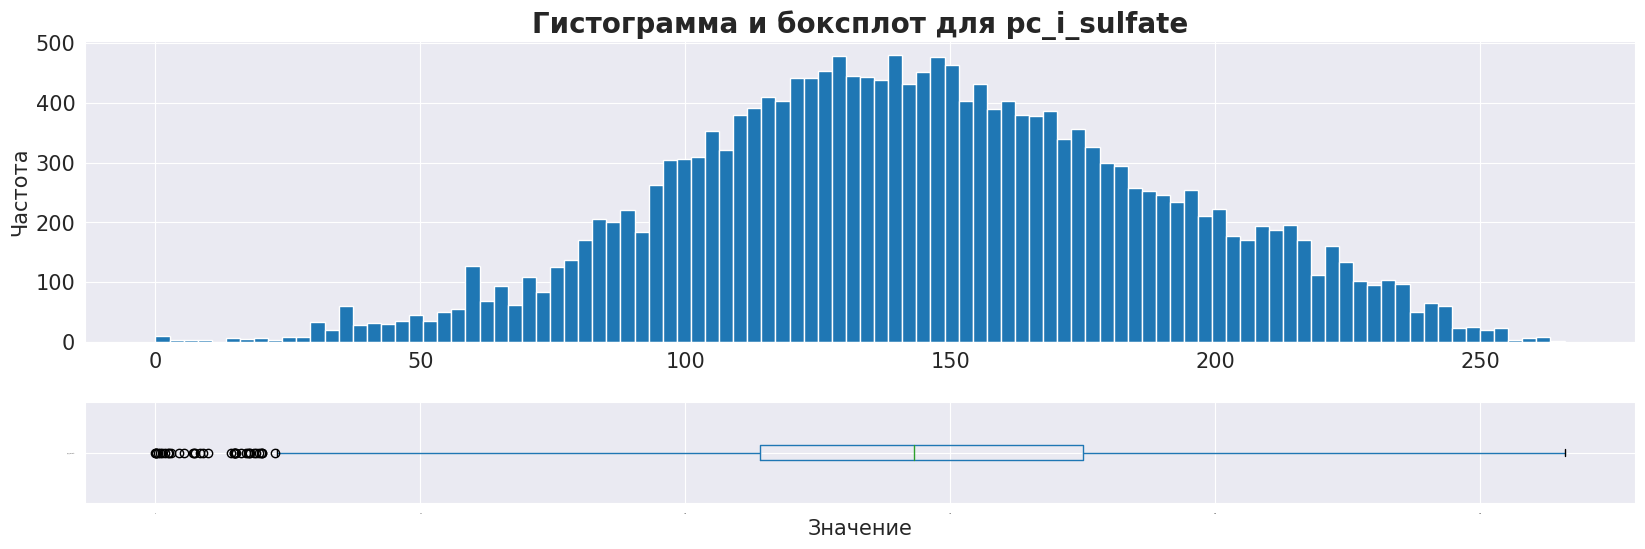

'Количество уникальных значений в столбце pc_i_sulfate: 19415'

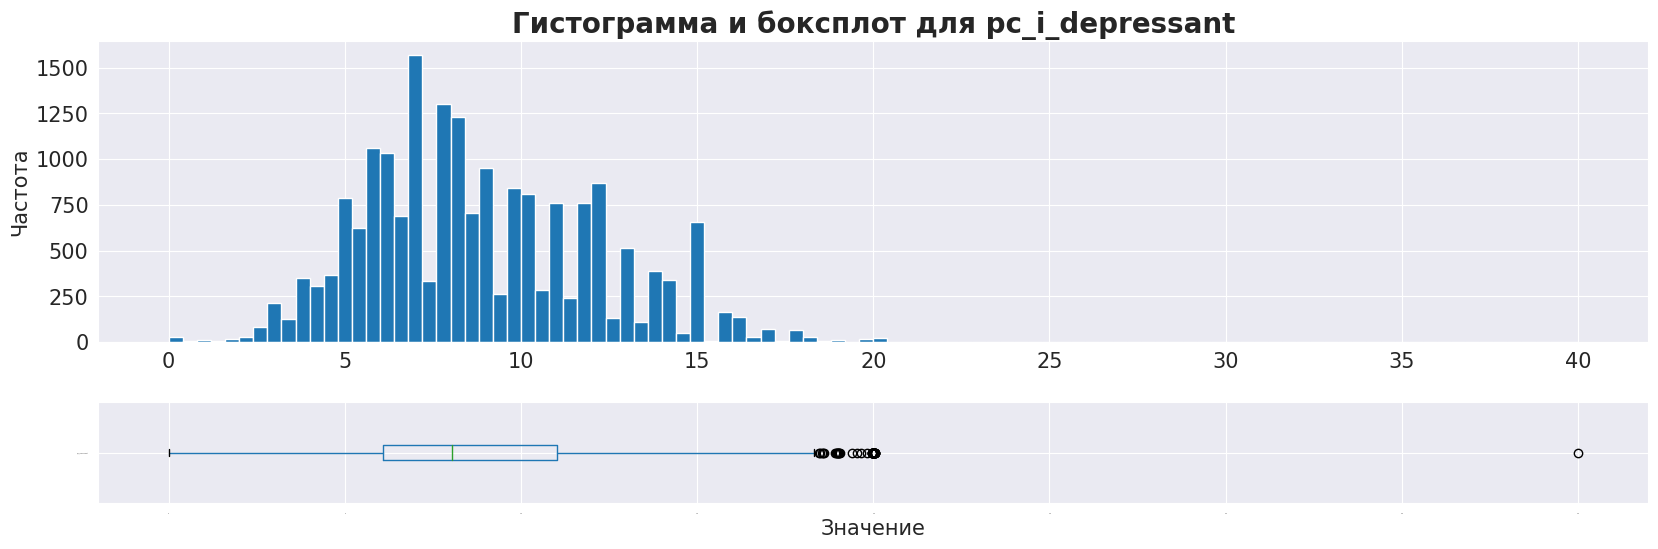

'Количество уникальных значений в столбце pc_i_depressant: 19393'

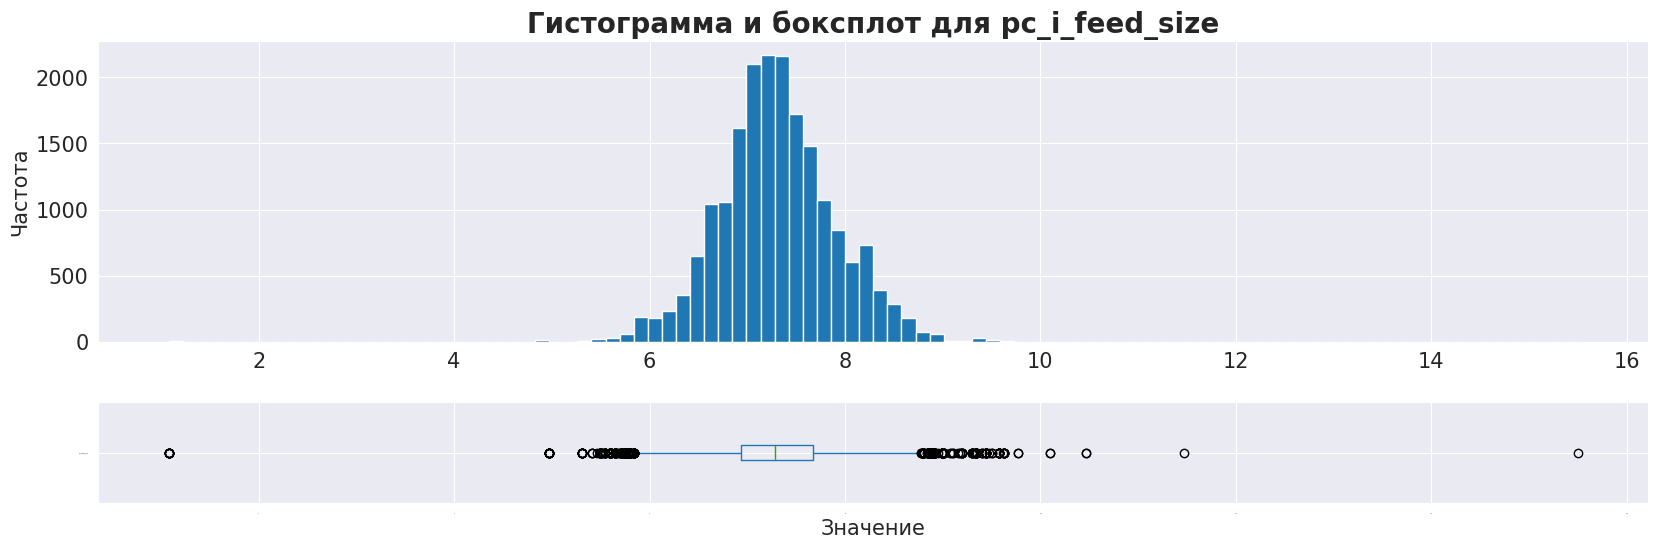

'Количество уникальных значений в столбце pc_i_feed_size: 5022'

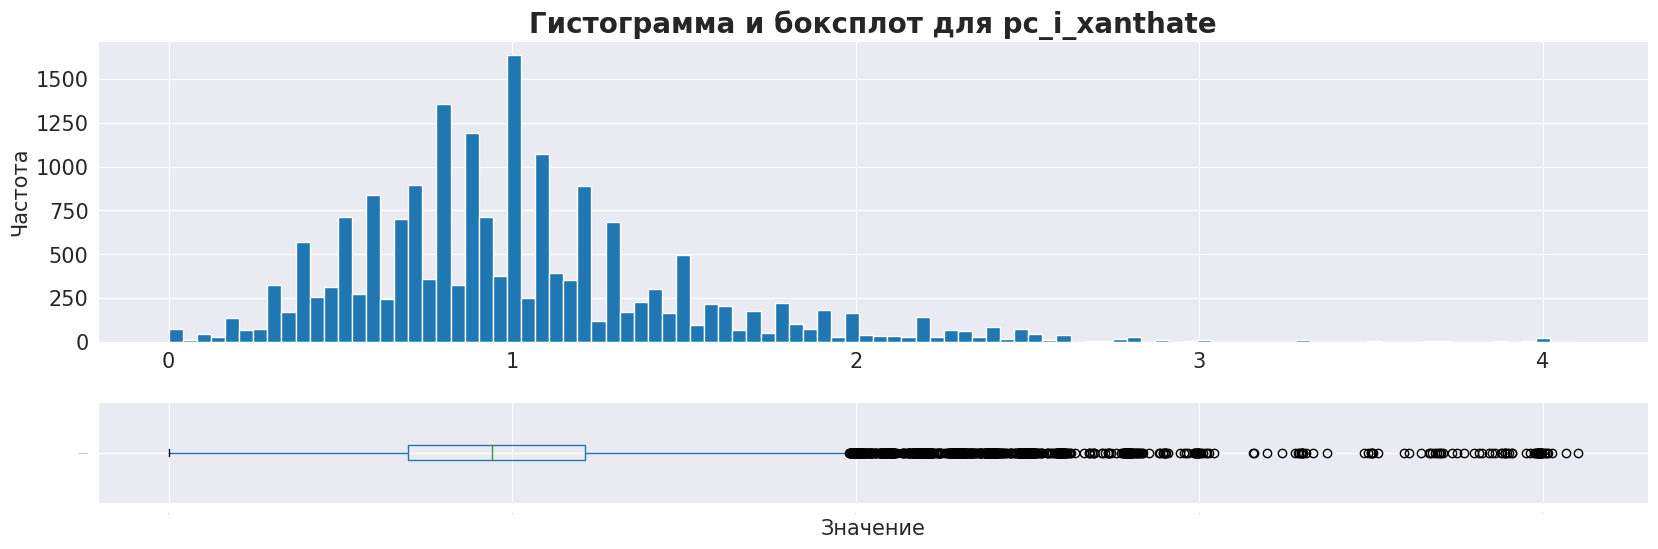

'Количество уникальных значений в столбце pc_i_xanthate: 19335'

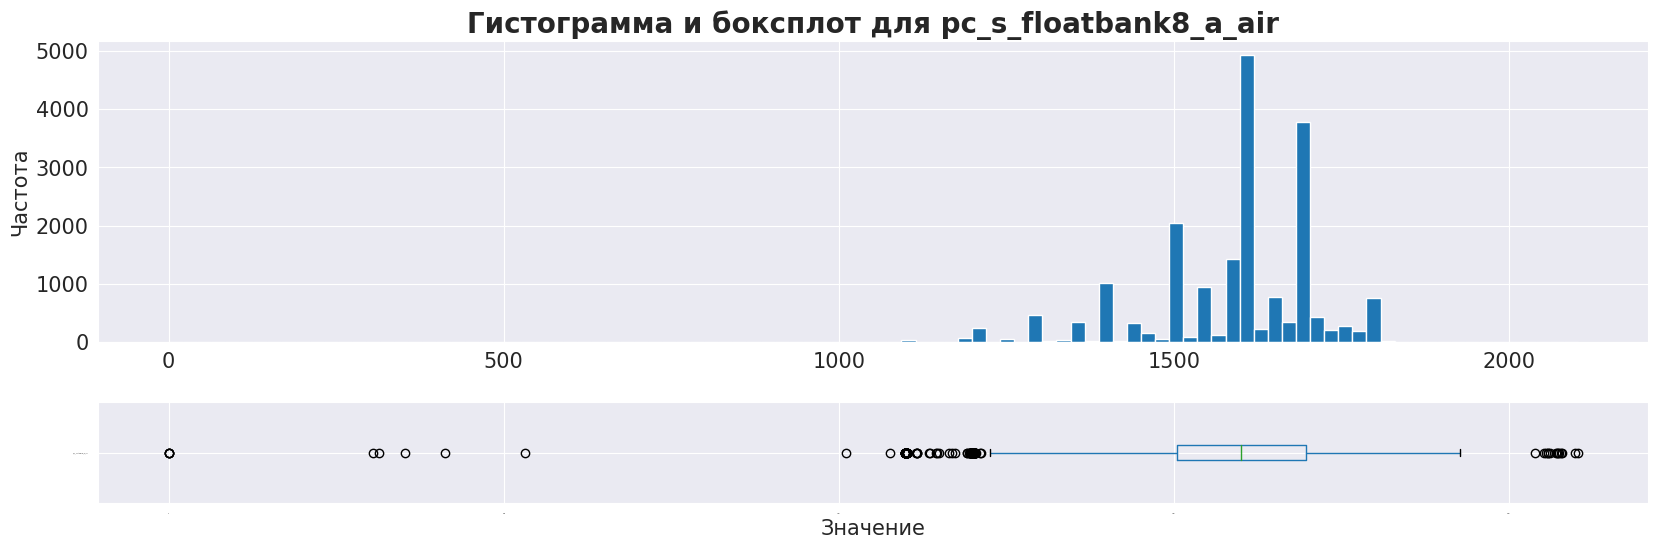

'Количество уникальных значений в столбце pc_s_floatbank8_a_air: 19435'

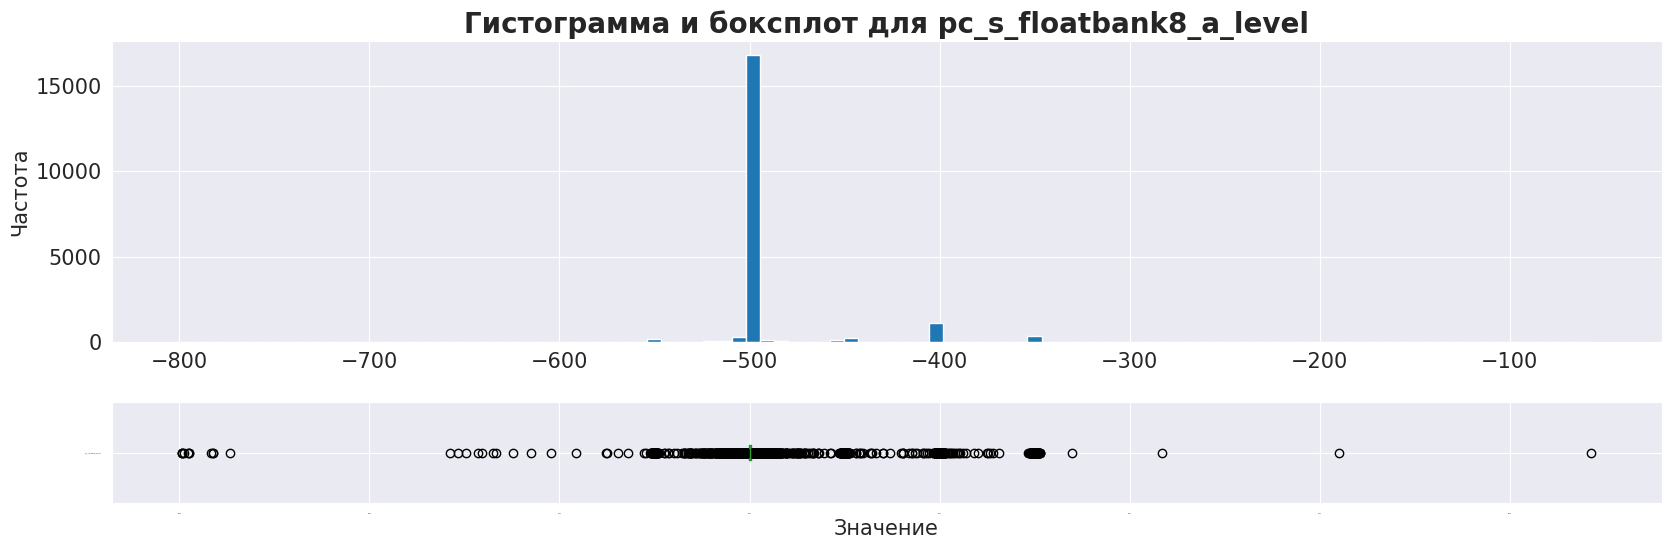

'Количество уникальных значений в столбце pc_s_floatbank8_a_level: 19438'

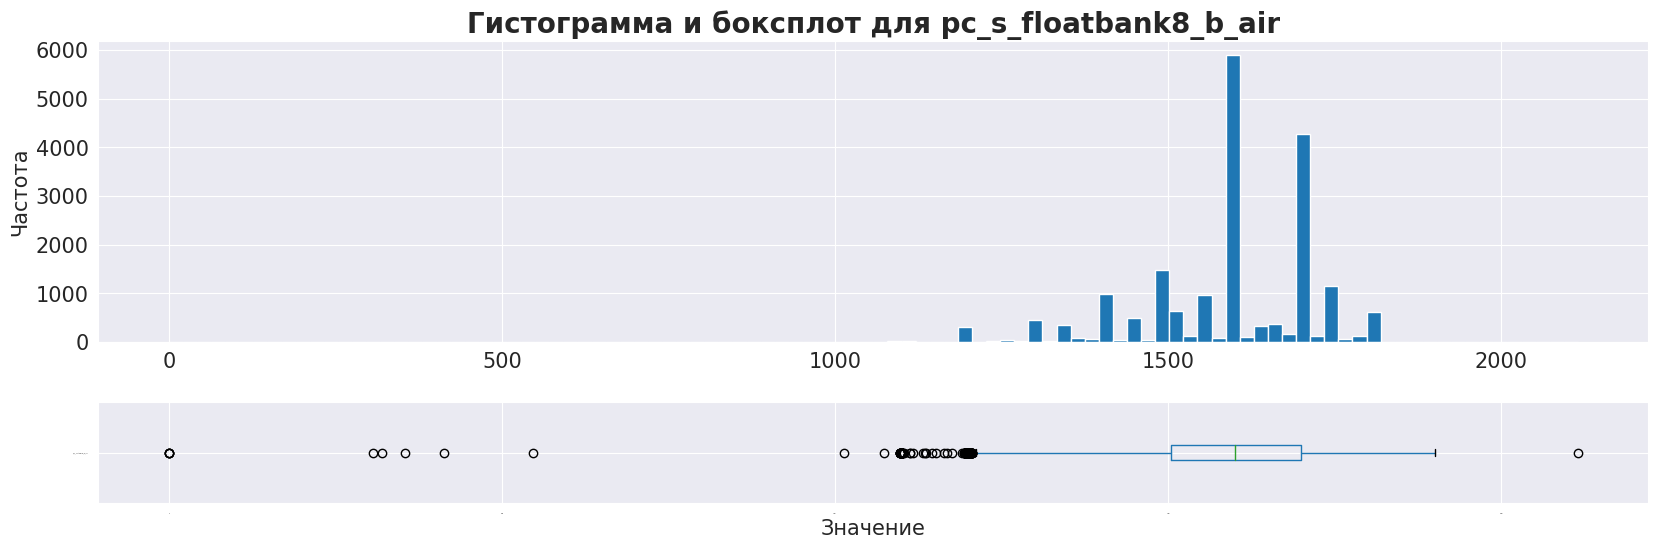

'Количество уникальных значений в столбце pc_s_floatbank8_b_air: 19435'

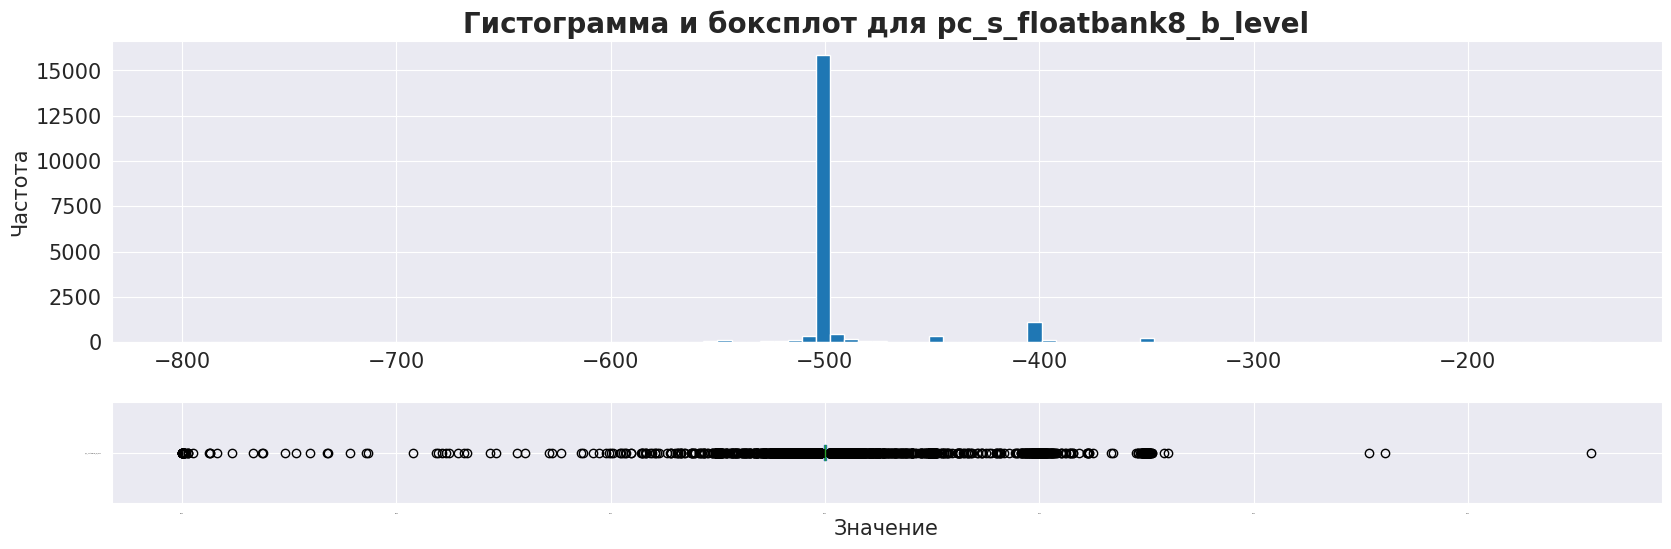

'Количество уникальных значений в столбце pc_s_floatbank8_b_level: 19438'

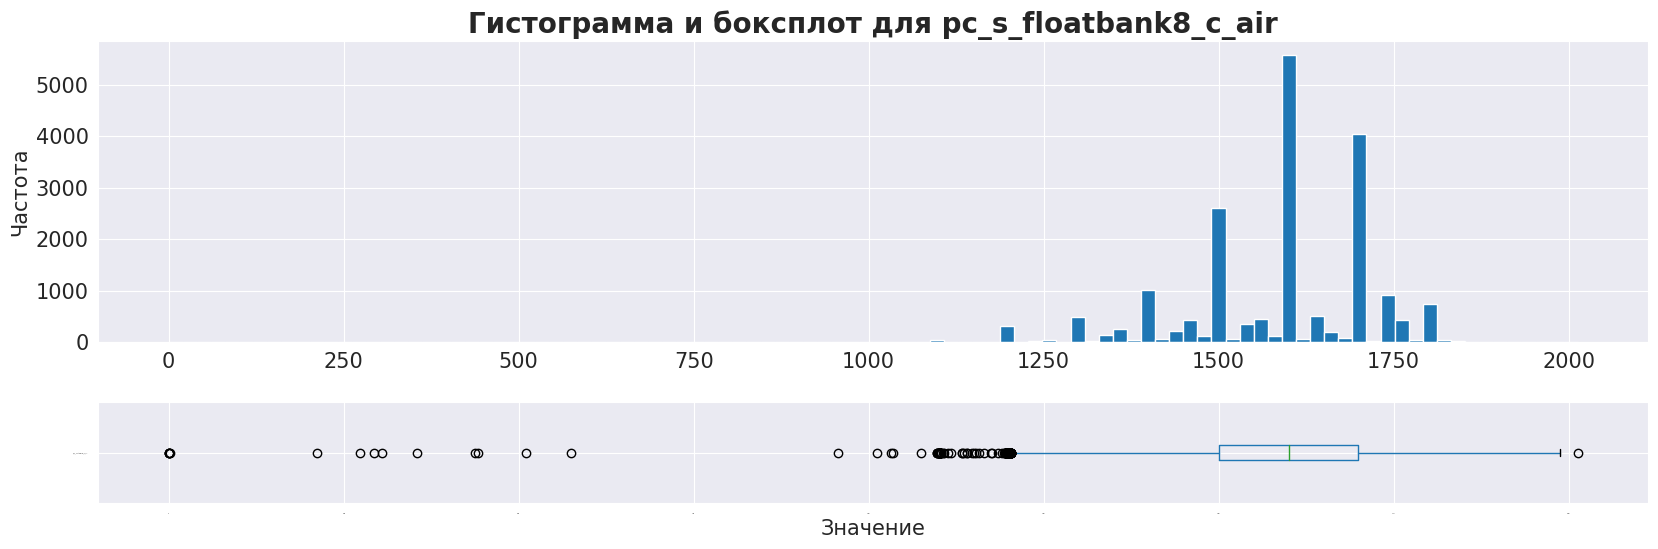

'Количество уникальных значений в столбце pc_s_floatbank8_c_air: 19437'

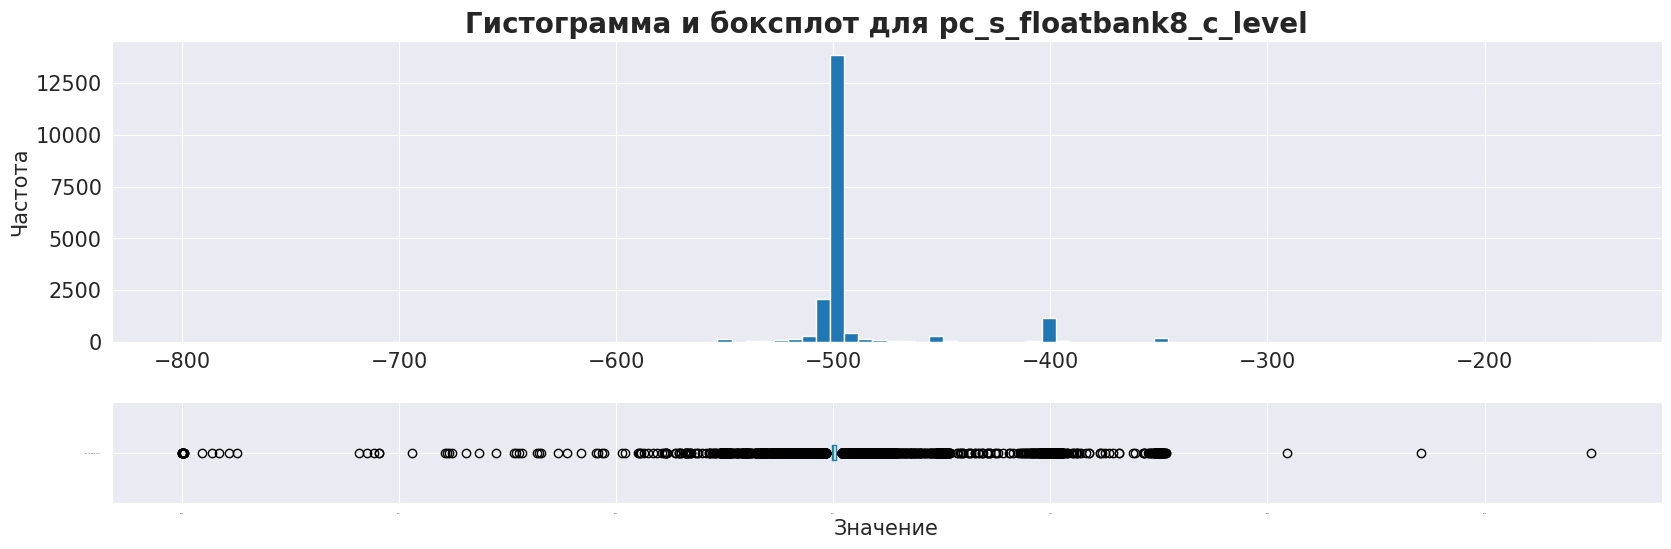

'Количество уникальных значений в столбце pc_s_floatbank8_c_level: 19438'

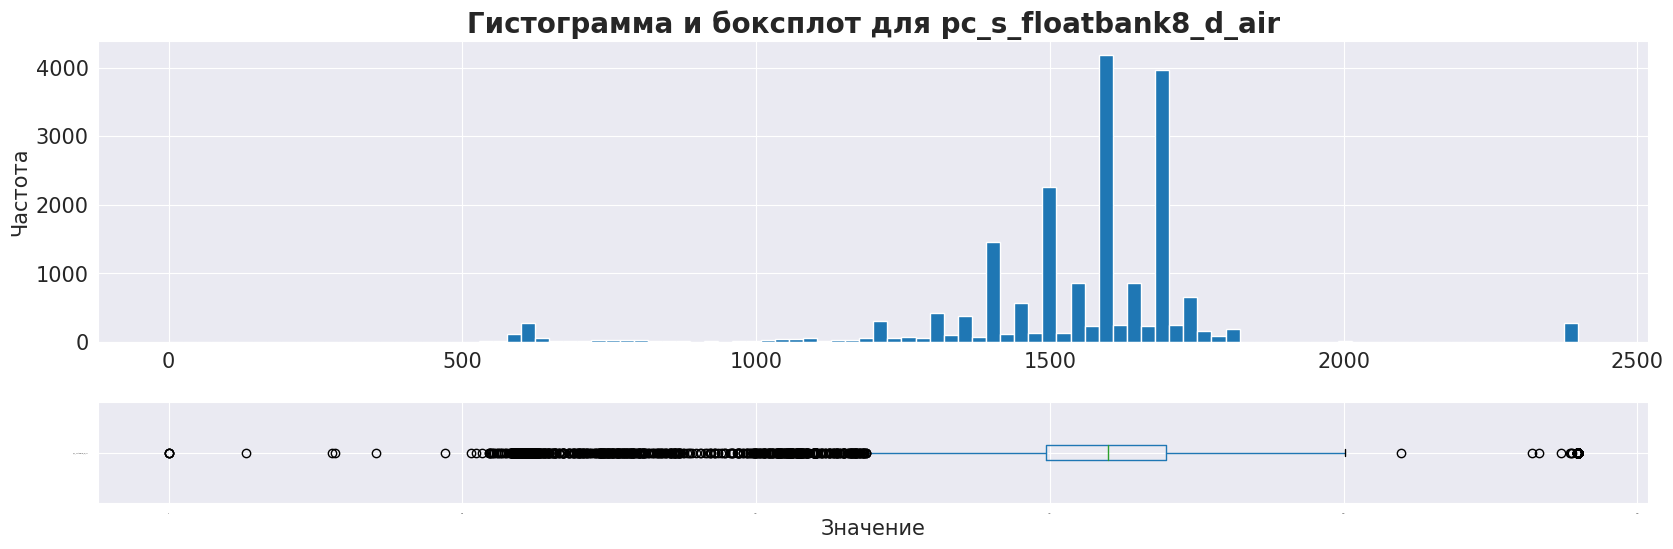

'Количество уникальных значений в столбце pc_s_floatbank8_d_air: 19436'

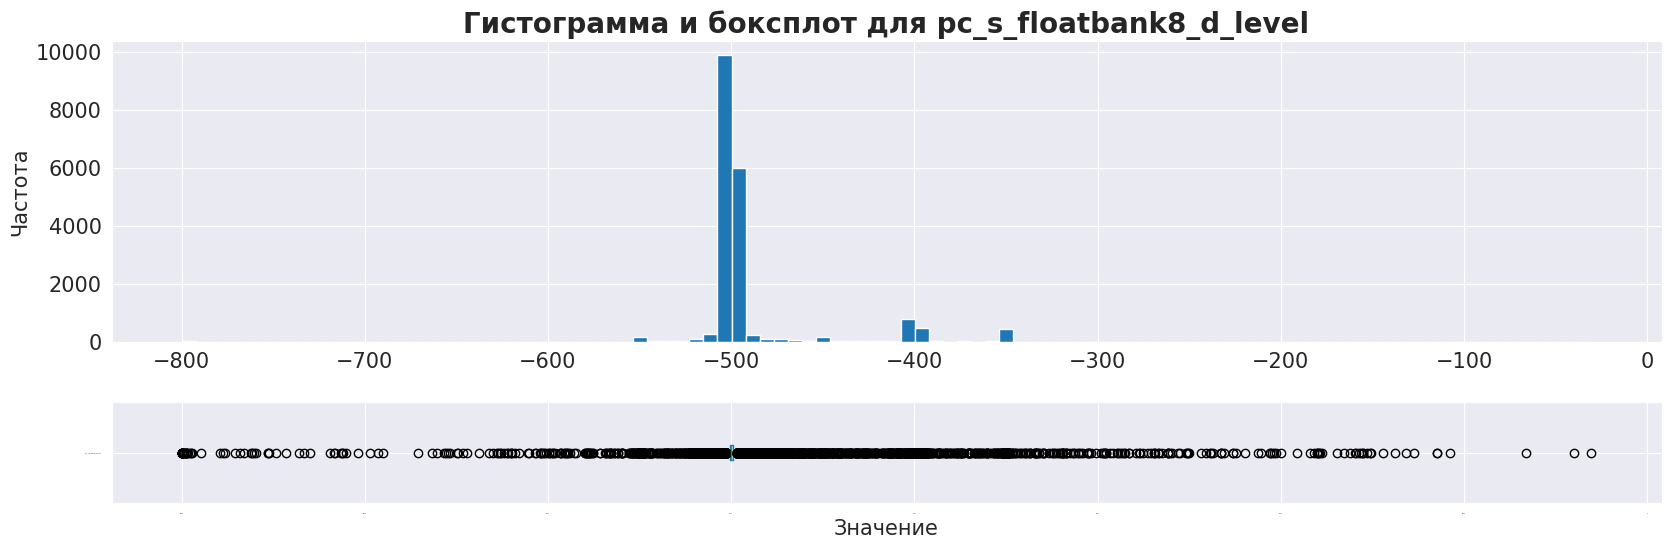

'Количество уникальных значений в столбце pc_s_floatbank8_d_level: 19438'

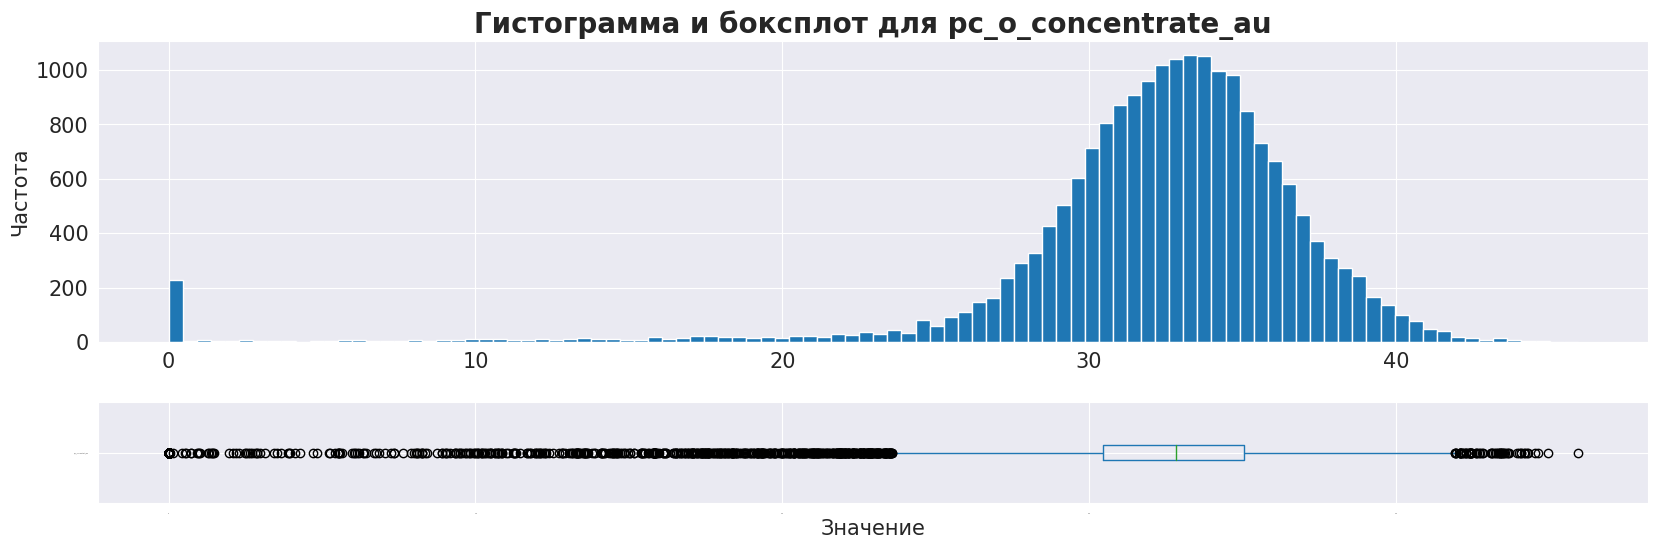

'Количество уникальных значений в столбце pc_o_concentrate_au: 19199'

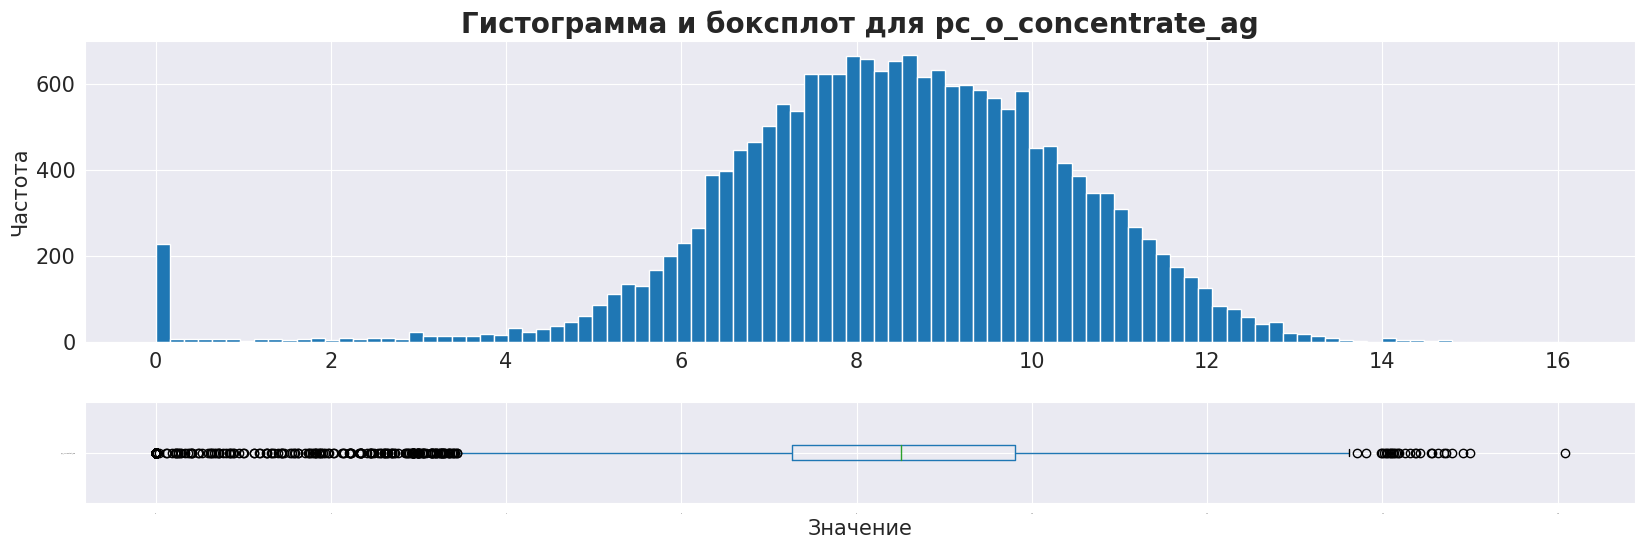

'Количество уникальных значений в столбце pc_o_concentrate_ag: 19199'

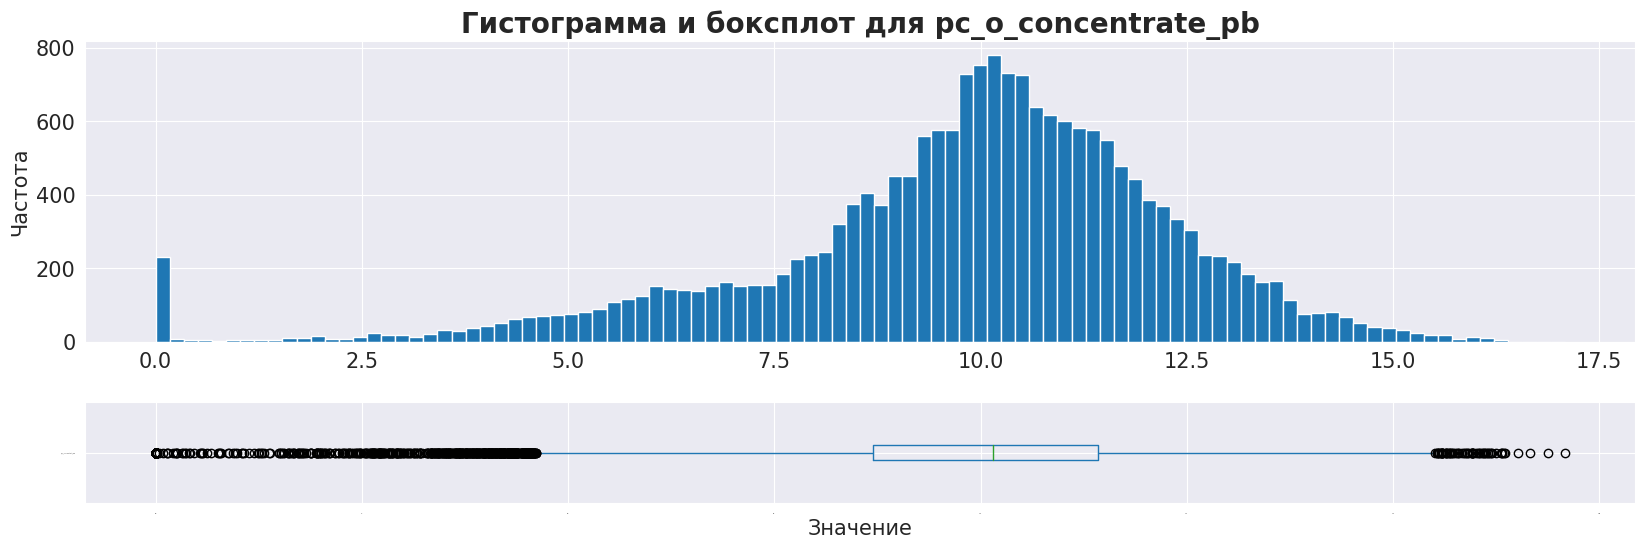

'Количество уникальных значений в столбце pc_o_concentrate_pb: 19055'

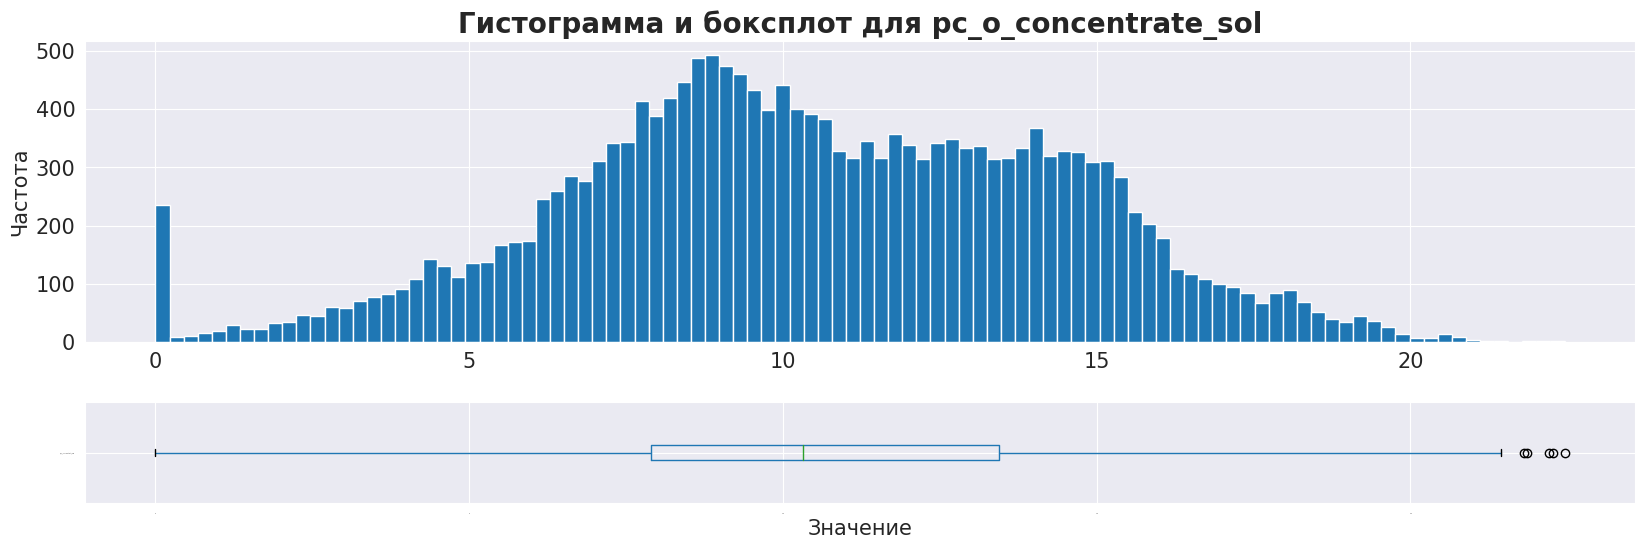

'Количество уникальных значений в столбце pc_o_concentrate_sol: 18826'

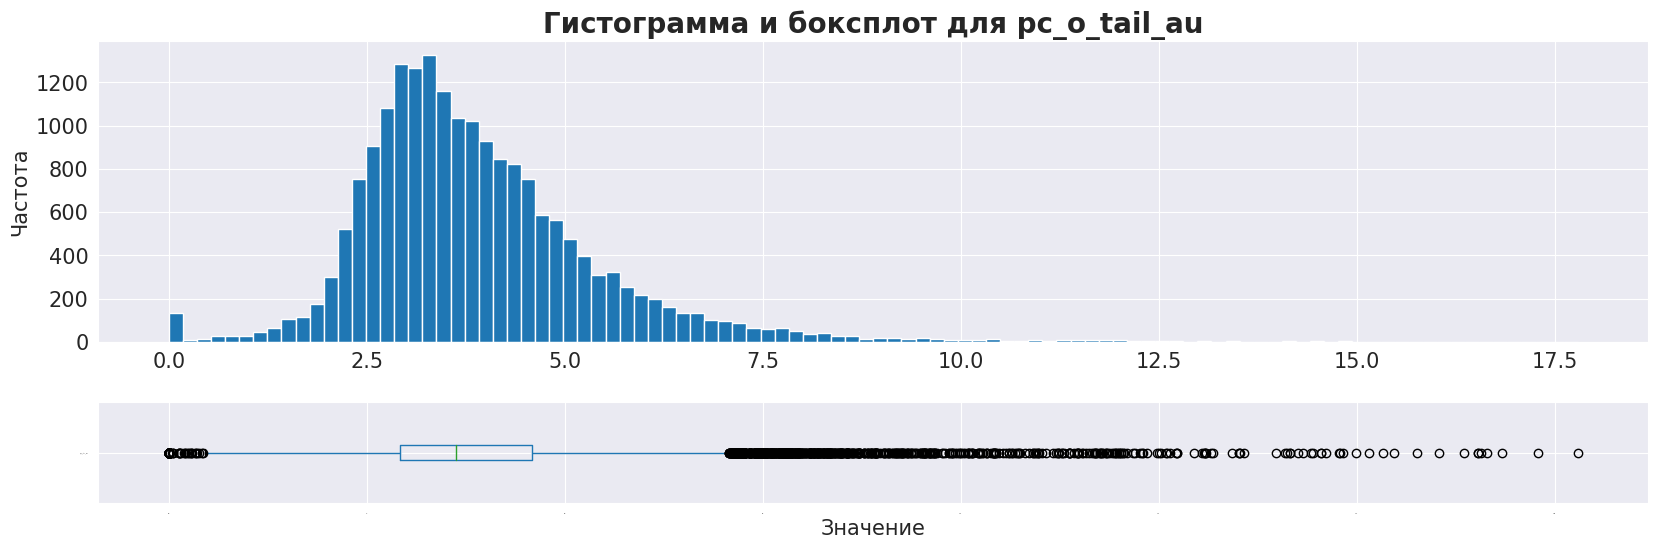

'Количество уникальных значений в столбце pc_o_tail_au: 19291'

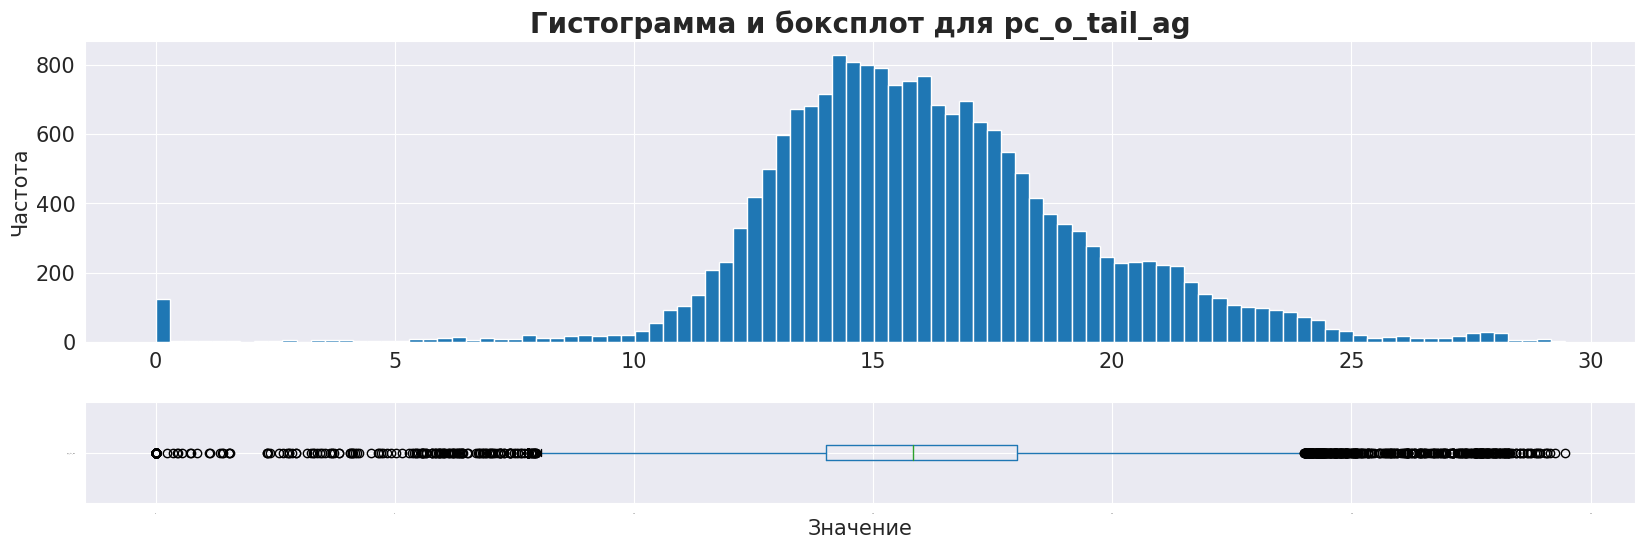

'Количество уникальных значений в столбце pc_o_tail_ag: 19287'

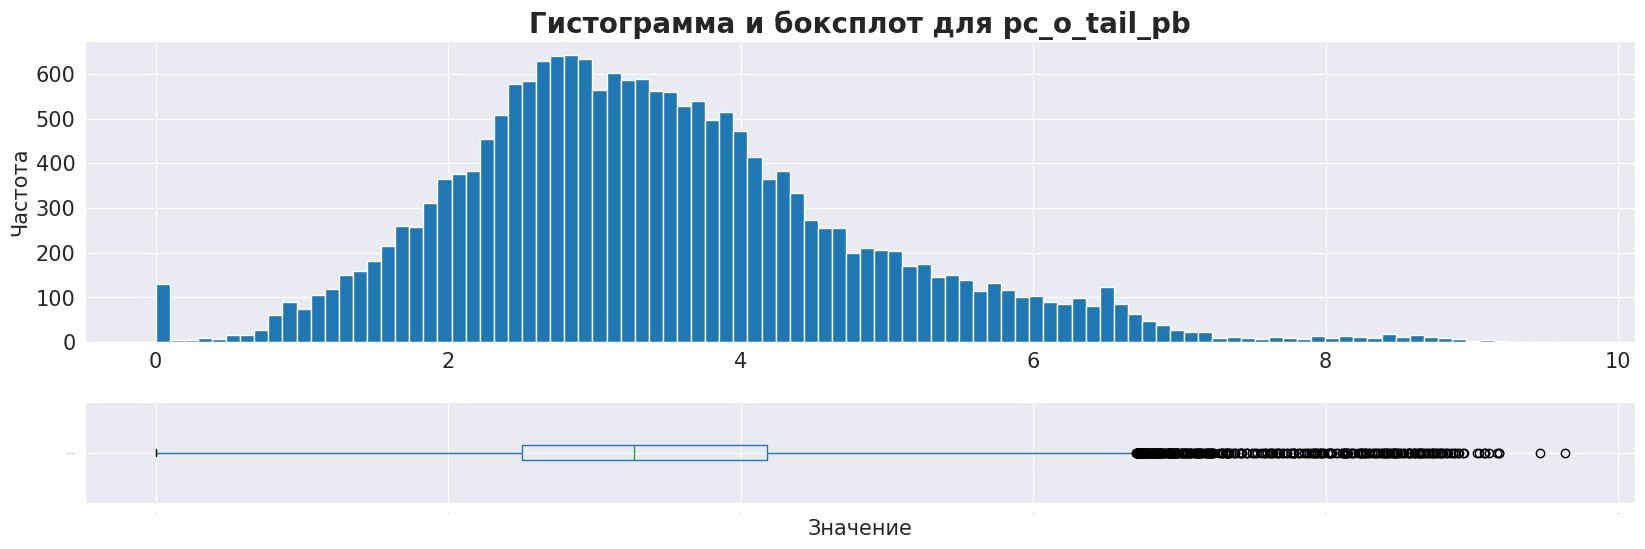

'Количество уникальных значений в столбце pc_o_tail_pb: 19270'

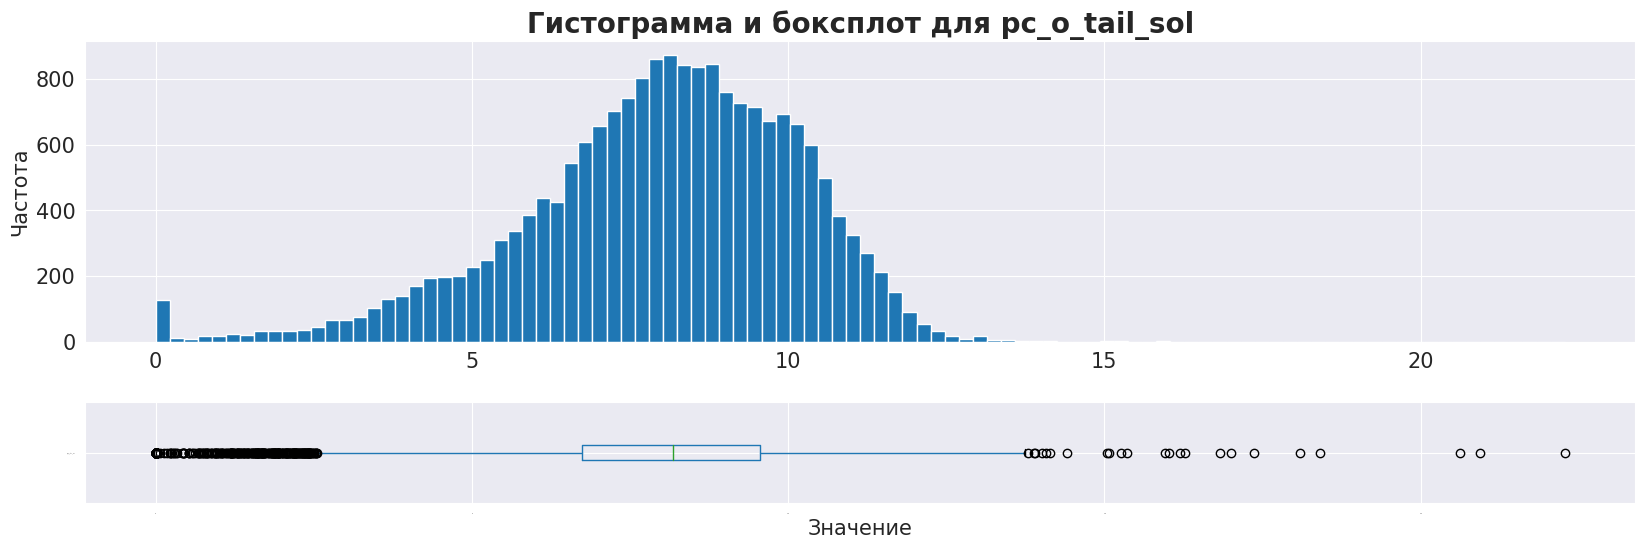

'Количество уникальных значений в столбце pc_o_tail_sol: 19229'

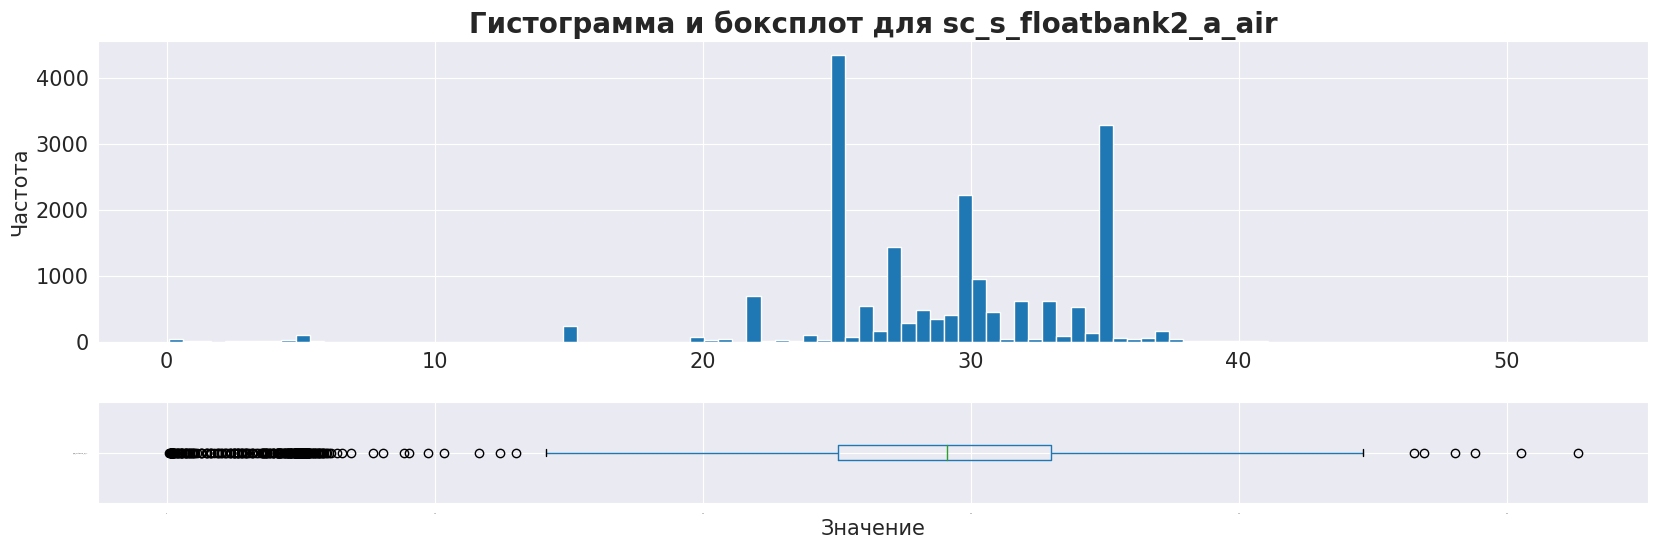

'Количество уникальных значений в столбце sc_s_floatbank2_a_air: 19218'

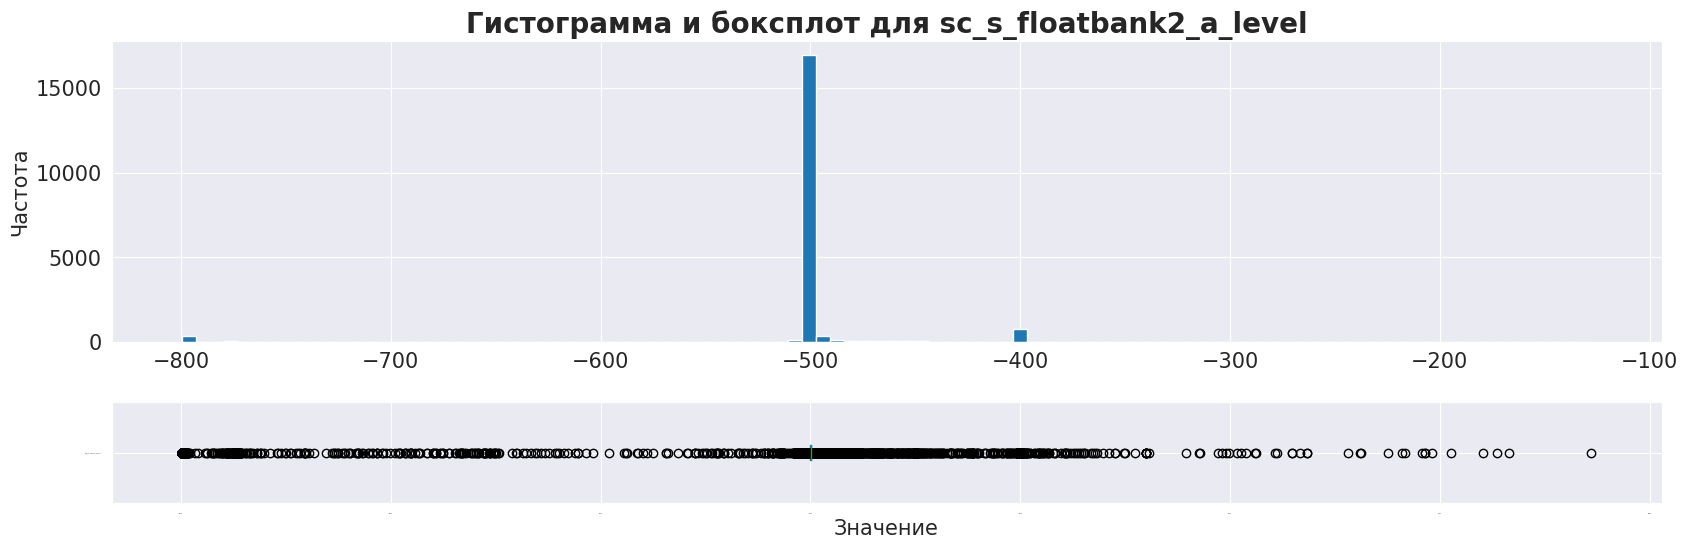

'Количество уникальных значений в столбце sc_s_floatbank2_a_level: 19438'

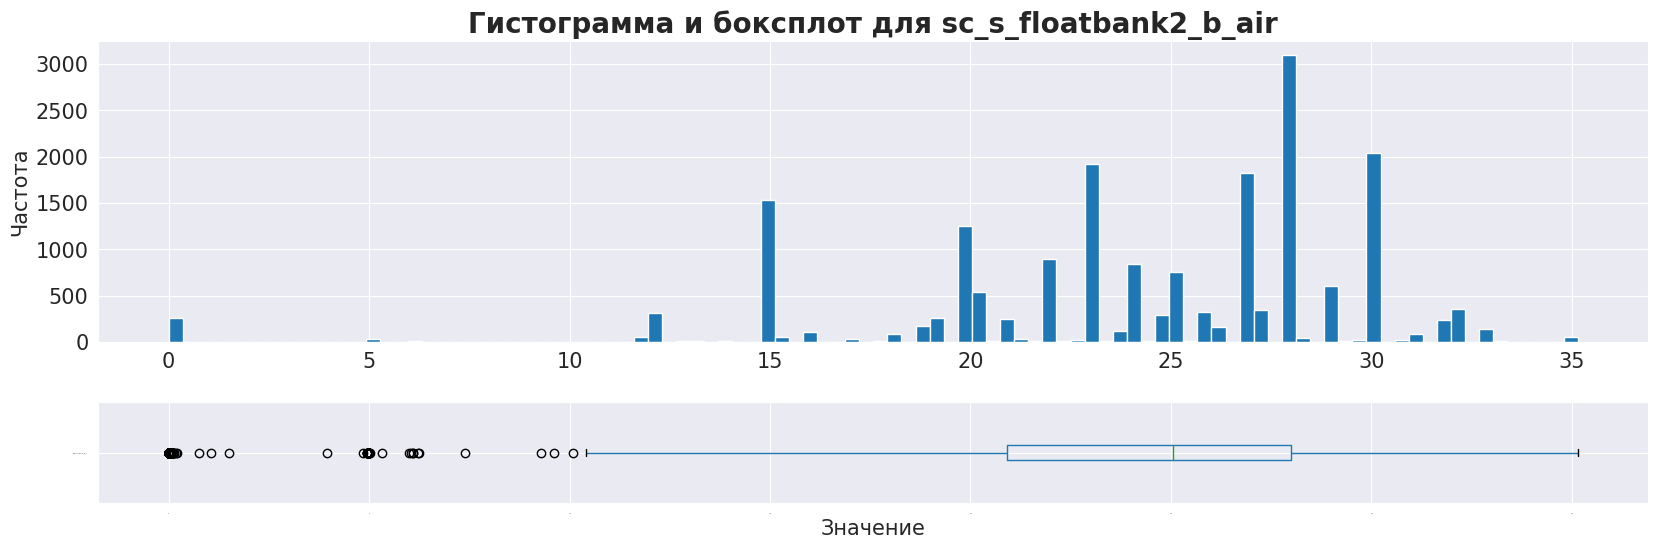

'Количество уникальных значений в столбце sc_s_floatbank2_b_air: 19281'

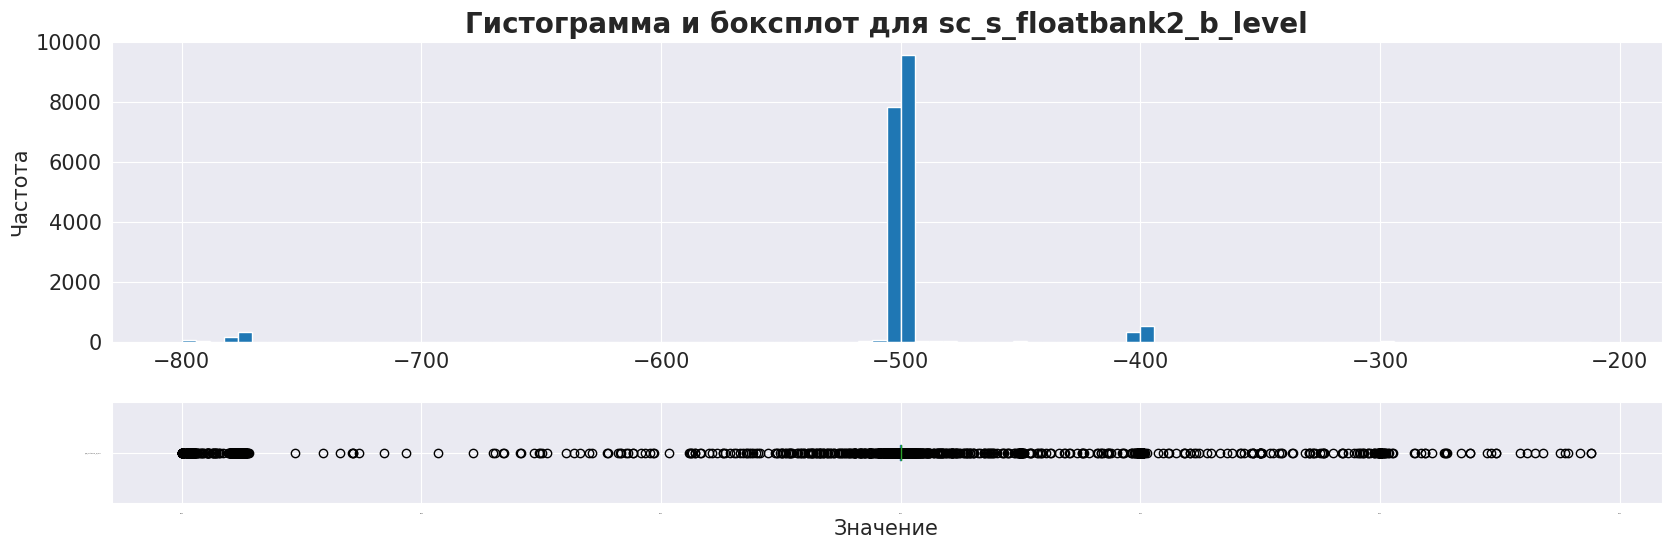

'Количество уникальных значений в столбце sc_s_floatbank2_b_level: 19438'

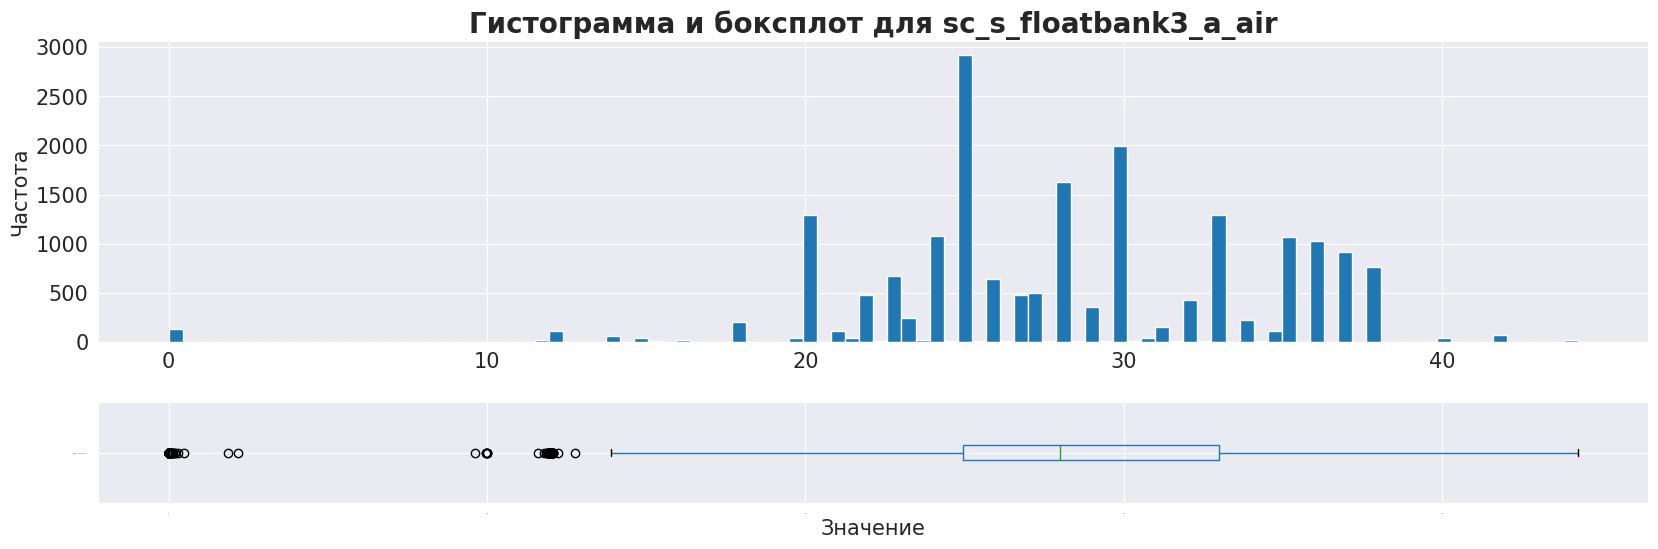

'Количество уникальных значений в столбце sc_s_floatbank3_a_air: 19353'

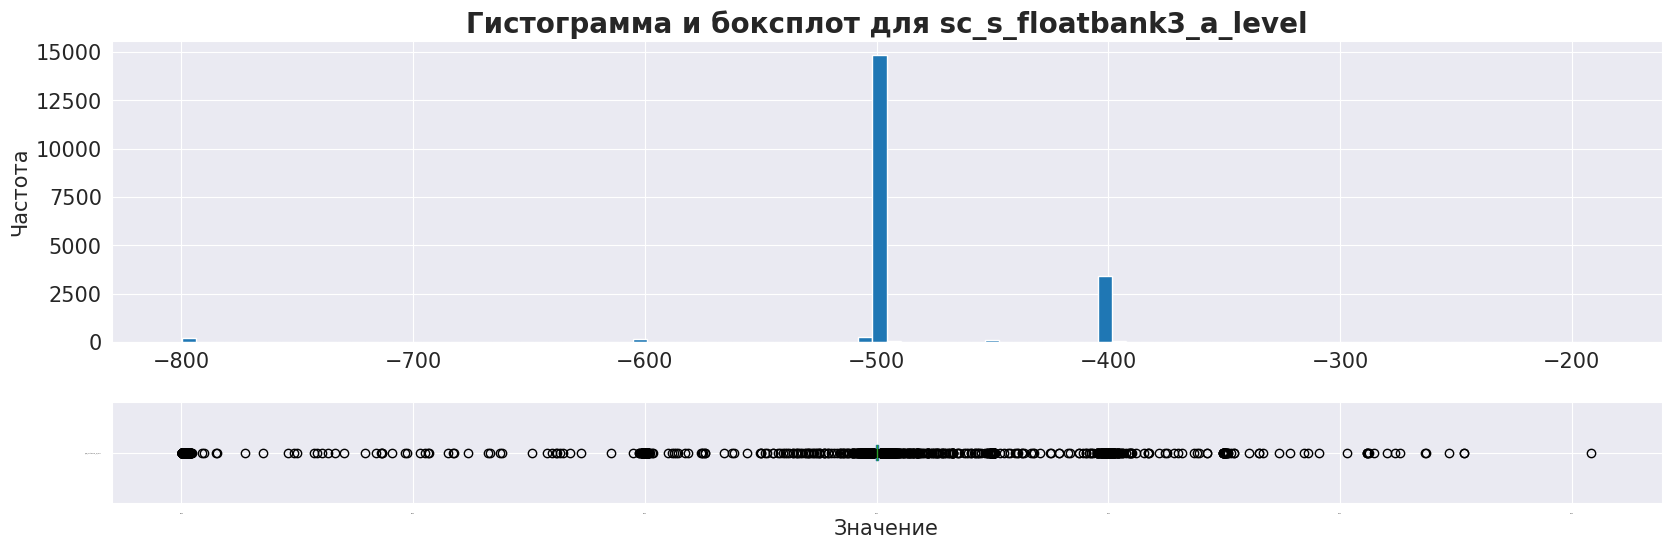

'Количество уникальных значений в столбце sc_s_floatbank3_a_level: 19438'

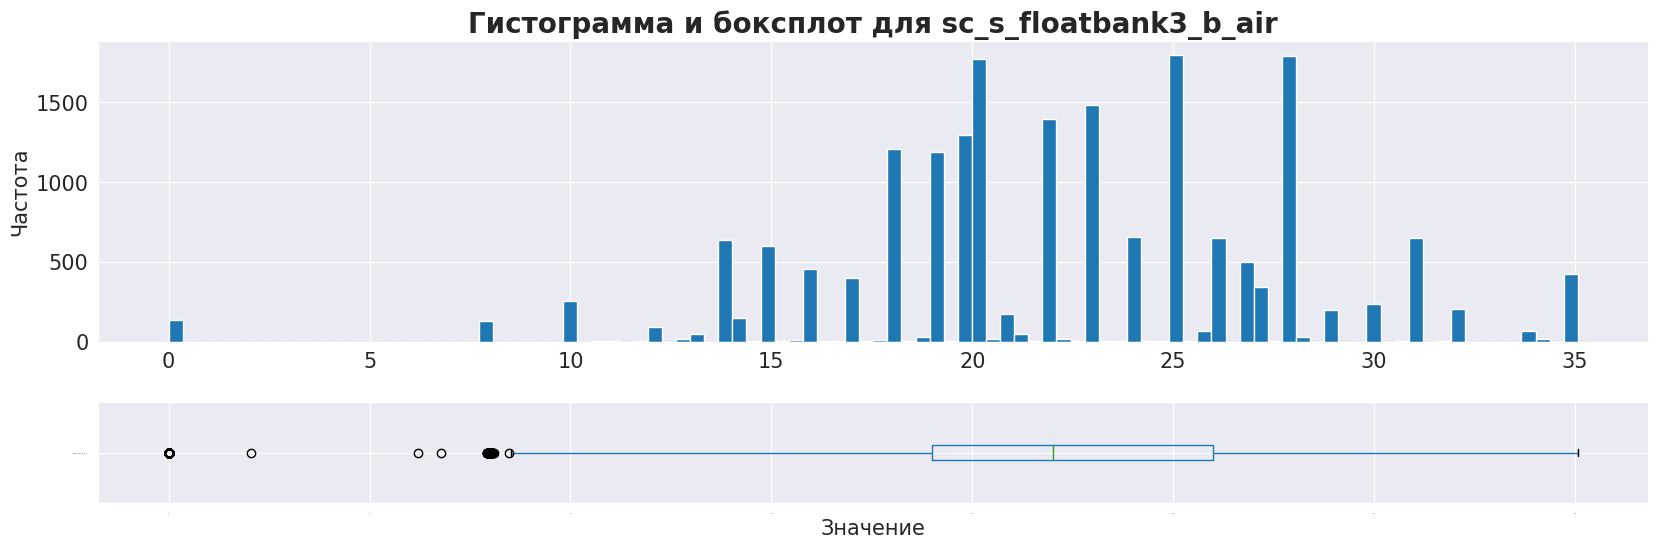

'Количество уникальных значений в столбце sc_s_floatbank3_b_air: 19318'

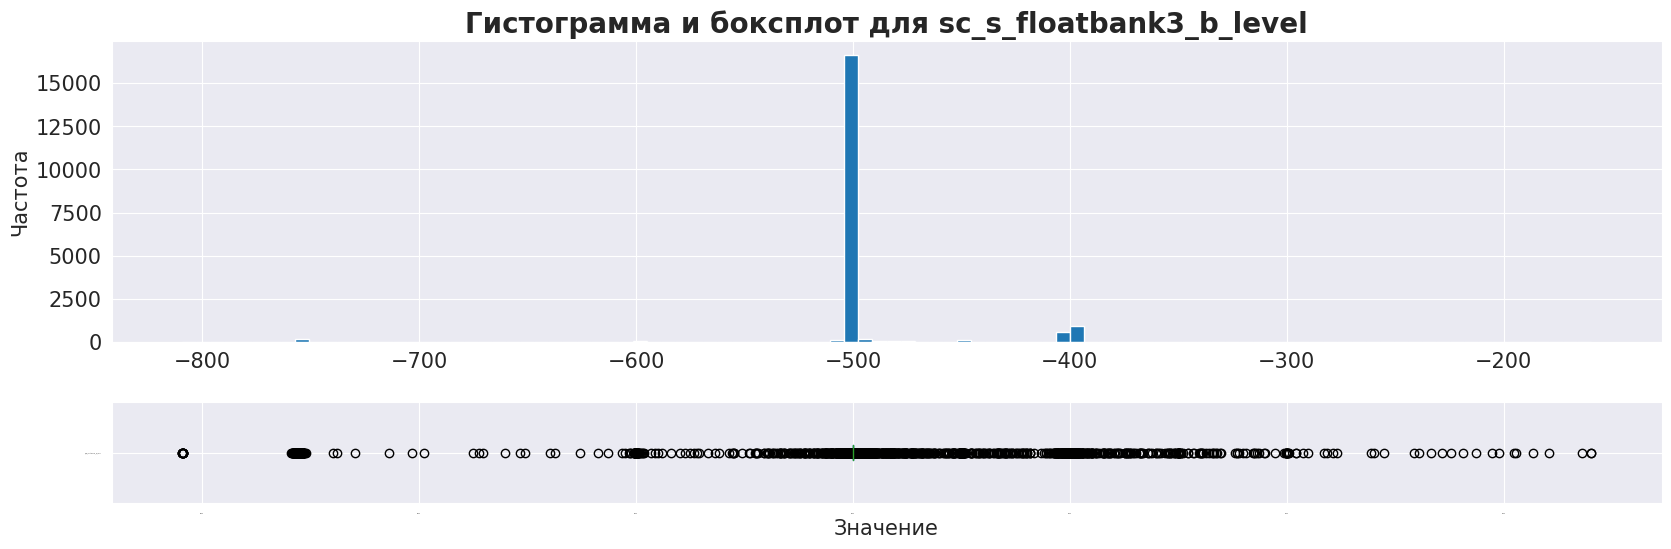

'Количество уникальных значений в столбце sc_s_floatbank3_b_level: 19438'

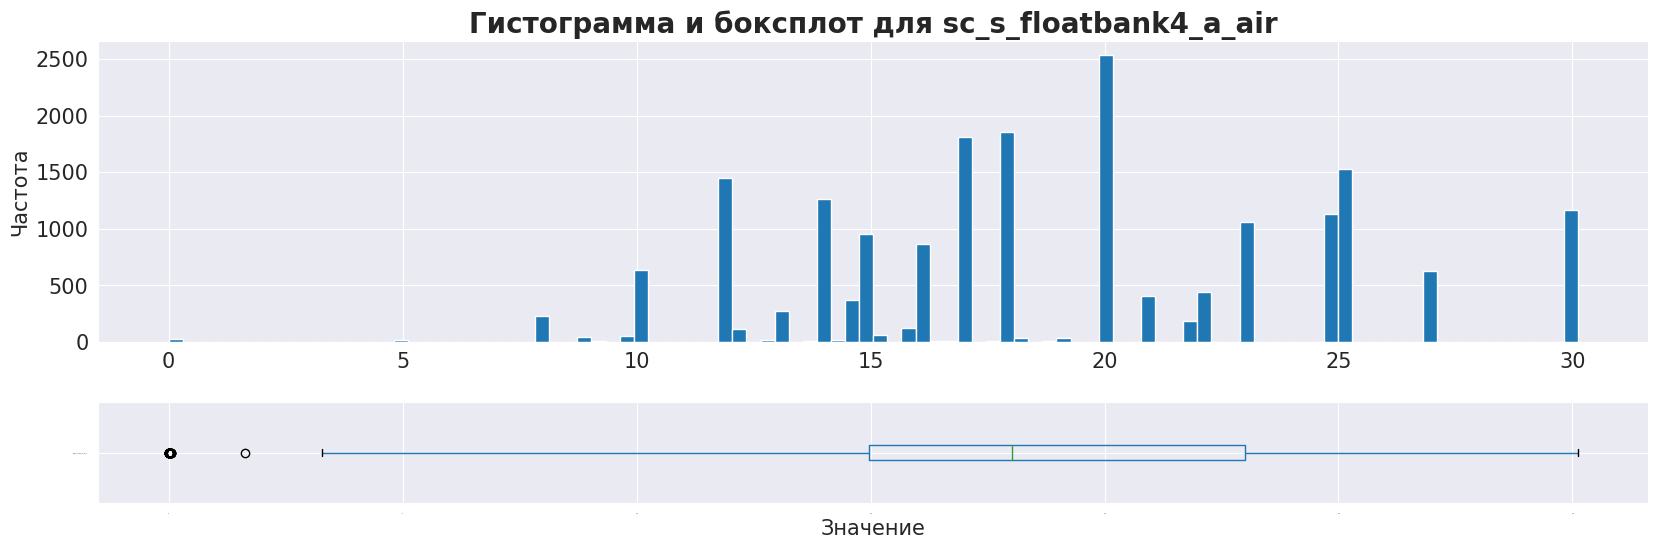

'Количество уникальных значений в столбце sc_s_floatbank4_a_air: 19423'

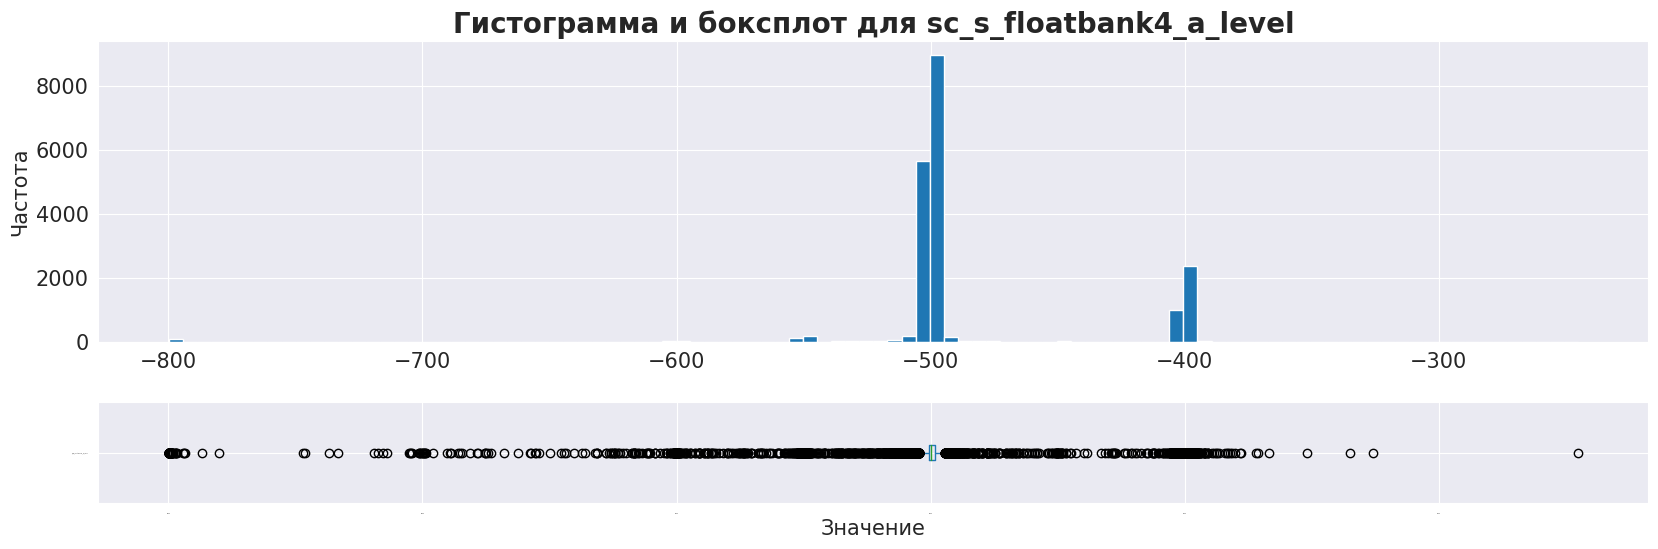

'Количество уникальных значений в столбце sc_s_floatbank4_a_level: 19438'

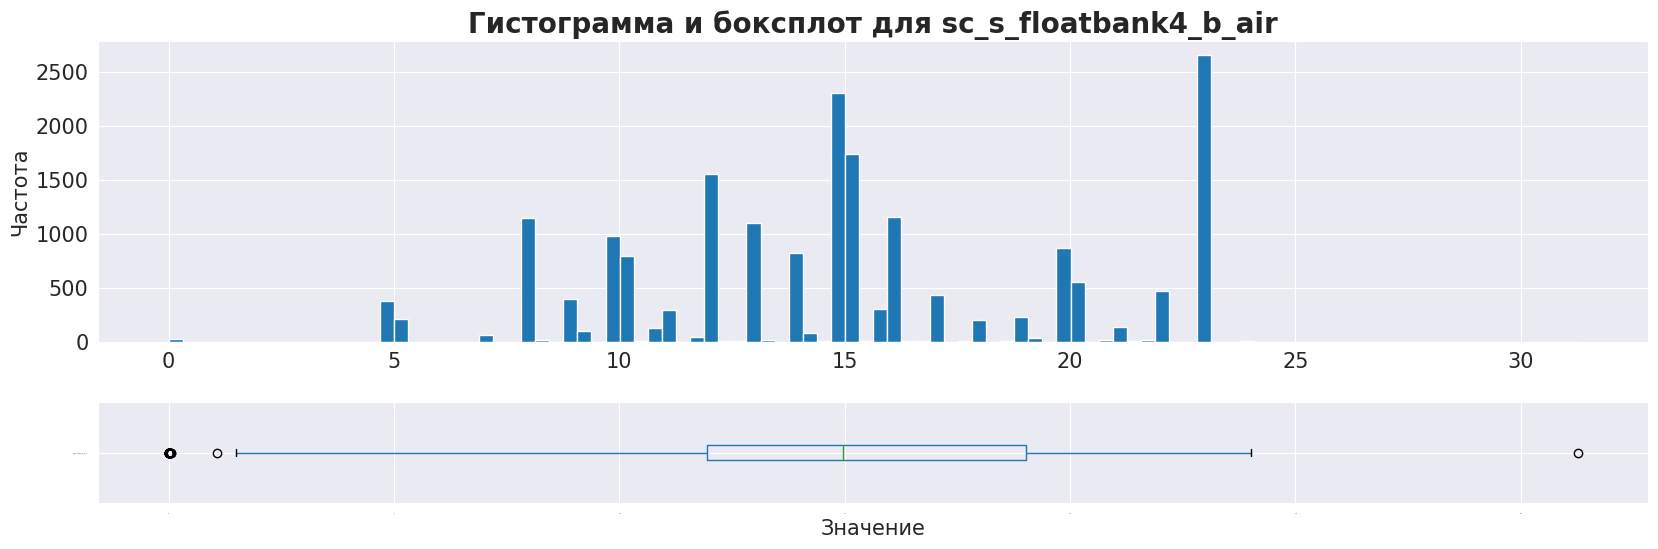

'Количество уникальных значений в столбце sc_s_floatbank4_b_air: 19414'

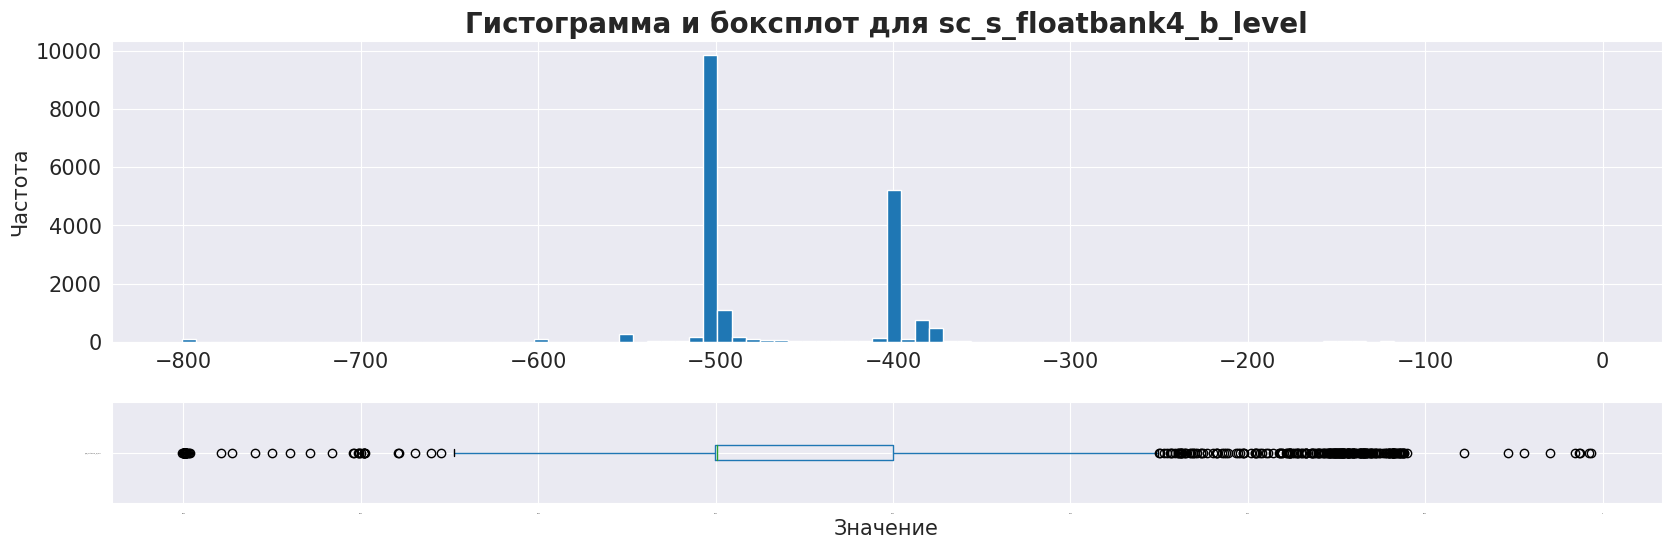

'Количество уникальных значений в столбце sc_s_floatbank4_b_level: 19436'

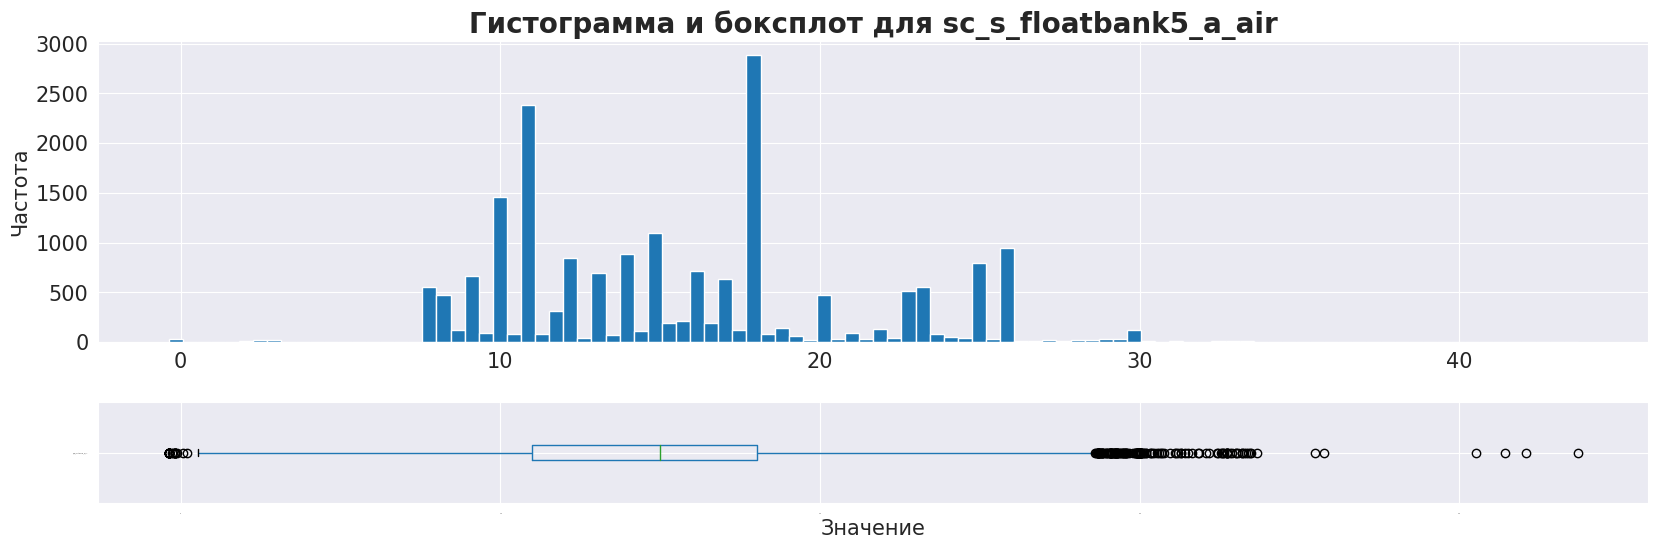

'Количество уникальных значений в столбце sc_s_floatbank5_a_air: 19438'

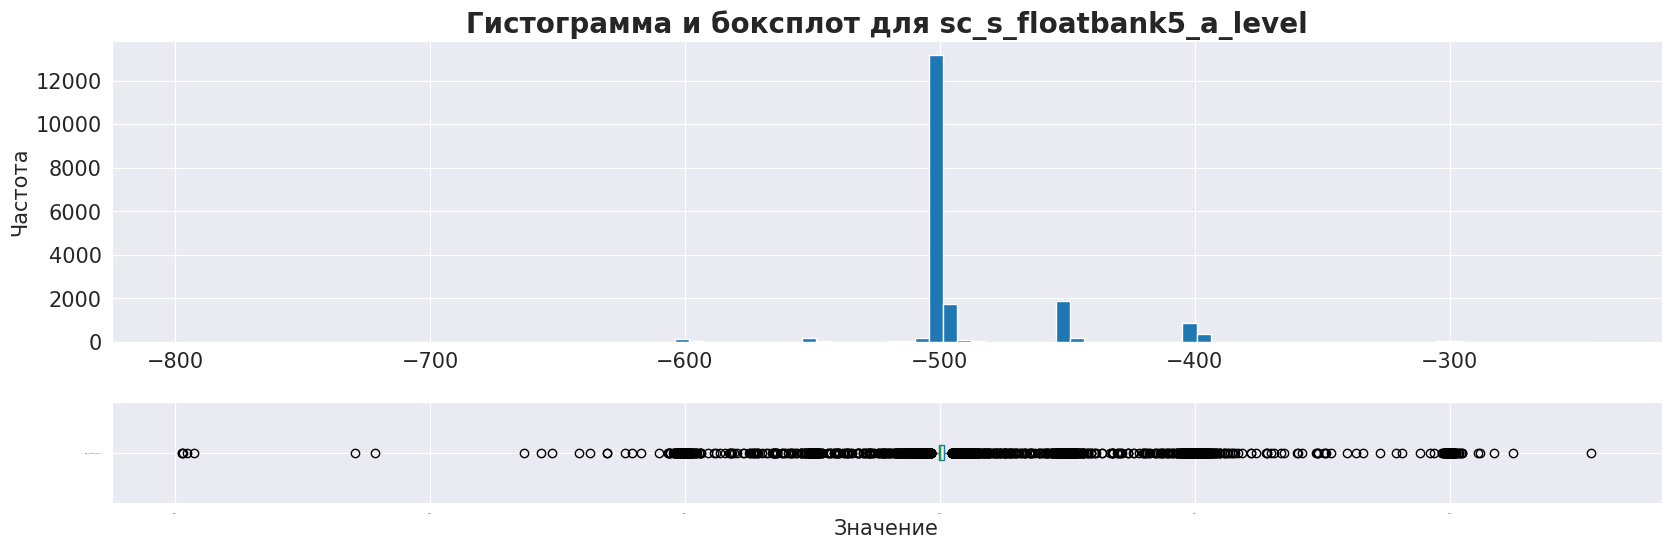

'Количество уникальных значений в столбце sc_s_floatbank5_a_level: 19438'

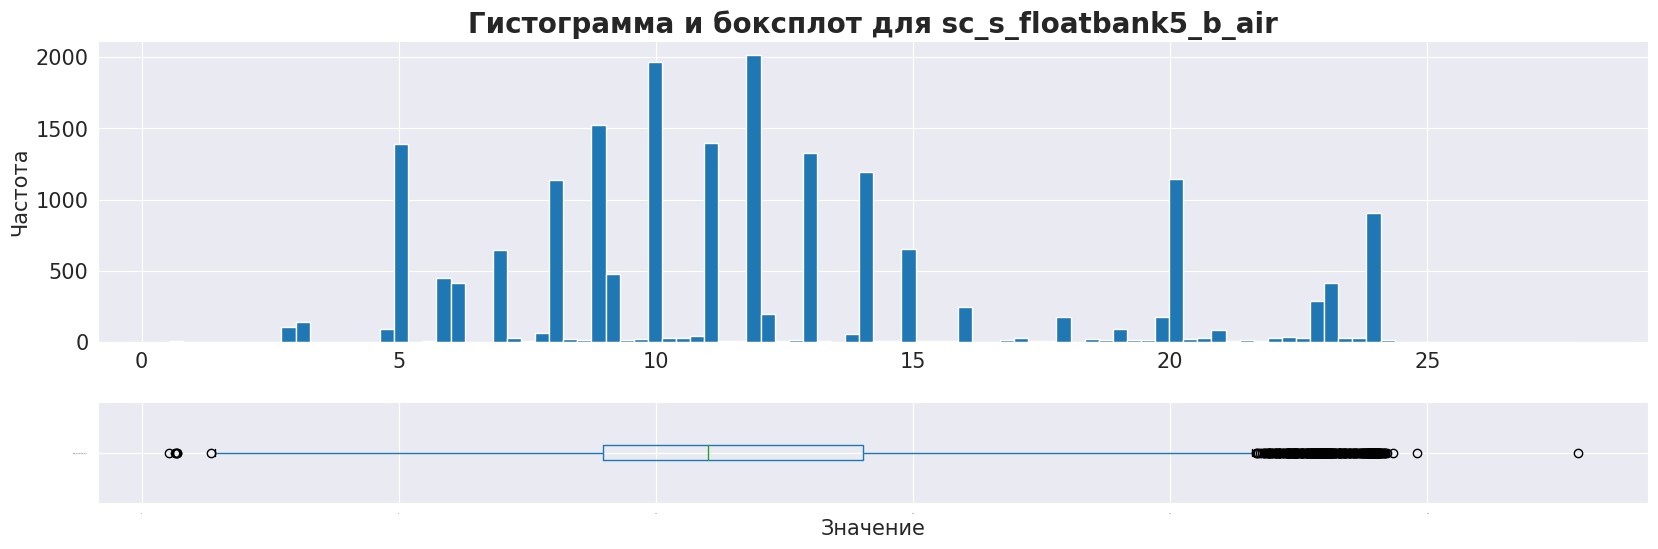

'Количество уникальных значений в столбце sc_s_floatbank5_b_air: 19438'

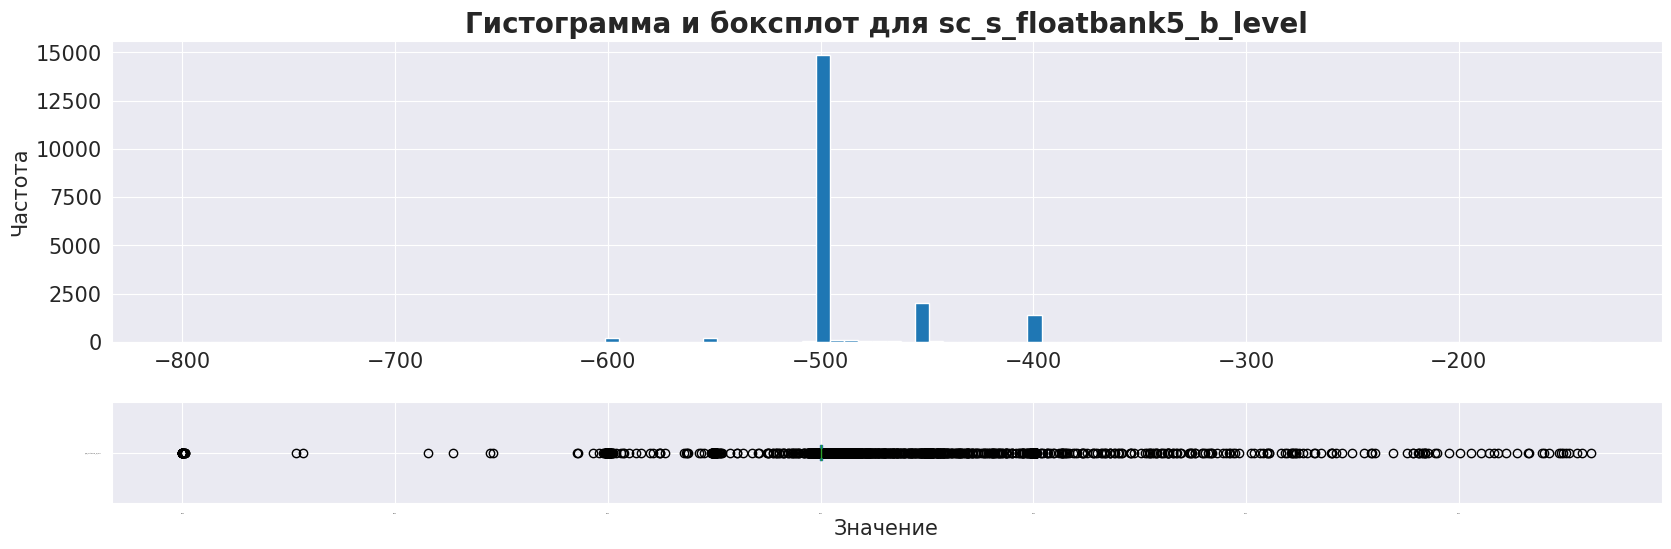

'Количество уникальных значений в столбце sc_s_floatbank5_b_level: 19438'

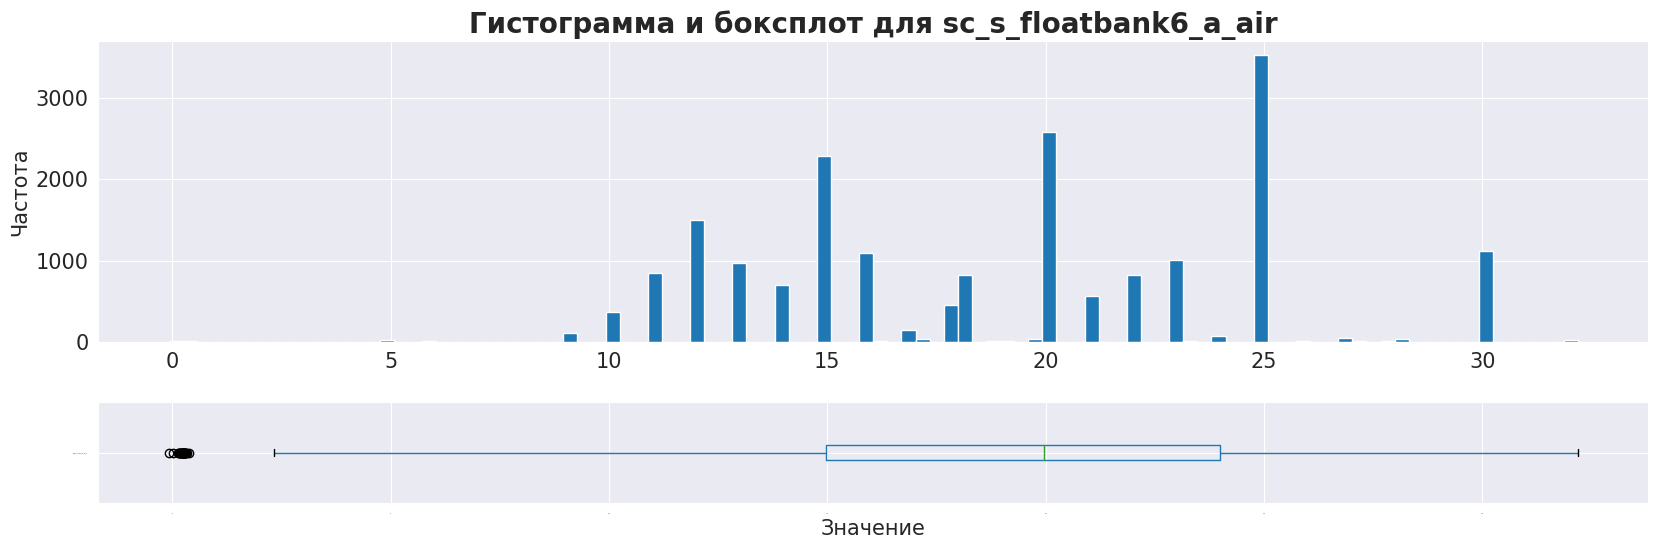

'Количество уникальных значений в столбце sc_s_floatbank6_a_air: 19437'

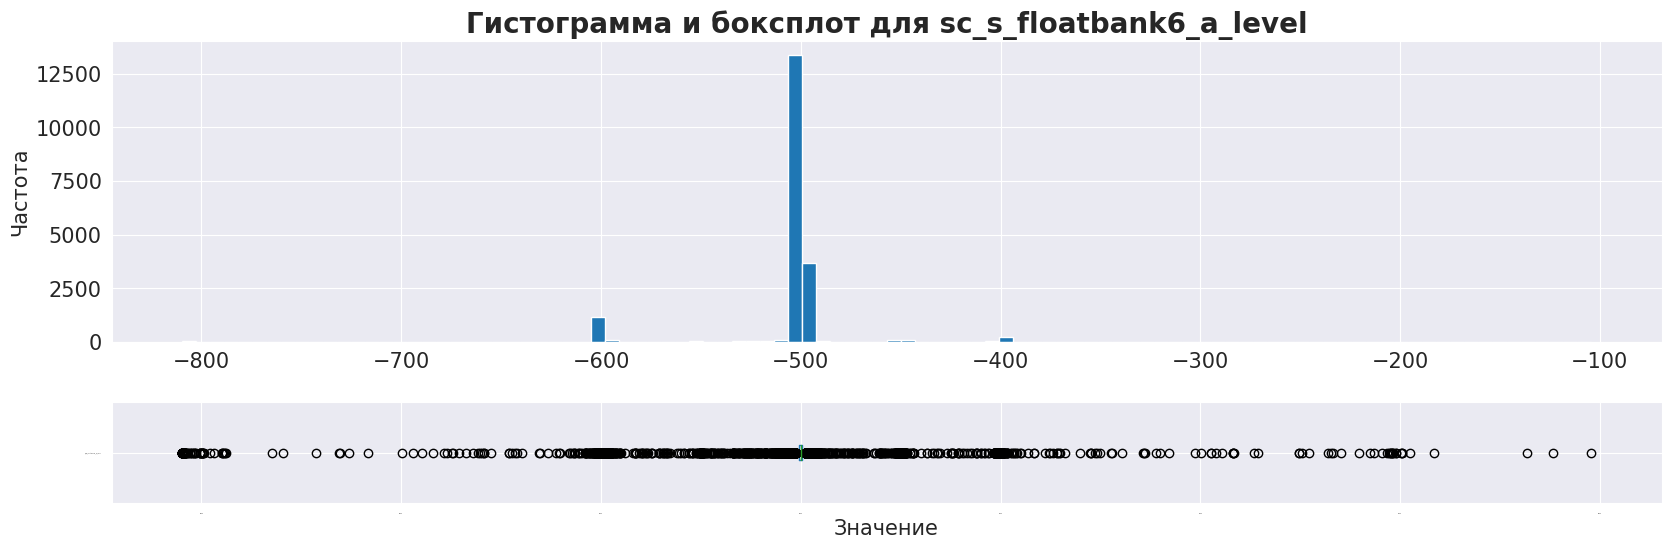

'Количество уникальных значений в столбце sc_s_floatbank6_a_level: 19438'

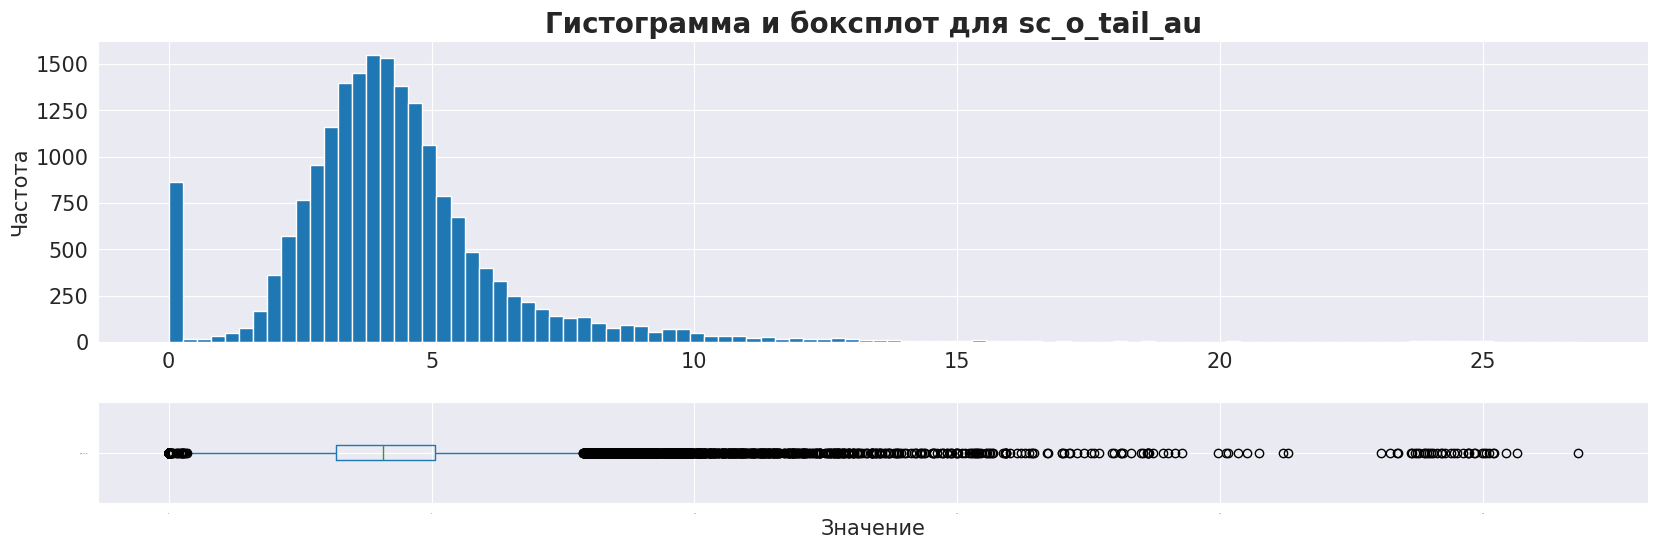

'Количество уникальных значений в столбце sc_o_tail_au: 18578'

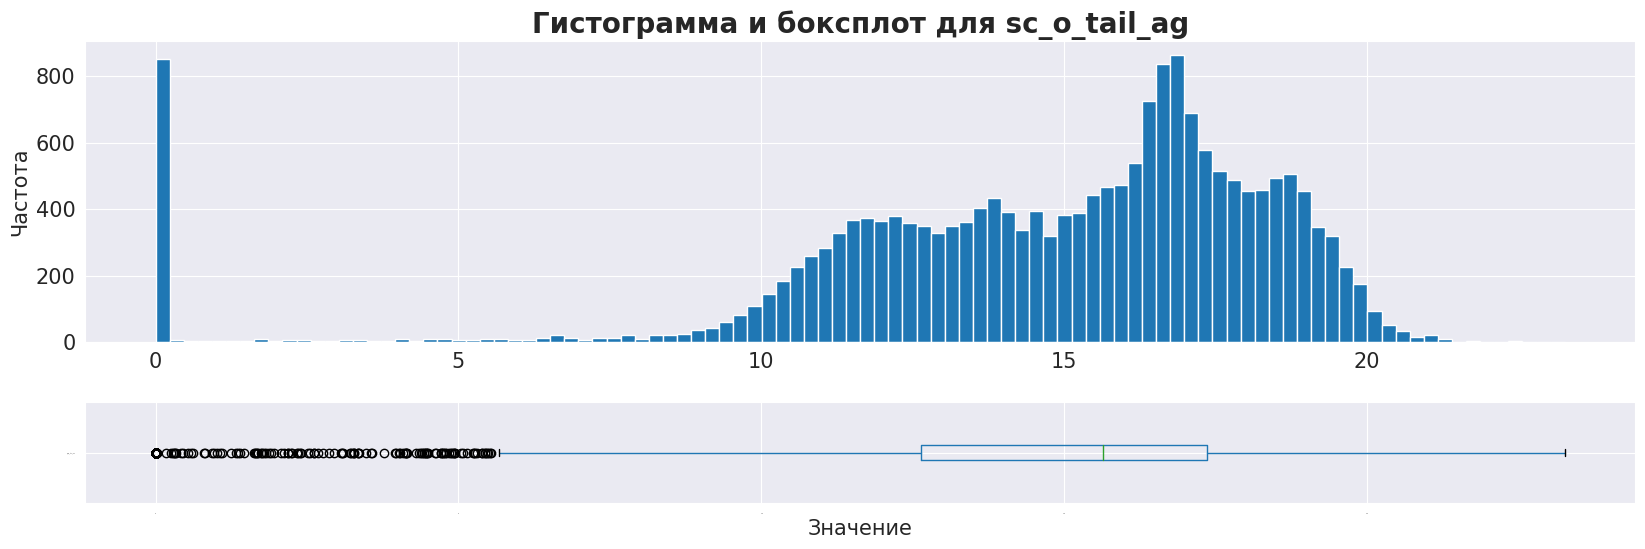

'Количество уникальных значений в столбце sc_o_tail_ag: 18576'

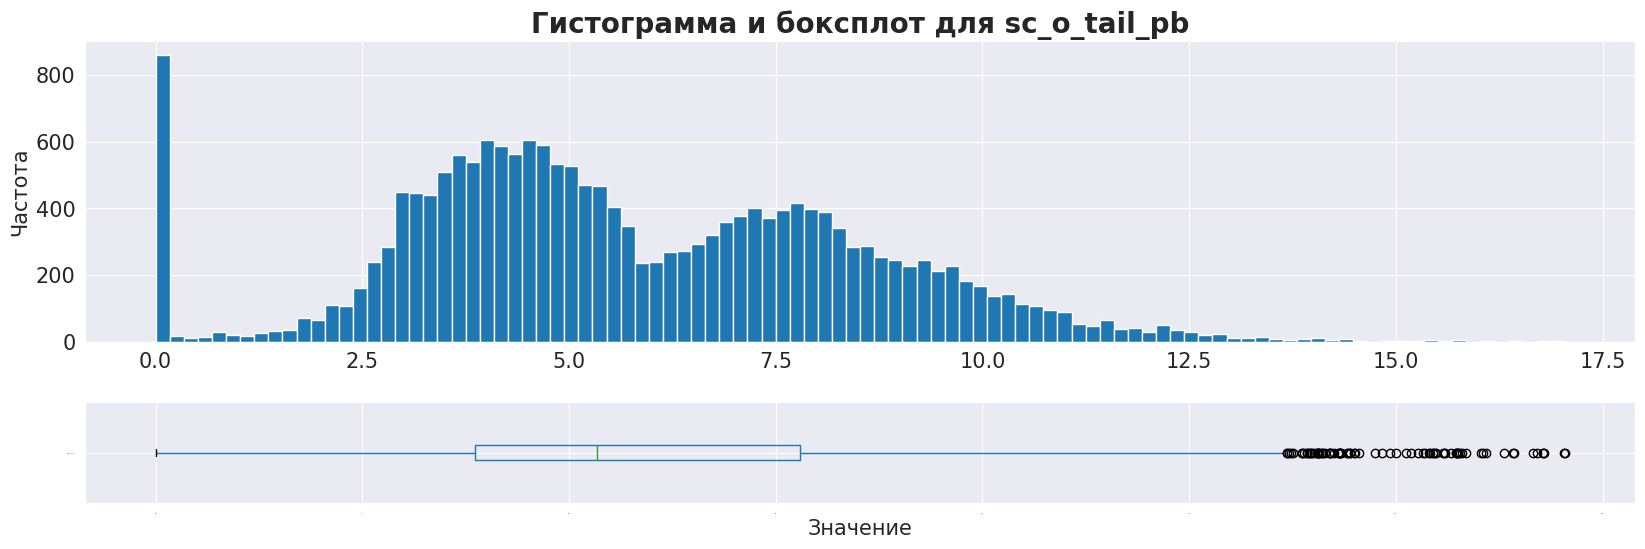

'Количество уникальных значений в столбце sc_o_tail_pb: 18562'

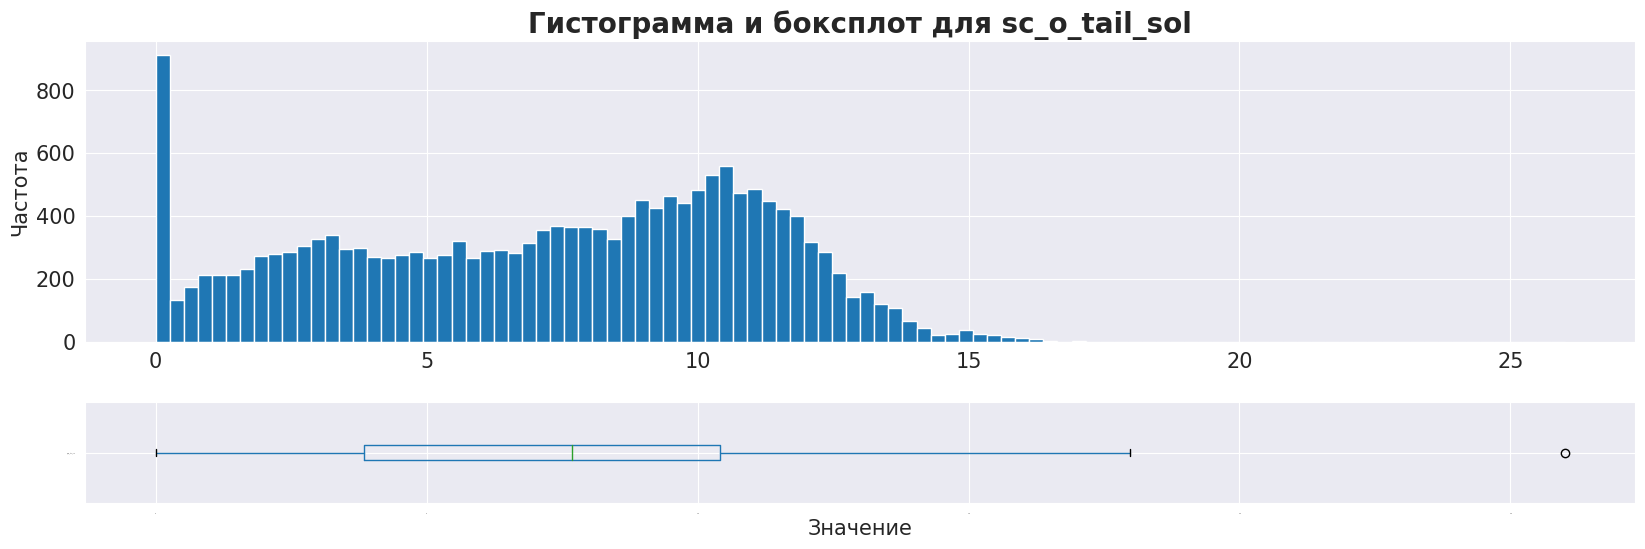

'Количество уникальных значений в столбце sc_o_tail_sol: 16831'

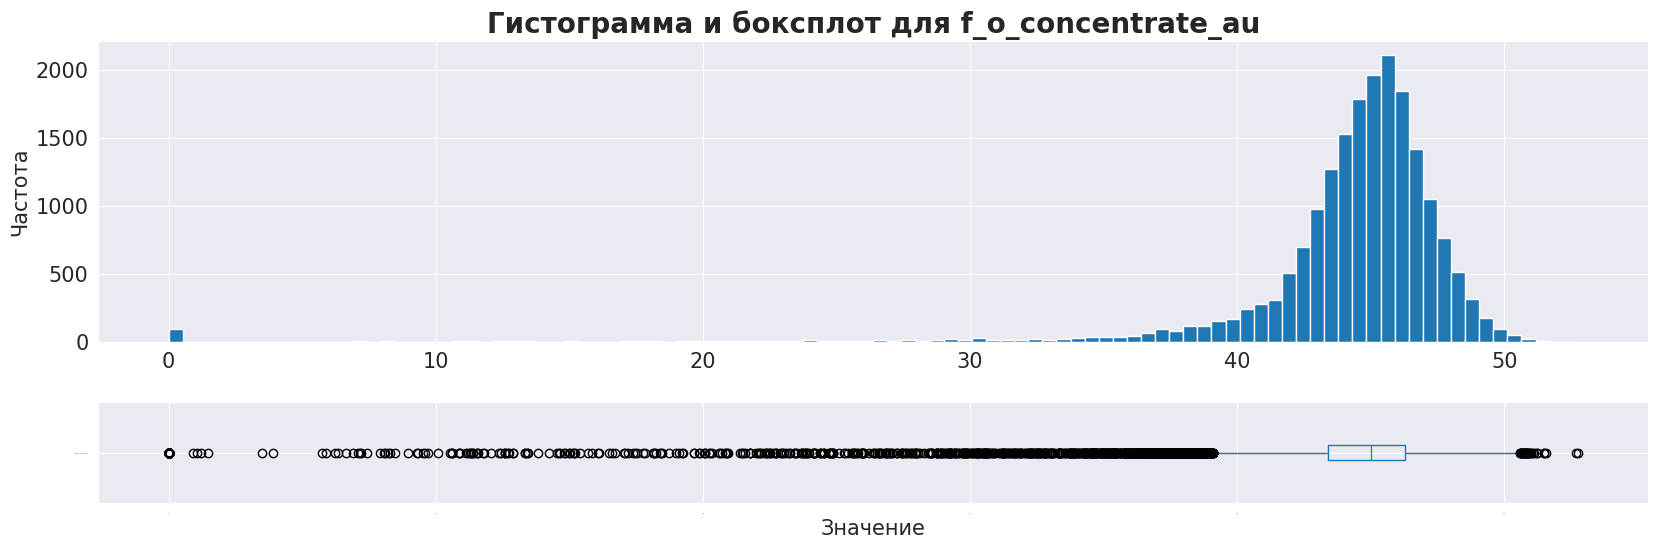

'Количество уникальных значений в столбце f_o_concentrate_au: 19308'

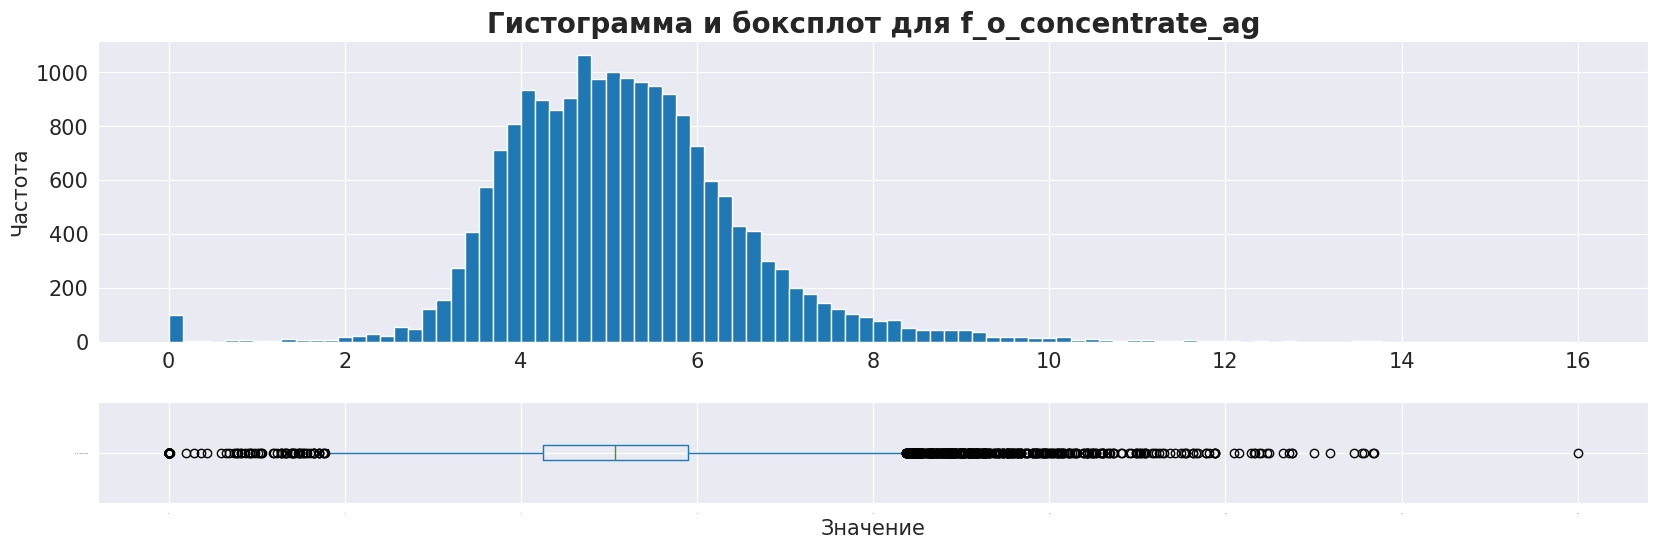

'Количество уникальных значений в столбце f_o_concentrate_ag: 19307'

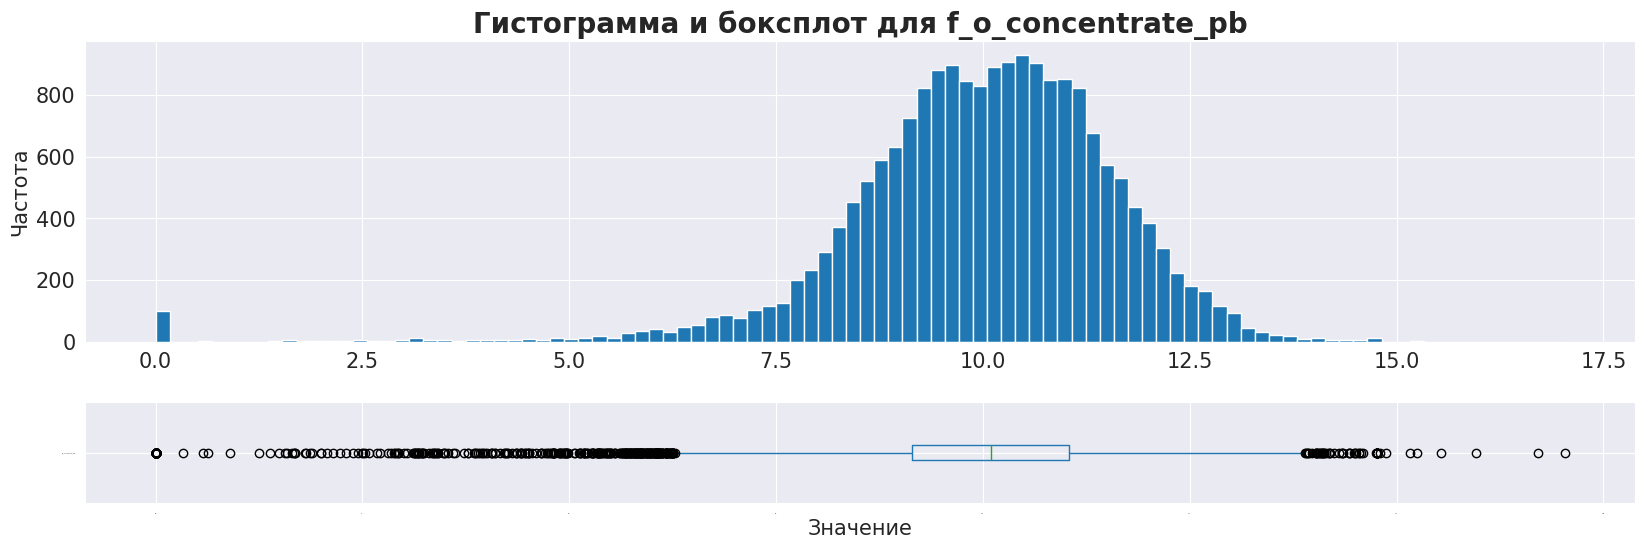

'Количество уникальных значений в столбце f_o_concentrate_pb: 19276'

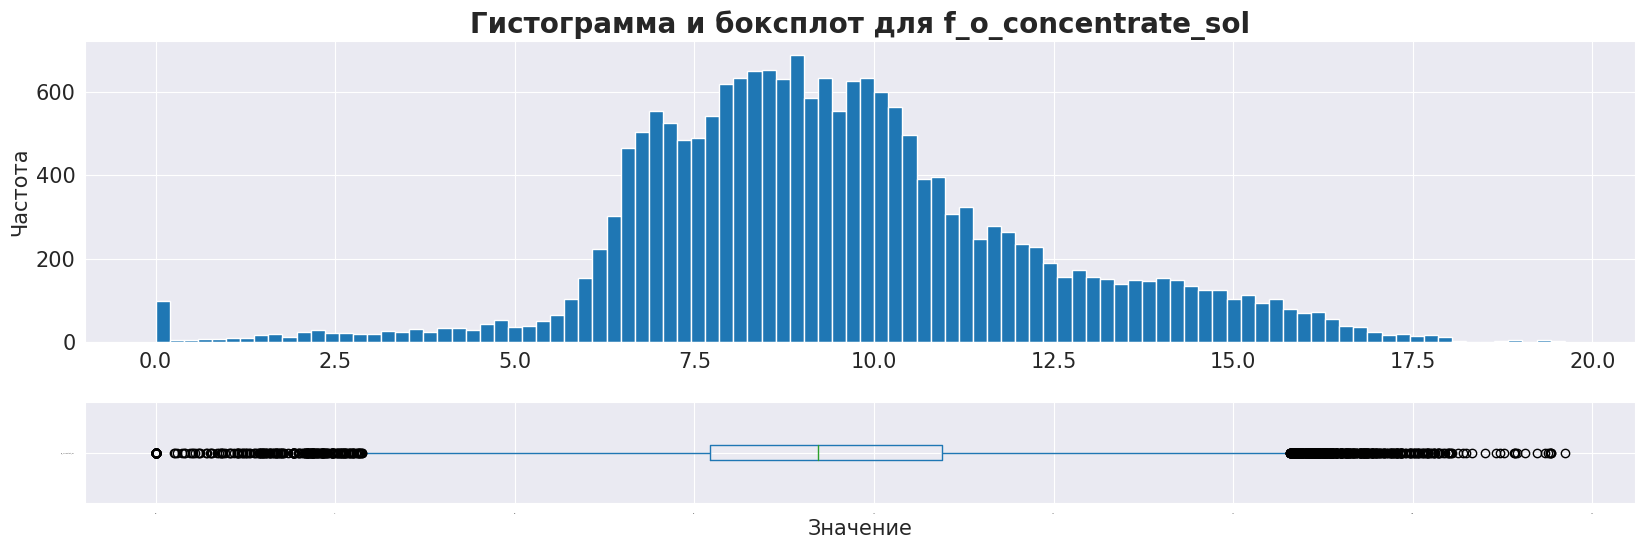

'Количество уникальных значений в столбце f_o_concentrate_sol: 19093'

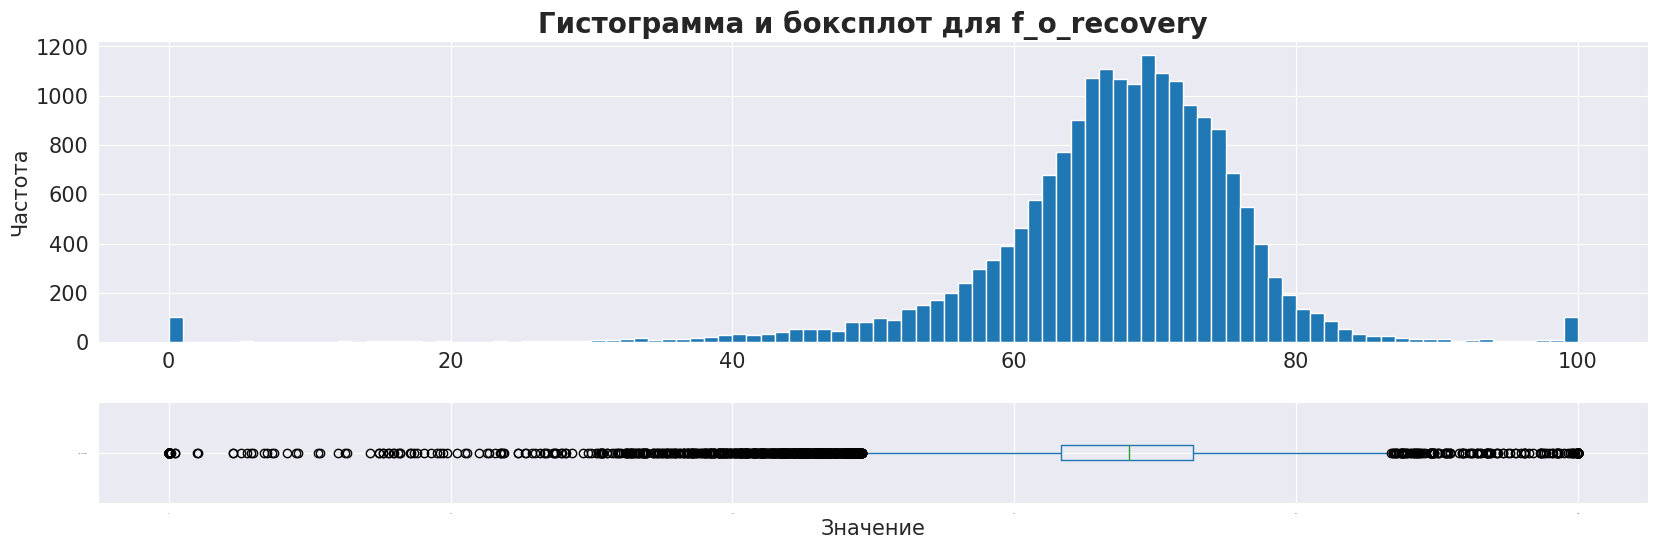

'Количество уникальных значений в столбце f_o_recovery: 19235'

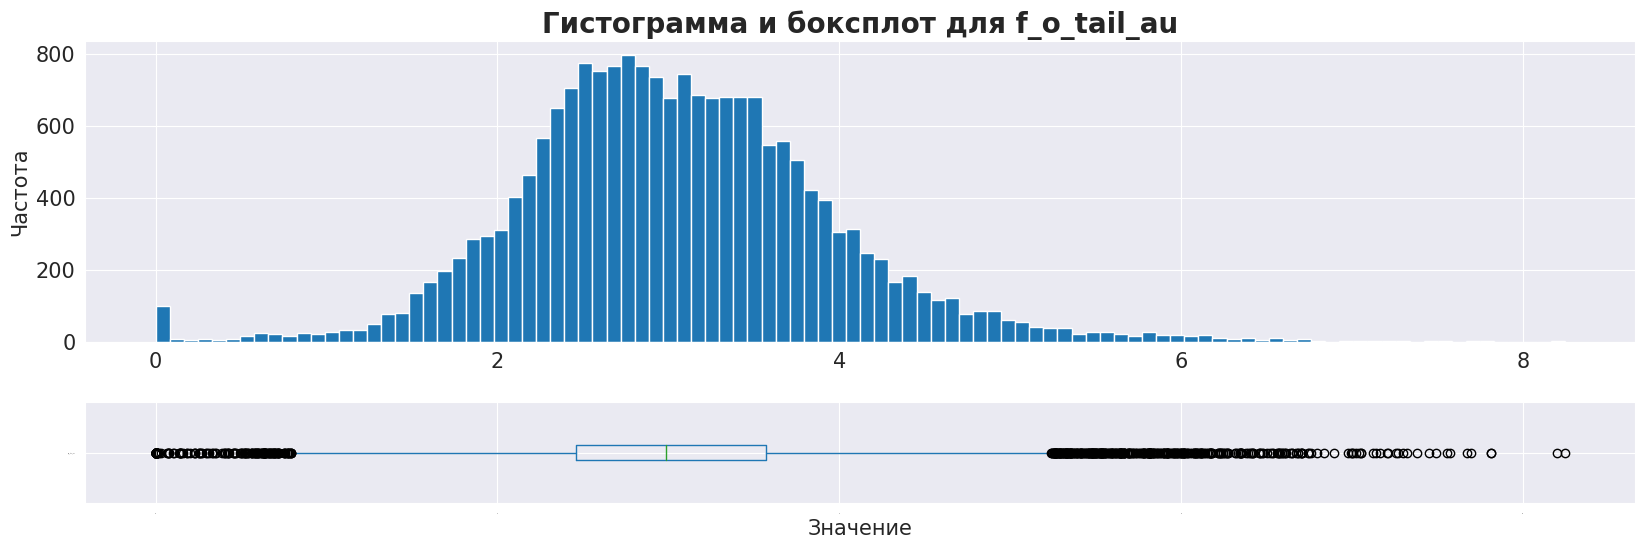

'Количество уникальных значений в столбце f_o_tail_au: 19329'

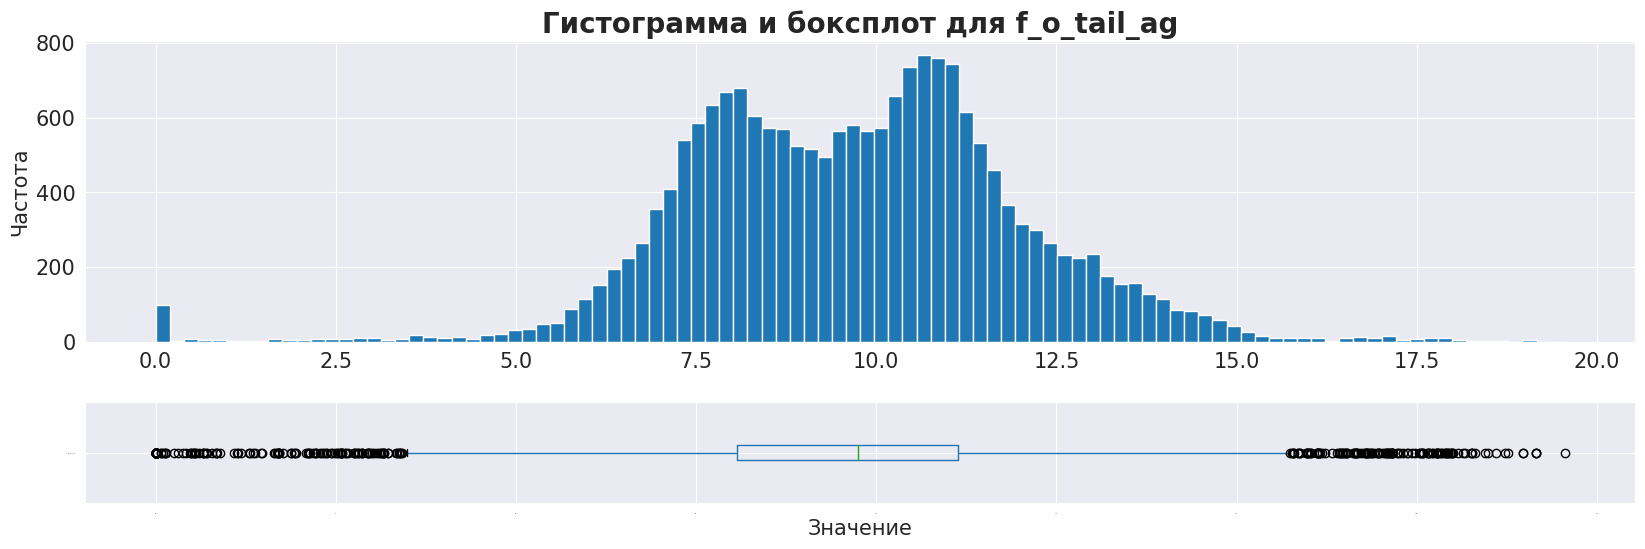

'Количество уникальных значений в столбце f_o_tail_ag: 19328'

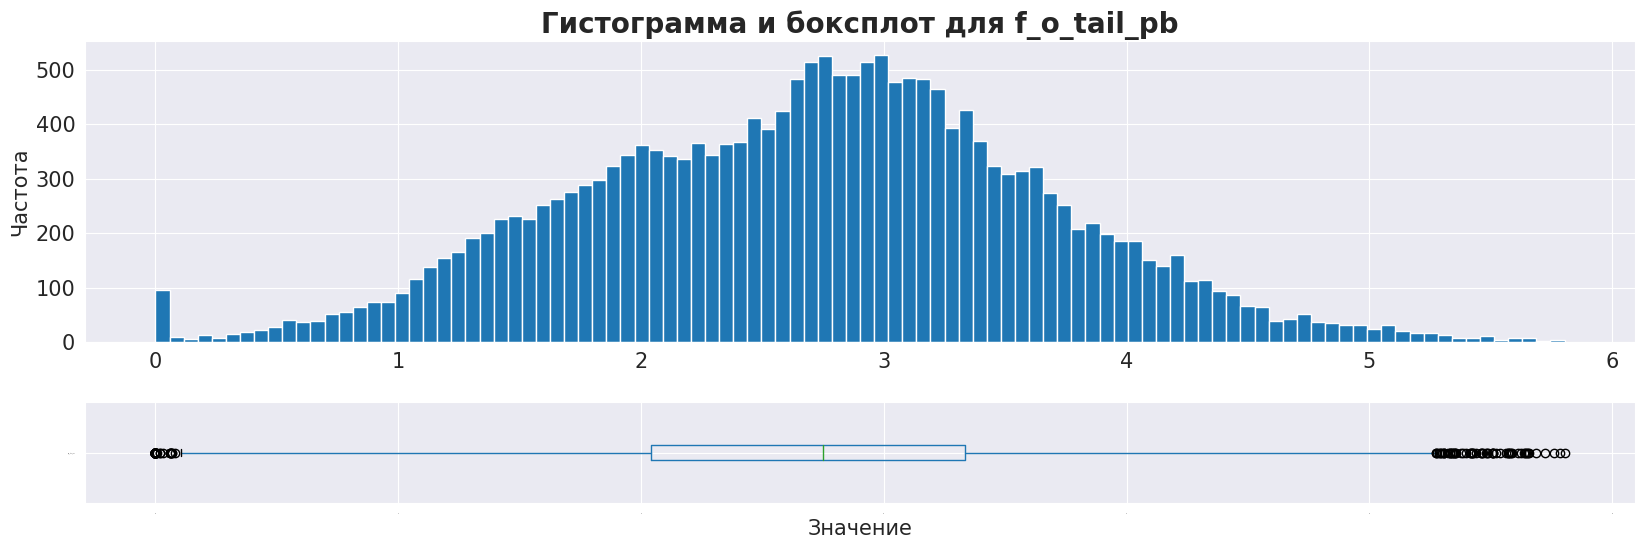

'Количество уникальных значений в столбце f_o_tail_pb: 19228'

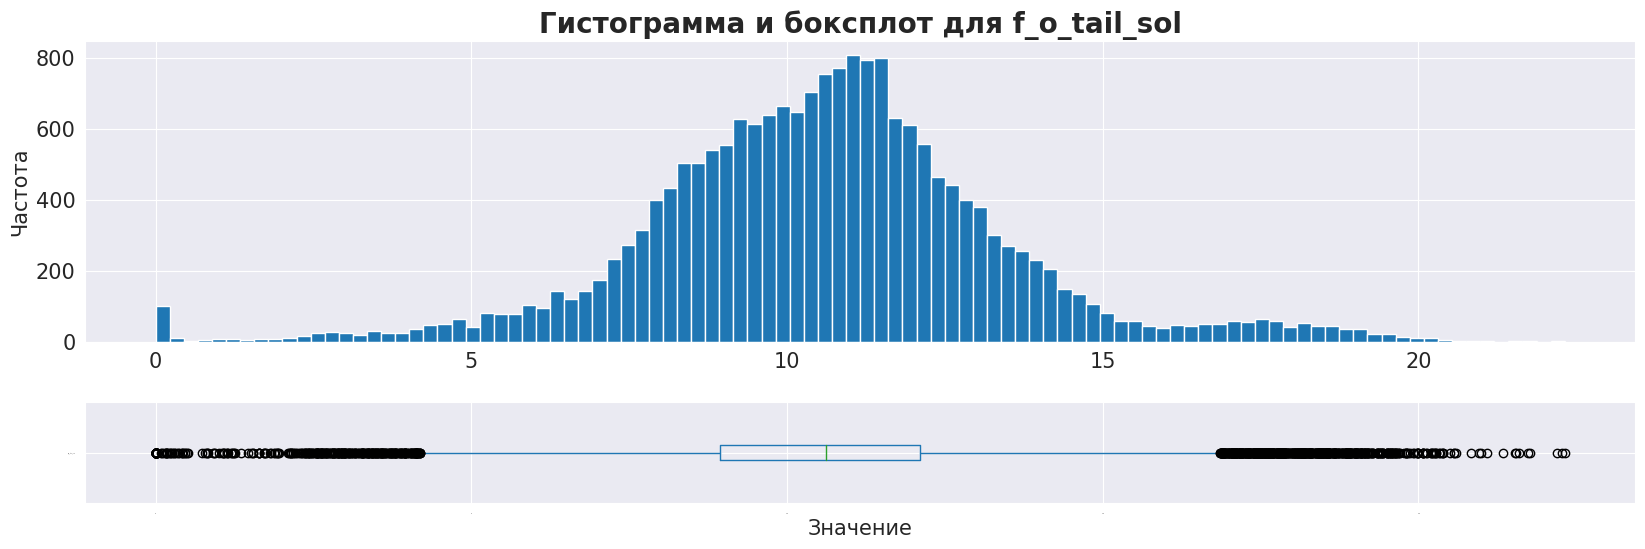

'Количество уникальных значений в столбце f_o_tail_sol: 19322'

In [7]:
# Визуальный осмотр данных на full выборке
def hist_boxplot_visualizator(df):
    for column in df.columns:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 6), gridspec_kw={'height_ratios': [3, 1]})
        df.hist(column=column, bins=100, ax=ax1)
        df.boxplot(column=column, vert=False, ax=ax2)
        ax1.set_title(f'Гистограмма и боксплот для {column}', fontsize=20, weight='bold')
        ax1.set_ylabel('Частота', fontsize=15)
        ax1.tick_params(axis='both', labelsize=15)
        ax2.set_xlabel('Значение', fontsize=15)
        ax2.tick_params(axis='both', labelsize=0)
        plt.show()
        display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')

hist_boxplot_visualizator(df_full)

In [8]:
# Прямых дубликатов
df_train.duplicated().sum() + df_test.duplicated().sum() + df_full.duplicated().sum()

0

In [9]:
# Посмотрим на повторы по отдельным этапам.
display(f'Дубликаты в rougher: {df_full.duplicated(subset=list(df_full.columns)[:35]).sum()}')
display(f'Дубликаты в pc: {df_full.duplicated(subset=list(df_full.columns)[35:55]).sum()}')
display(f'Дубликаты в sc: {df_full.duplicated(subset=list(df_full.columns)[55:77]).sum()}')
display(f'Дубликаты в final: {df_full.duplicated(subset=list(df_full.columns)[77:]).sum()}')

'Дубликаты в rougher: 0'

'Дубликаты в pc: 0'

'Дубликаты в sc: 0'

'Дубликаты в final: 30'

In [10]:
# Посмотрим на эти 30 дублей
df_full[df_full.duplicated(subset=list(df_full.columns)[77:], keep=False)]

r_i_feed_au  r_i_feed_ag  r_i_feed_pb  r_i_feed_sol  \
date                                                                       
2016-10-08 10:59:59         9.90        10.57         3.83         34.56   
2016-10-25 04:59:59         8.52         7.06         5.04         36.81   
2016-10-25 05:59:59         8.52         7.06         5.04         36.81   
2016-10-25 06:59:59         8.52         7.06         5.04         36.81   
2016-10-25 07:59:59         8.52         7.06         5.04         36.81   
2016-10-25 08:59:59         8.52         7.06         5.04         36.81   
2017-04-05 01:59:59         7.56         7.97         3.91           NaN   
2017-04-05 02:59:59         7.56         7.97         3.91           NaN   
2017-04-05 03:59:59         7.56         7.97         3.91           NaN   
2017-04-05 04:59:59         7.56         7.97         3.91           NaN   
2017-04-05 05:59:59         7.56         7.97         3.91           NaN   
2017-04-05 06:59:59         7.56         7.97         3.91           NaN   
2017-04-05 07:59:59         7.56         7.97         3.91           NaN   
2017-04-05 08:59:59         7.56         7.97         3.91           NaN   
2017-04-05 09:59:59         7.56         7.97         3.91           NaN   
2017-04-05 10:59:59         7.56         7.97         3.91           NaN   
2017-04-05 11:59:59         7.48         7.78         3.85           NaN   
2017-05-06 04:59:59         7.50         5.75         4.23         42.81   
2017-05-06 05:59:59         7.50         5.75         4.23         42.81   
2017-05-06 06:59:59         7.50         5.75         4.23         42.81   
2017-05-06 07:59:59         7.50         5.75         4.23         42.81   
2017-05-06 09:59:59         7.50         5.75         4.23         42.81   
2017-07-26 20:59:59        11.63        11.45         5.41         41.06   
2017-07-26 21:59:59        11.63        11.45         5.41         41.06   
2017-09-14 20:59:59         0.01         0.01         0.01          0.01   
2017-09-14 21:59:59         0.01         0.01         0.01          0.01   
2017-09-14 22:59:59         0.01         0.01         0.01          0.01   
2017-10-12 22:59:59         7.41         8.36         3.66         40.06   
2017-10-12 23:59:59         7.41         8.36         3.66         40.06   
2017-10-13 00:59:59         7.41         8.36         3.66         40.06   
2017-10-13 01:59:59         7.41         8.36         3.66         40.06   
2017-12-17 03:59:59         6.40         6.77         5.69         38.06   
2017-12-17 04:59:59         6.40         6.77         5.69         38.06   
2017-12-17 05:59:59         6.40         6.77         5.69         38.06   
2018-02-05 18:59:59         7.41         8.36         3.66         40.06   
2018-02-22 17:59:59         0.01         0.01         0.01          0.01   
2018-03-25 10:59:59         7.50         5.75         4.23         42.81   
2018-05-30 21:59:59         9.90        10.57         3.83         34.56   

                     r_i_feed_rate  r_i_feed_size  r_i_floatbank10_sulfate  \
date                                                                         
2016-10-08 10:59:59         414.26          42.74                    12.00   
2016-10-25 04:59:59           0.14          46.13                     0.00   
2016-10-25 05:59:59           0.15          45.90                     0.00   
2016-10-25 06:59:59           0.16          45.91                     0.00   
2016-10-25 07:59:59           0.16          45.91                     0.07   
2016-10-25 08:59:59         138.38          45.92                     1.35   
2017-04-05 01:59:59           1.47          42.26                      NaN   
2017-04-05 02:59:59           1.49          39.03                      NaN   
2017-04-05 03:59:59           1.54          40.21                      NaN   
2017-04-05 04:59:59           1.64          41.53                      NaN   
2017-04-05 05:59:59           1.67          

In [11]:
# Дубликатов по индексу нет
df_train.index.duplicated().sum() + df_test.index.duplicated().sum() + df_full.index.duplicated().sum()

0

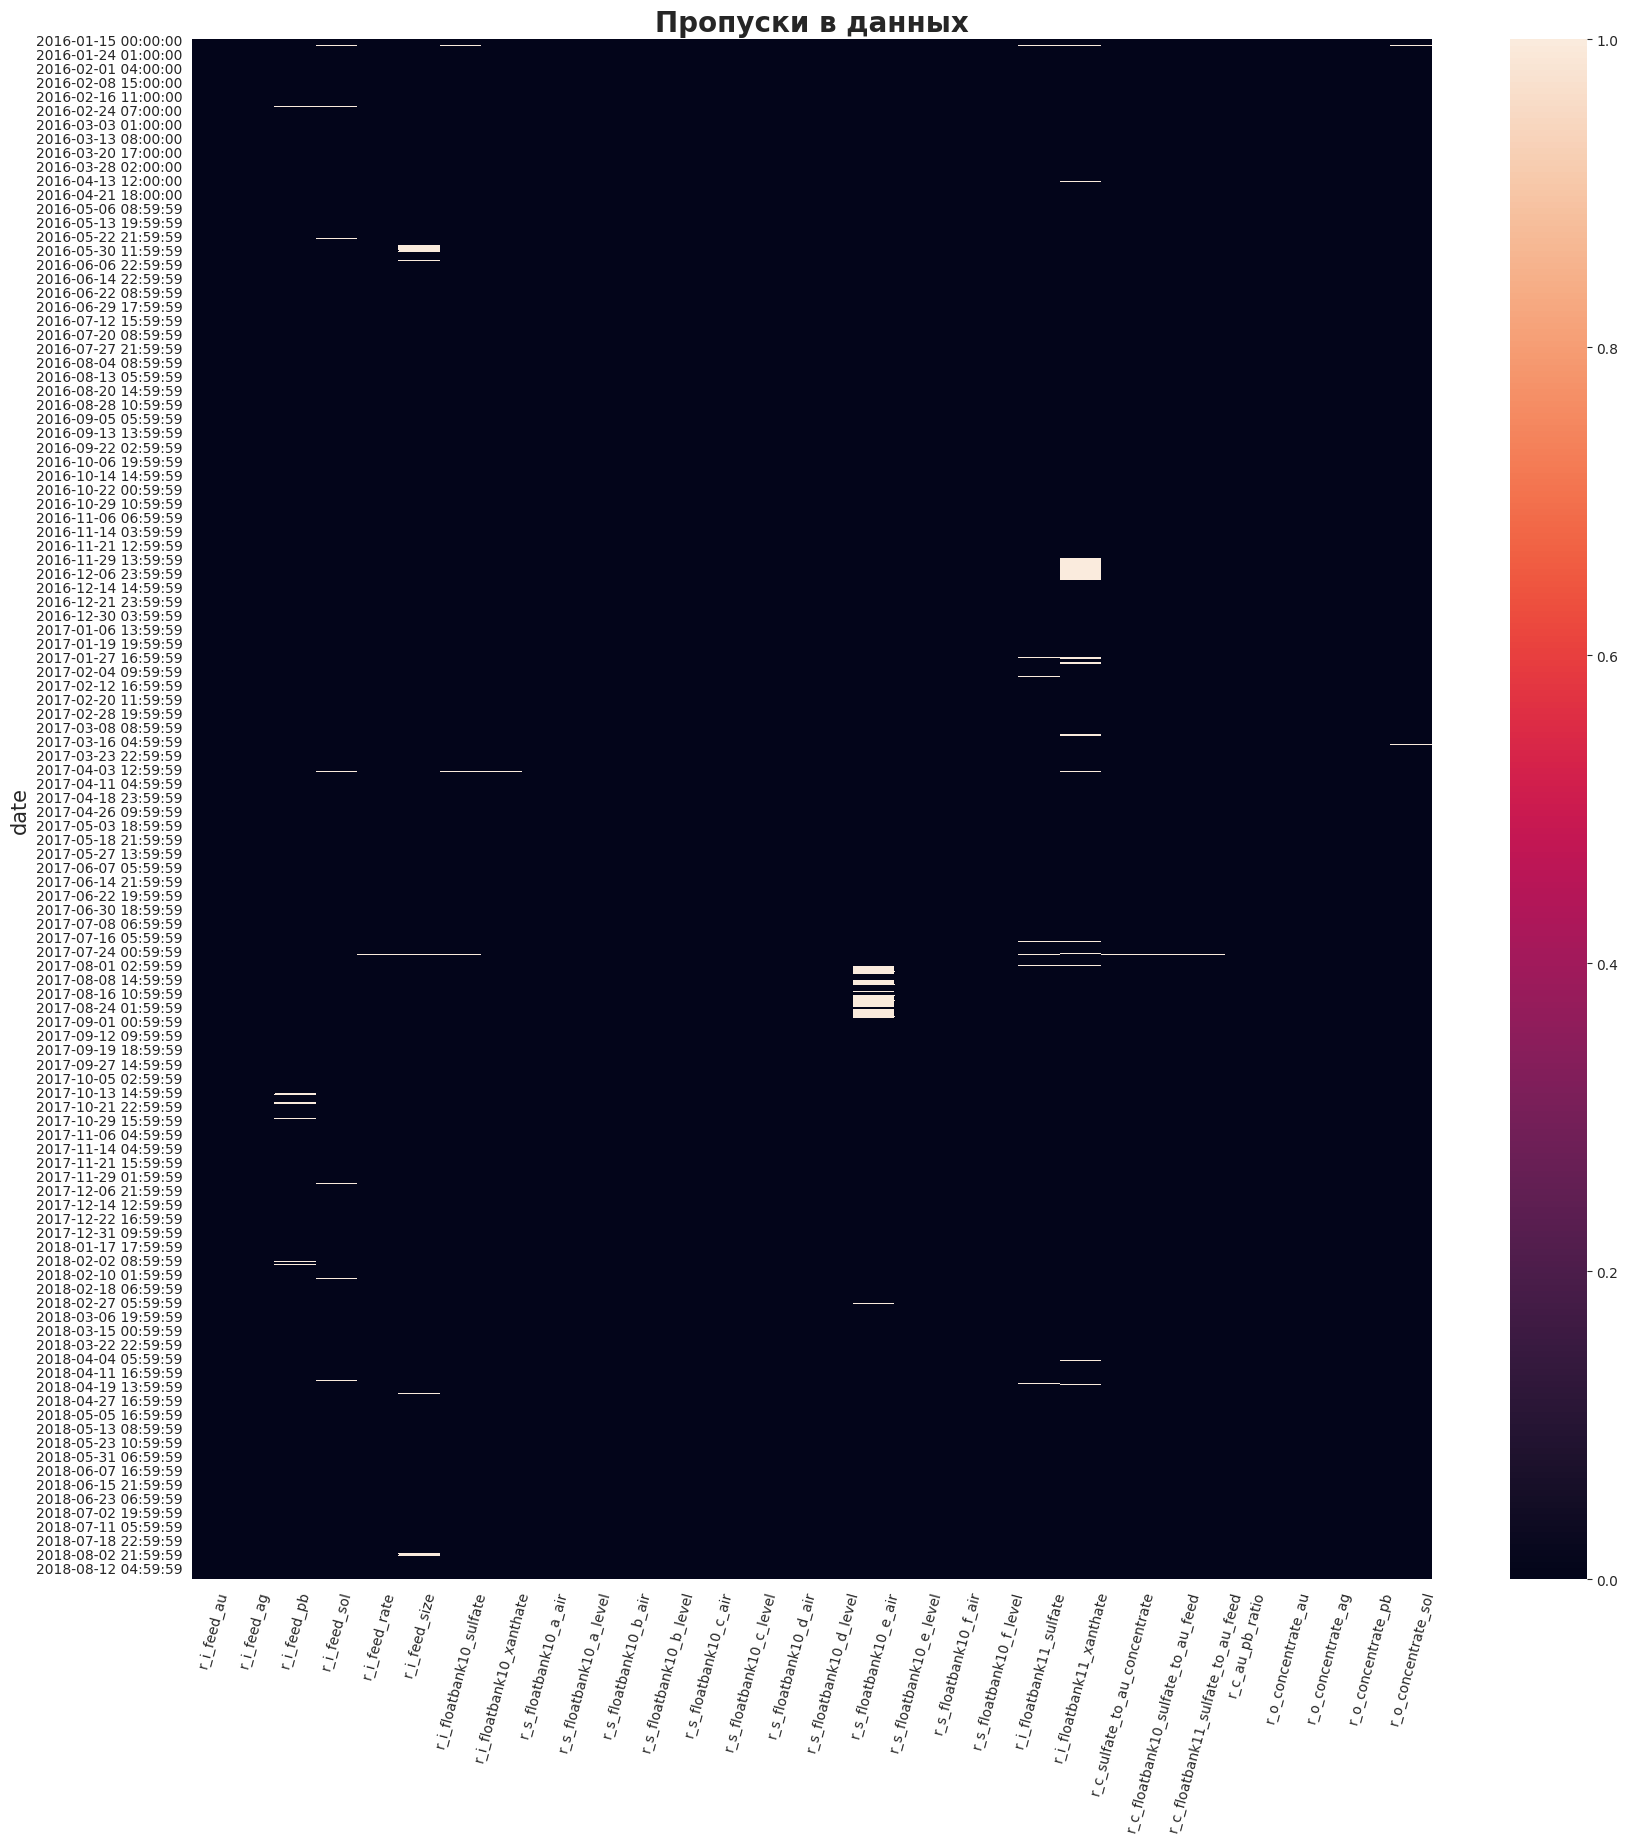

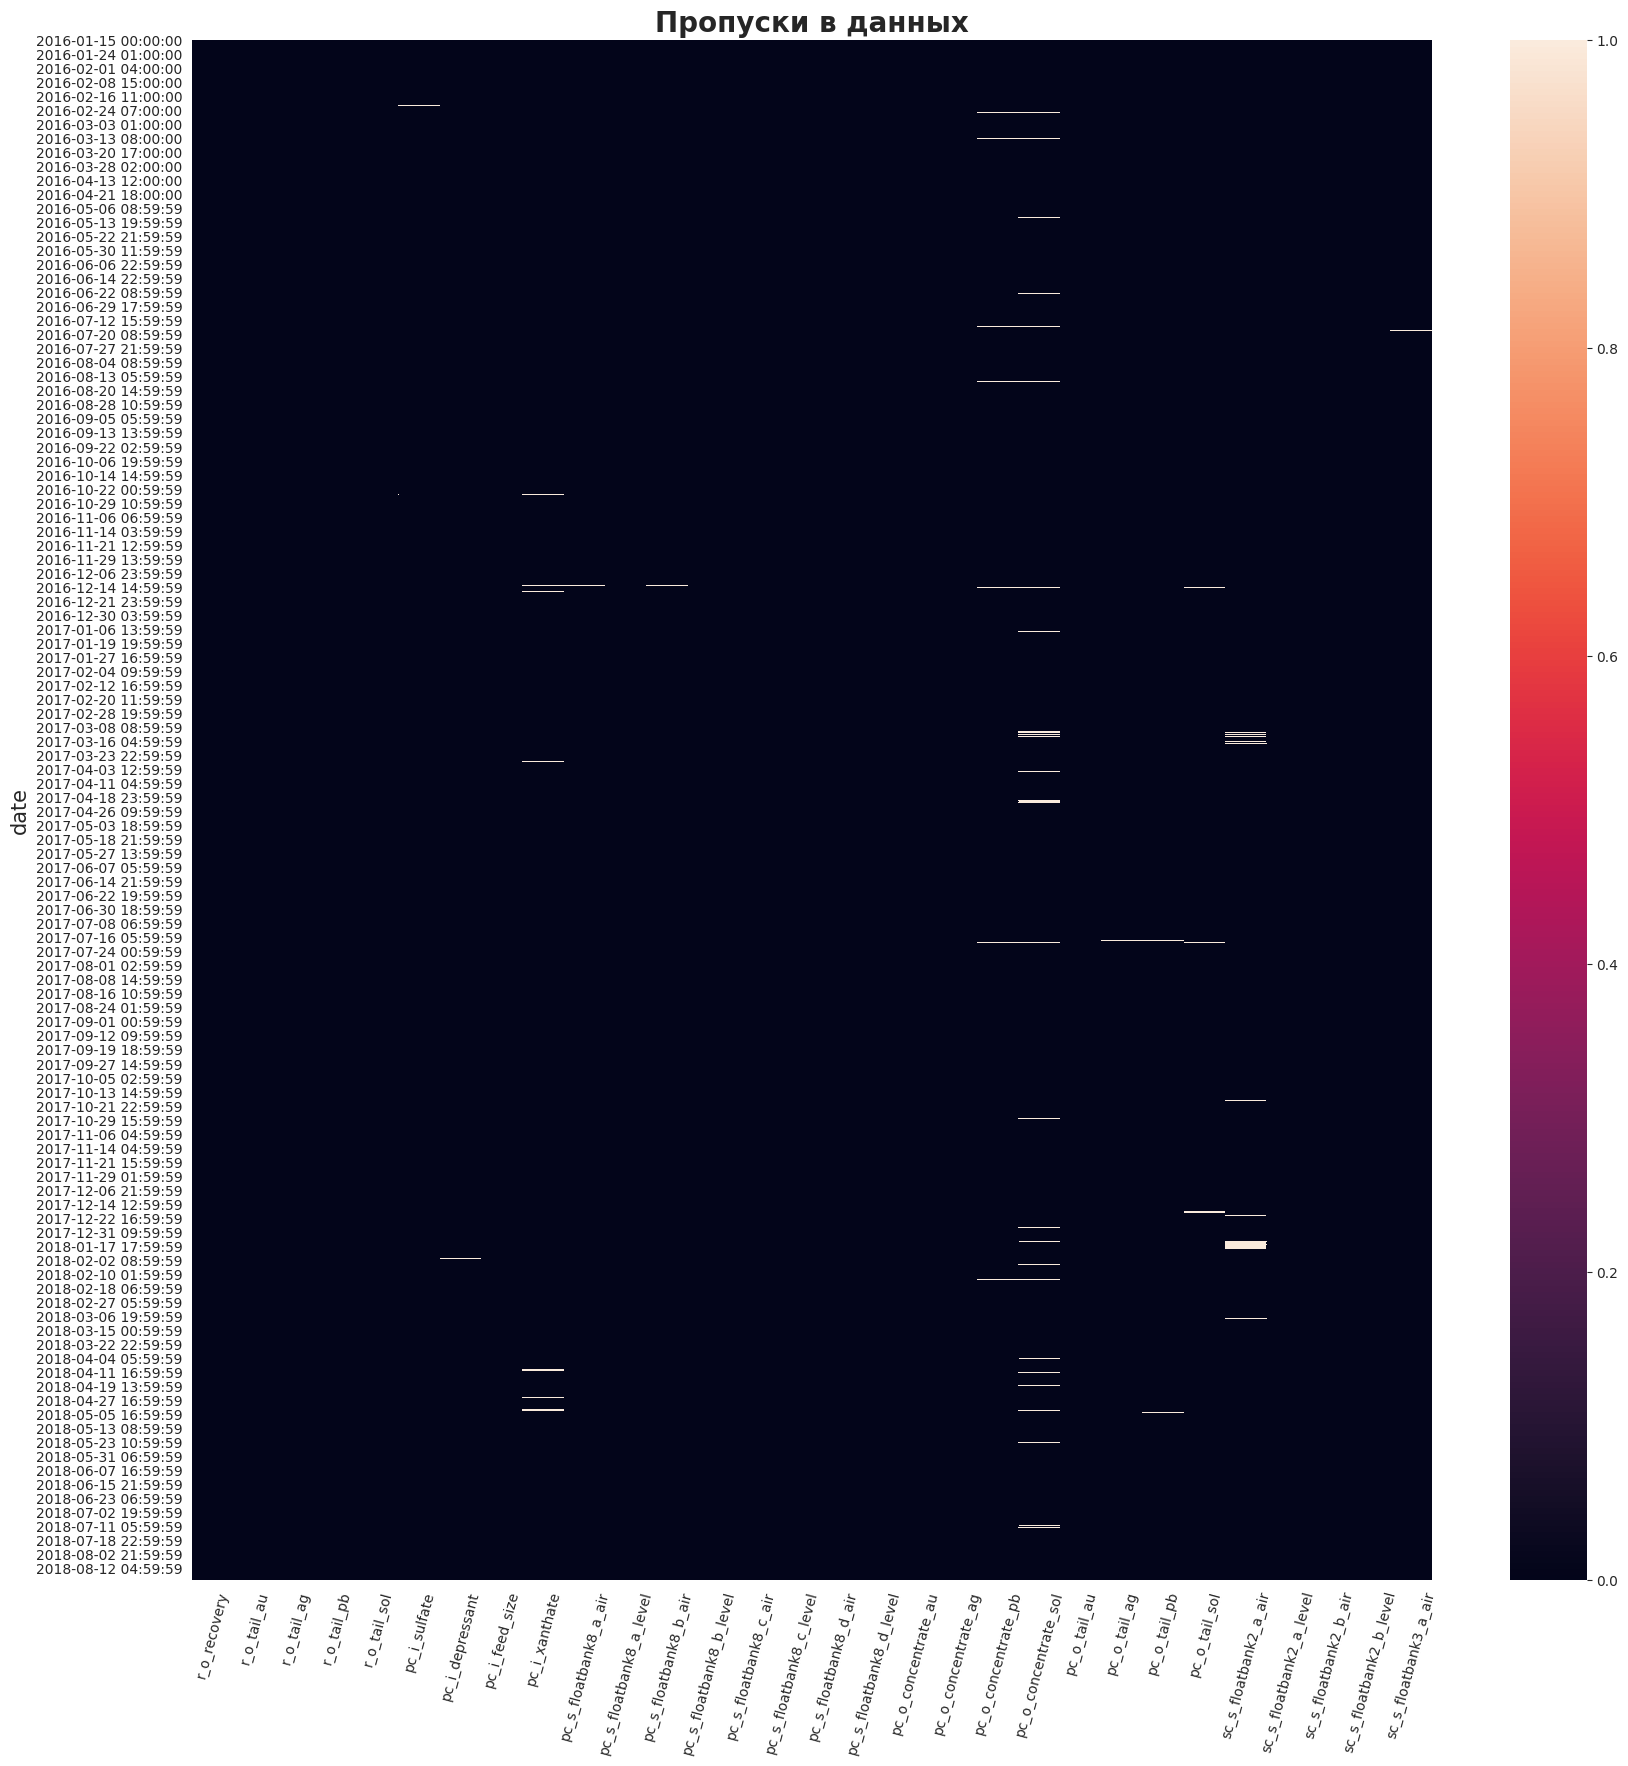

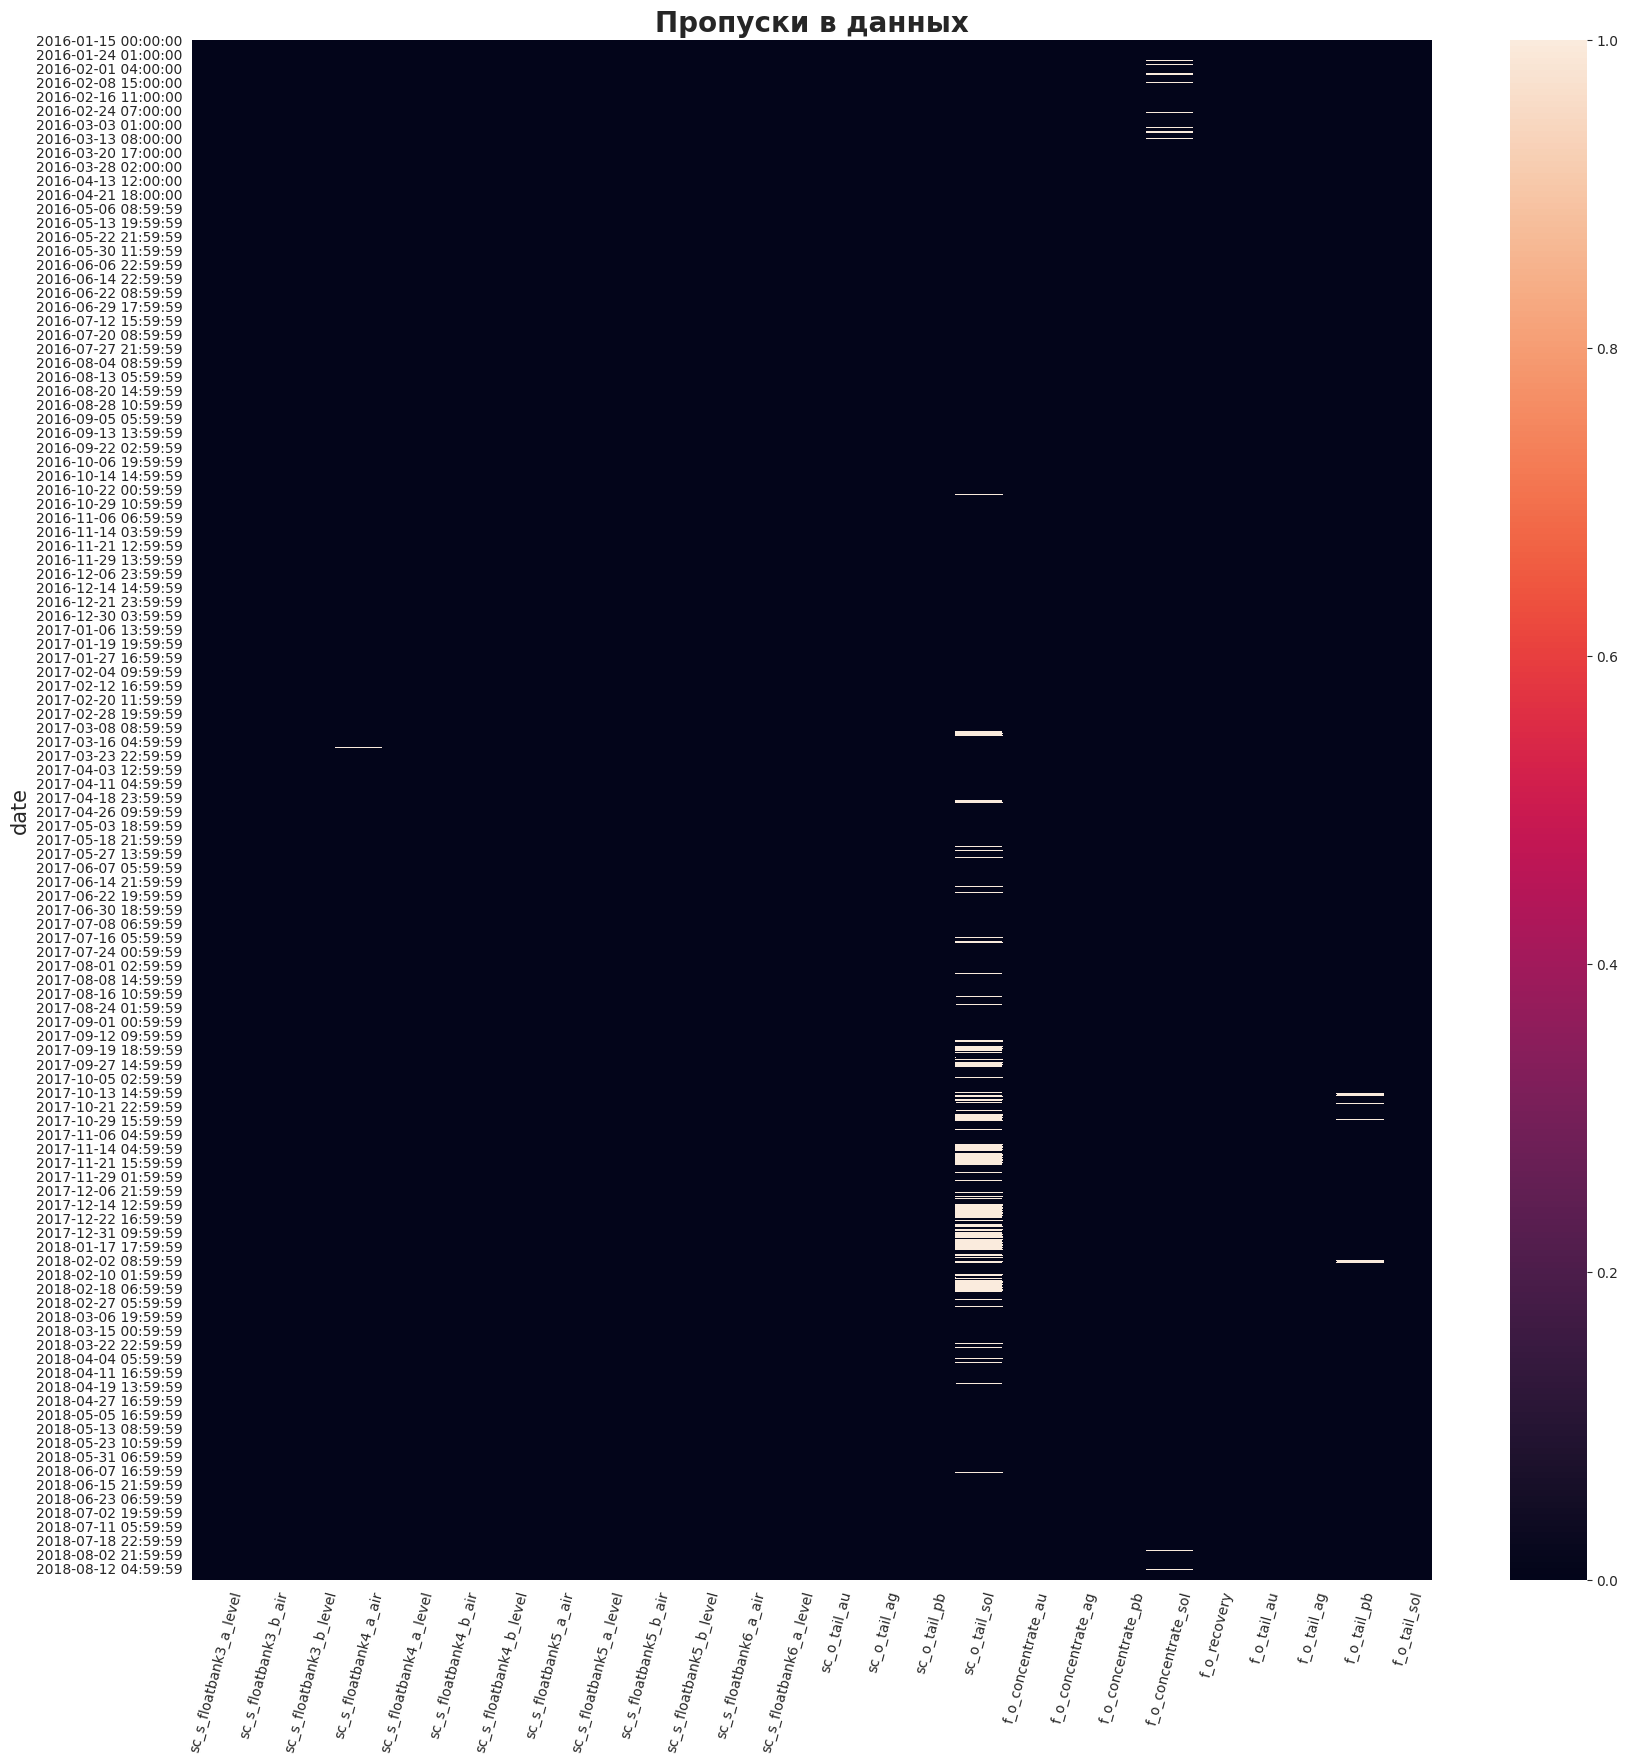

In [12]:
# Визуализируем пропуски
i = 0
step = 30
while i < df_full.shape[1]:
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_title('Пропуски в данных', fontsize=20, weight='bold')
    ax.set_xlabel('Столбец', fontsize=15)
    ax.set_ylabel('Индекс', fontsize=15)
    sns.heatmap(df_full.iloc[:, i:i+step].sort_index().isna(), ax=ax);
    ax.tick_params(axis='x', labelsize=10, rotation=75)
    ax.tick_params(axis='y', labelsize=10)
    plt.show
    i += step

In [13]:
# Посмотрим каких столбцов нет в test
diff , common = [], []
for el in df_train.columns:
    if el in df_test.columns:
        common.append(el)
    else:
        diff.append(el)

display(f'Общие столбцы: {common}')
display(f'Отсутствующие в test столбцы: {diff}')

"Общие столбцы: ['r_i_feed_au', 'r_i_feed_ag', 'r_i_feed_pb', 'r_i_feed_sol', 'r_i_feed_rate', 'r_i_feed_size', 'r_i_floatbank10_sulfate', 'r_i_floatbank10_xanthate', 'r_s_floatbank10_a_air', 'r_s_floatbank10_a_level', 'r_s_floatbank10_b_air', 'r_s_floatbank10_b_level', 'r_s_floatbank10_c_air', 'r_s_floatbank10_c_level', 'r_s_floatbank10_d_air', 'r_s_floatbank10_d_level', 'r_s_floatbank10_e_air', 'r_s_floatbank10_e_level', 'r_s_floatbank10_f_air', 'r_s_floatbank10_f_level', 'r_i_floatbank11_sulfate', 'r_i_floatbank11_xanthate', 'pc_i_sulfate', 'pc_i_depressant', 'pc_i_feed_size', 'pc_i_xanthate', 'pc_s_floatbank8_a_air', 'pc_s_floatbank8_a_level', 'pc_s_floatbank8_b_air', 'pc_s_floatbank8_b_level', 'pc_s_floatbank8_c_air', 'pc_s_floatbank8_c_level', 'pc_s_floatbank8_d_air', 'pc_s_floatbank8_d_level', 'sc_s_floatbank2_a_air', 'sc_s_floatbank2_a_level', 'sc_s_floatbank2_b_air', 'sc_s_floatbank2_b_level', 'sc_s_floatbank3_a_air', 'sc_s_floatbank3_a_level', 'sc_s_floatbank3_b_air', 'sc_s_f

"Отсутствующие в test столбцы: ['r_c_sulfate_to_au_concentrate', 'r_c_floatbank10_sulfate_to_au_feed', 'r_c_floatbank11_sulfate_to_au_feed', 'r_c_au_pb_ratio', 'r_o_concentrate_au', 'r_o_concentrate_ag', 'r_o_concentrate_pb', 'r_o_concentrate_sol', 'r_o_recovery', 'r_o_tail_au', 'r_o_tail_ag', 'r_o_tail_pb', 'r_o_tail_sol', 'pc_o_concentrate_au', 'pc_o_concentrate_ag', 'pc_o_concentrate_pb', 'pc_o_concentrate_sol', 'pc_o_tail_au', 'pc_o_tail_ag', 'pc_o_tail_pb', 'pc_o_tail_sol', 'sc_o_tail_au', 'sc_o_tail_ag', 'sc_o_tail_pb', 'sc_o_tail_sol', 'f_o_concentrate_au', 'f_o_concentrate_ag', 'f_o_concentrate_pb', 'f_o_concentrate_sol', 'f_o_recovery', 'f_o_tail_au', 'f_o_tail_ag', 'f_o_tail_pb', 'f_o_tail_sol']"

### Проверка расчёта эффективности обогащения

In [14]:
# Проверка на тестовой выборке на основе рассчёта MAE для rougher.output.recovery

# Показатель в данных
ror_from_train = df_train['r_o_recovery']

# Доля золота в концентрате после флотации/очистки
C = df_train['r_o_concentrate_au']
# Доля золота в сырье/концентрате до флотации/очистки
F = df_train['r_i_feed_au']
# Доля золота в отвальных хвостах после флотации/очистки
T = df_train['r_o_tail_au']
# Расчёт
calculated_ror_for_train = (C * (F - T)) / (F * (C - T)) * 100

mae_for_ror = mean_absolute_error(calculated_ror_for_train, ror_from_train)

display(f'MAE для rougher.output.recovery относительно рассчёта: {mae_for_ror:.2f}')

'MAE для rougher.output.recovery относительно рассчёта: 0.00'

In [15]:
# Проверим, что full датасет не отличается от test и train
sample_1 = df_train
sample_2 = df_full.loc[sample_1.index, sample_1.columns]
display(f'Данные из train совпадают с денными из full: {sample_1.sum().sum() == sample_2.sum().sum()}')

sample_1 = df_test
sample_2 = df_full.loc[sample_1.index, sample_1.columns]
display(f'Данные из test совпадают с денными из full: {sample_1.sum().sum() == sample_2.sum().sum()}')

'Данные из train совпадают с денными из full: True'

'Данные из test совпадают с денными из full: True'

### Выводы

* Данные представлены в размере порядка 20 тыс. семплов и содержат по 86 показателей.
* Все показатели имеют непрерывный характер.
* Показатели разделены на группы `[rougher, primary_cleaner, secondary_cleaner, final]` и подгруппы `[input, state, calculation, output]`.
* Тестовая выборка не включает в себя подгруппы `calculation` и `output` и содержит 52 показателя. Как следствие - этап `final` полностью отсутствует.
* В данных имеются пропуски, но их количество на первый взгляд некритично. Пропуски распределены преимущественно небольшими блоками в зависимости от даты и преимущественно рассредоточены по всему периоду наблюдения. Работа с пропусками будет проведена позже.
* В данных обнаружены 30 дублей данных на этапе final. # Дубли идут последовательно по времени с лагом в 1 час, вероятно какое-то нарушение процесса сбора данных. Большая часть дублей в тренировочной выборке. Перед обучением они будут удалены из нее.
* В столбцах `r_o_recovery` и `f_o_recovery` (наши будущие целевые показатели для моделей) пропуски отсутствуют.
* Анализ распределение и боксплотов показывает, что распределение столбцов очень разнообразно. Какие-то из распределений походят на дискретные, однако самое минимальное число различных значений по столбцу составляет более 5000. В части данных имеются выбросы, однако они содержатся либо в calculated столбцах, либо в output столбцах, с которые не будут участвовать в дальнейших расчётах.
* Единственный столбец, который будет участвовать в дальнейших рассчётах и где стоит убрать часть выбросов за пределами диапазона (2, 12) это столбец `pc_i_feed_size`. Выбросы в нем мы обработаем позже.
* В части данных есть пик в районе нулевого значения. Так же в большом количестве наблюдаются значения за пределами усов боксплотов. Однако, однозначно судить о том, что это выбросы пока сложно.
* Проверка показала, что расчёт для эффективности обогащения в тренировочных данных сделан верно.
* Наиболее полные данные содержатся в `full`, данные из `train` и `test` совпадают с `full`.

## Исследовательский анализ данных

### Концентрация металлов Au, Ag и Pb на различных этапах

In [16]:
# Посмотрим как меняется концентрация металлов в зависимости от этапов
# Оставим только необходимые данные для графиков
cols_to_analyze = ['r_i_feed_au',
                   'r_o_concentrate_au',
                   'pc_o_concentrate_au',
                   'f_o_concentrate_au']
data_for_au = df_full[cols_to_analyze].copy()

cols_to_analyze = ['r_i_feed_ag',
                   'r_o_concentrate_ag',
                   'pc_o_concentrate_ag',
                   'f_o_concentrate_ag']
data_for_ag = df_full[cols_to_analyze].copy()

cols_to_analyze = ['r_i_feed_pb',
                   'r_o_concentrate_pb',
                   'pc_o_concentrate_pb',
                   'f_o_concentrate_pb']
data_for_pb = df_full[cols_to_analyze].copy()

# Поменяем названия столбцов
data_for_au.columns = data_for_ag.columns = data_for_pb.columns = \
    ['Сырье', 'Черн. конц-т', 'Конц-т после 1 оч.', 'Фин. конц-т']

In [17]:
# Выберем индексы, где концентрация металлов после флотации в сырье околонулевая
indexes_with_no_metal = df_full[(df_full['r_o_concentrate_au'] < 0.01)
                                | (df_full['r_o_concentrate_ag'] < 0.01)
                                | (df_full['r_o_concentrate_pb'] < 0.01)
                                | (df_full['pc_o_concentrate_au'] < 0.01)
                                | (df_full['pc_o_concentrate_ag'] < 0.01)
                                | (df_full['pc_o_concentrate_pb'] < 0.01)
                                | (df_full['f_o_concentrate_au'] < 0.01)
                                | (df_full['f_o_concentrate_ag'] < 0.01)
                                | (df_full['f_o_concentrate_pb'] < 0.01)].index
indexes_with_no_metal.shape

(714,)

In [18]:
# Удалим эти индексы для графиков
display(f'Размеры сетов до удаления: {data_for_au.shape[0]}, {data_for_ag.shape[0]}, {data_for_pb.shape[0]}')
data_for_au.drop(index=indexes_with_no_metal, inplace=True)
data_for_ag.drop(index=indexes_with_no_metal, inplace=True)
data_for_pb.drop(index=indexes_with_no_metal, inplace=True)
display(f'Размеры сетов после удаления: {data_for_au.shape[0]}, {data_for_ag.shape[0]}, {data_for_pb.shape[0]}')

'Размеры сетов до удаления: 19439, 19439, 19439'

'Размеры сетов после удаления: 18725, 18725, 18725'

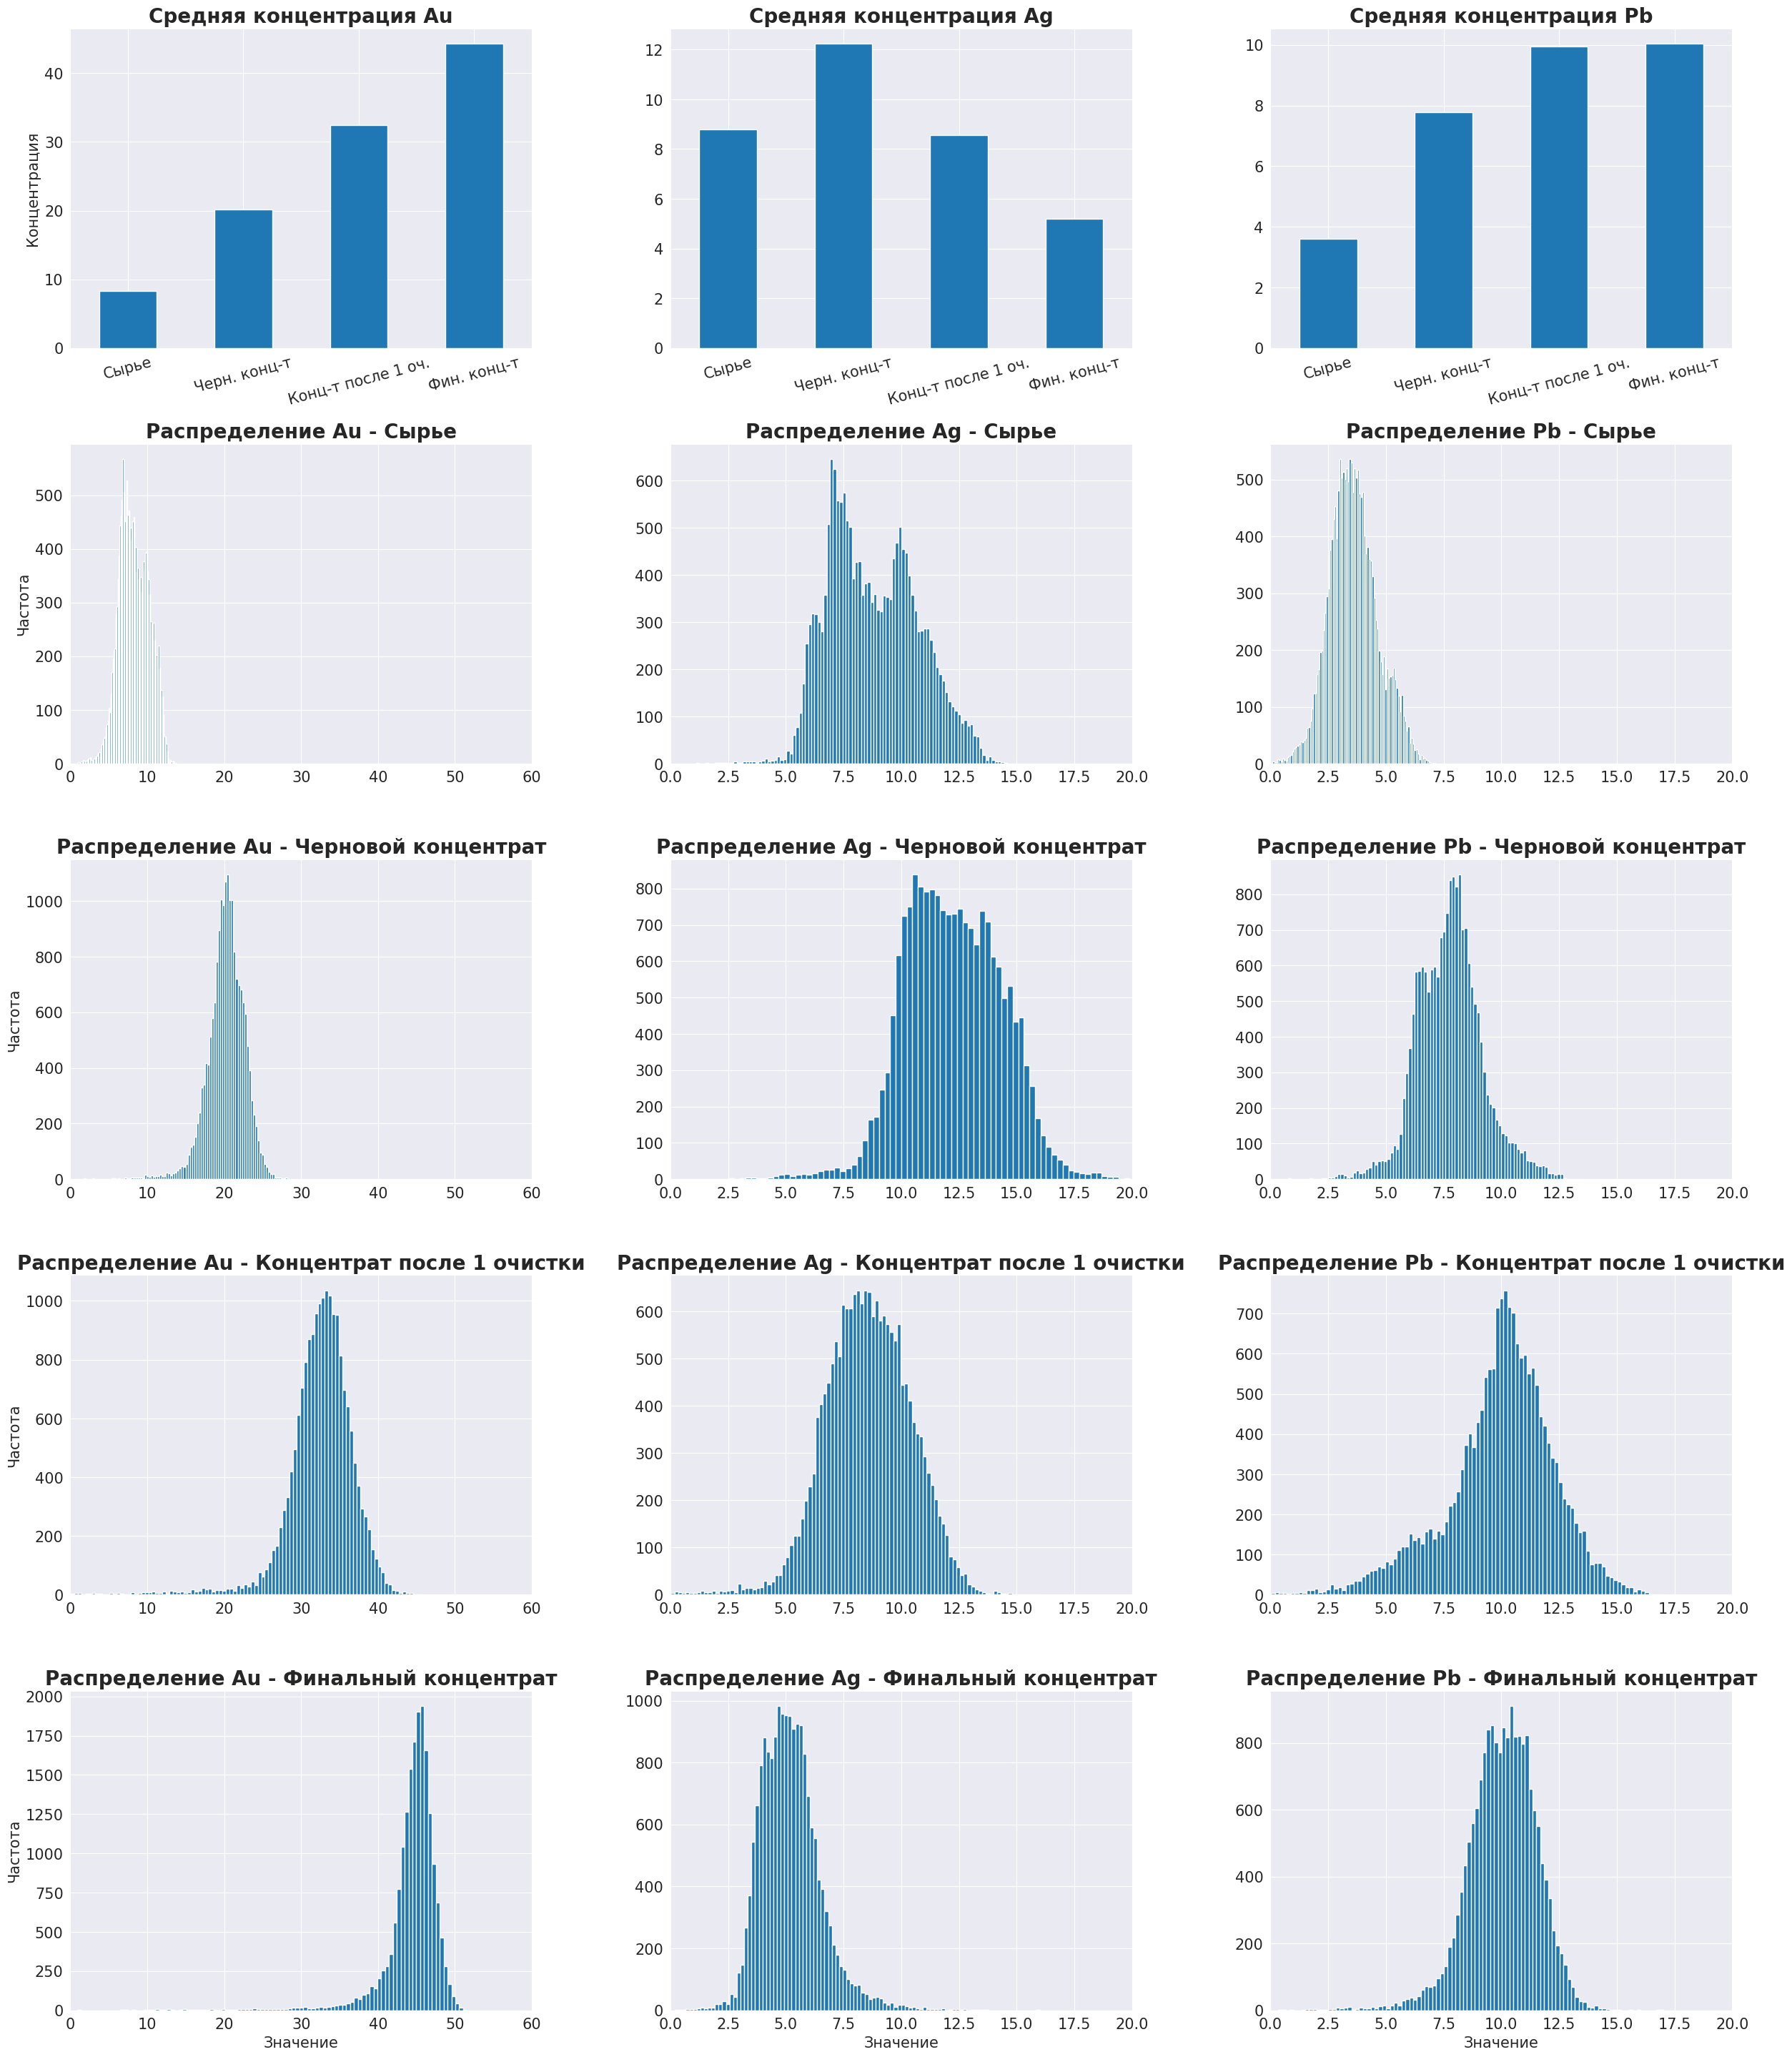

In [19]:
# Сделаем визуализацию
fig, ax = plt.subplots(5, 3, figsize=(30, 36))

# Подпишем оси
ax[0][0].set_ylabel('Концентрация', fontsize=15)
ax[1][0].set_ylabel('Частота', fontsize=15)
ax[2][0].set_ylabel('Частота', fontsize=15)
ax[3][0].set_ylabel('Частота', fontsize=15)
ax[4][0].set_ylabel('Частота', fontsize=15)
ax[4][0].set_xlabel('Значение', fontsize=15)
ax[4][1].set_xlabel('Значение', fontsize=15)
ax[4][2].set_xlabel('Значение', fontsize=15)

# Нарисуем верхние графики
data_for_au.mean().plot(kind='bar', ax=ax[0][0])
data_for_ag.mean().plot(kind='bar', ax=ax[0][1])
data_for_pb.mean().plot(kind='bar', ax=ax[0][2])

# Настроим тики
ax[0][0].tick_params(axis='x', rotation=15)
ax[0][0].tick_params(axis='both', labelsize=15)
ax[0][1].tick_params(axis='x', rotation=15)
ax[0][1].tick_params(axis='both', labelsize=15)
ax[0][2].tick_params(axis='x', rotation=15)
ax[0][2].tick_params(axis='both', labelsize=15)
ax[1][0].tick_params(axis='both', labelsize=15)
ax[1][1].tick_params(axis='both', labelsize=15)
ax[1][2].tick_params(axis='both', labelsize=15)
ax[2][0].tick_params(axis='both', labelsize=15)
ax[2][1].tick_params(axis='both', labelsize=15)
ax[2][2].tick_params(axis='both', labelsize=15)
ax[3][0].tick_params(axis='both', labelsize=15)
ax[3][1].tick_params(axis='both', labelsize=15)
ax[3][2].tick_params(axis='both', labelsize=15)
ax[4][0].tick_params(axis='both', labelsize=15)
ax[4][1].tick_params(axis='both', labelsize=15)
ax[4][2].tick_params(axis='both', labelsize=15)

# Построим гистограммы
data_for_au.hist(column='Сырье', ax=ax[1][0], bins=100)
data_for_ag.hist(column='Сырье', ax=ax[1][1], bins=100)
data_for_pb.hist(column='Сырье', ax=ax[1][2], bins=100)
data_for_au.hist(column='Черн. конц-т', ax=ax[2][0], bins=100)
data_for_ag.hist(column='Черн. конц-т', ax=ax[2][1], bins=100)
data_for_pb.hist(column='Черн. конц-т', ax=ax[2][2], bins=100)
data_for_au.hist(column='Конц-т после 1 оч.', ax=ax[3][0], bins=100)
data_for_ag.hist(column='Конц-т после 1 оч.', ax=ax[3][1], bins=100)
data_for_pb.hist(column='Конц-т после 1 оч.', ax=ax[3][2], bins=100)
data_for_au.hist(column='Фин. конц-т', ax=ax[4][0], bins=100)
data_for_ag.hist(column='Фин. конц-т', ax=ax[4][1], bins=100)
data_for_pb.hist(column='Фин. конц-т', ax=ax[4][2], bins=100)

# Пропишем тайтлы
ax[0][0].set_title('Средняя концентрация Au', fontsize=20, weight='bold')
ax[0][1].set_title('Средняя концентрация Ag', fontsize=20, weight='bold')
ax[0][2].set_title('Средняя концентрация Pb', fontsize=20, weight='bold')
ax[1][0].set_title('Распределение Au - Сырье', fontsize=20, weight='bold')
ax[1][1].set_title('Распределение Ag - Сырье', fontsize=20, weight='bold')
ax[1][2].set_title('Распределение Pb - Сырье', fontsize=20, weight='bold')
ax[2][0].set_title('Распределение Au - Черновой концентрат', fontsize=20, weight='bold')
ax[2][1].set_title('Распределение Ag - Черновой концентрат', fontsize=20, weight='bold')
ax[2][2].set_title('Распределение Pb - Черновой концентрат', fontsize=20, weight='bold')
ax[3][0].set_title('Распределение Au - Концентрат после 1 очистки', fontsize=20, weight='bold')
ax[3][1].set_title('Распределение Ag - Концентрат после 1 очистки', fontsize=20, weight='bold')
ax[3][2].set_title('Распределение Pb - Концентрат после 1 очистки', fontsize=20, weight='bold')
ax[4][0].set_title('Распределение Au - Финальный концентрат', fontsize=20, weight='bold')
ax[4][1].set_title('Распределение Ag - Финальный концентрат', fontsize=20, weight='bold')
ax[4][2].set_title('Распределение Pb - Финальный концентрат', fontsize=20, weight='bold')

# Установим единый масштаб для гистограмм
ax[1][0].set_xlim(0,60)
ax[2][0].set_xlim(0,60)
ax[3][0].set_xlim(0,60)
ax[4][0].set_xlim(0,60)
ax[1][1].set_xlim(0,20)
ax[2][1].set_xlim(0,20)
ax[3][1].set_xlim(0,20)
ax[4][1].set_xlim(0,20)
ax[1][2].set_xlim(0,20)
ax[2][2].set_xlim(0,20)
ax[3][2].set_xlim(0,20)
ax[4][2].set_xlim(0,20)

# Отобразим график
plt.show();

### Размеры гранул в train и test выборках

'Размер гранул в train:'

train   test
min    0.05   0.05
mean  58.92  59.11
50%   54.36  55.51
max  484.97 363.99
std   22.41  19.13

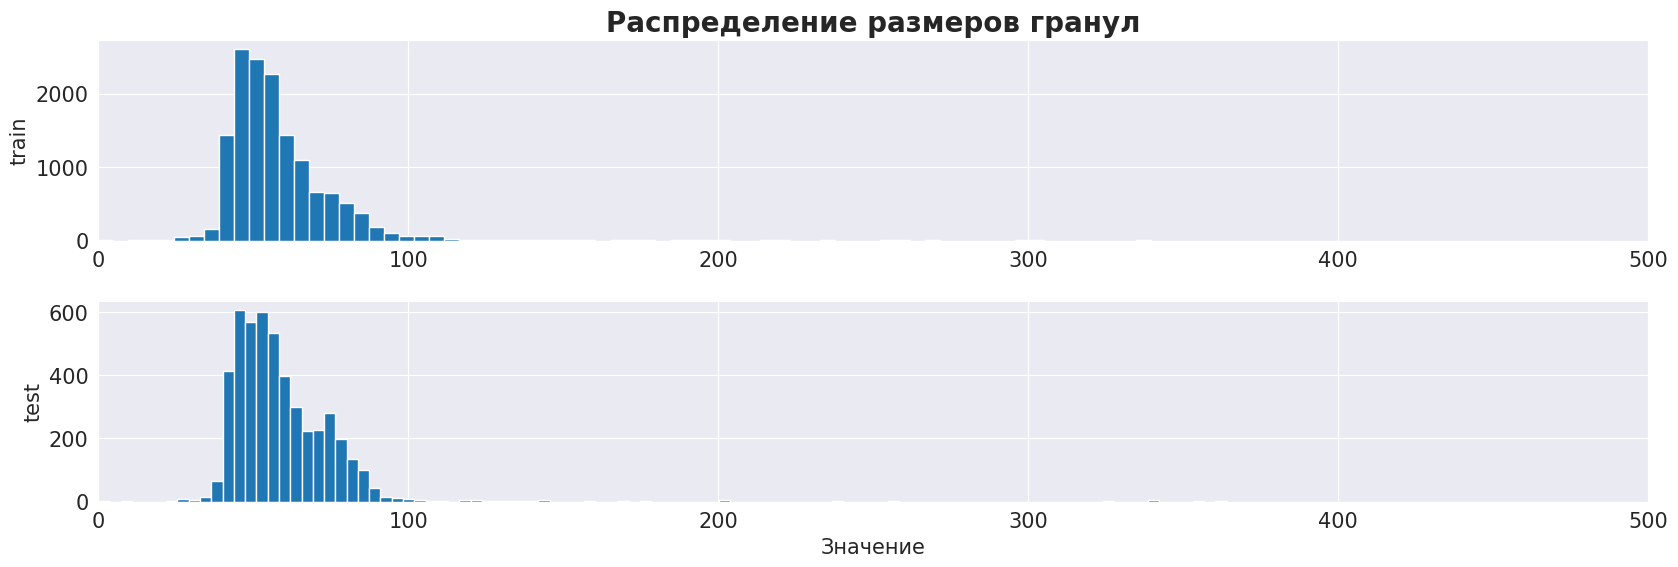

In [20]:
# Посмотрим на размеры гранул сырья в train и test выборках и визуализируем распределения
# Сначала выведем статистику таблично
index = ['min', 'mean', '50%', 'max', 'std']
describe_result = pd.concat([df_train['r_i_feed_size'].describe().loc[index],
                             df_test['r_i_feed_size'].describe().loc[index]],
                            axis='columns')
describe_result.columns = ['train', 'test']
display('Размер гранул в train:', describe_result)

# Нарисуем распределения и сравним визуально
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
df_train.hist(column=['r_i_feed_size'], bins=100, ax=ax1)
df_test.hist(column=['r_i_feed_size'], bins=100, ax=ax2)
ax1.set_title('Распределение размеров гранул', fontsize=20, weight='bold')
ax2.set_title('')
ax1.set_ylabel('train', fontsize=15)
ax2.set_ylabel('test', fontsize=15)
ax2.set_xlabel('Значение', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax1.set_xlim(0,500)
ax2.set_xlim(0,500);

### Суммарная концентрация металлов на различных этапах

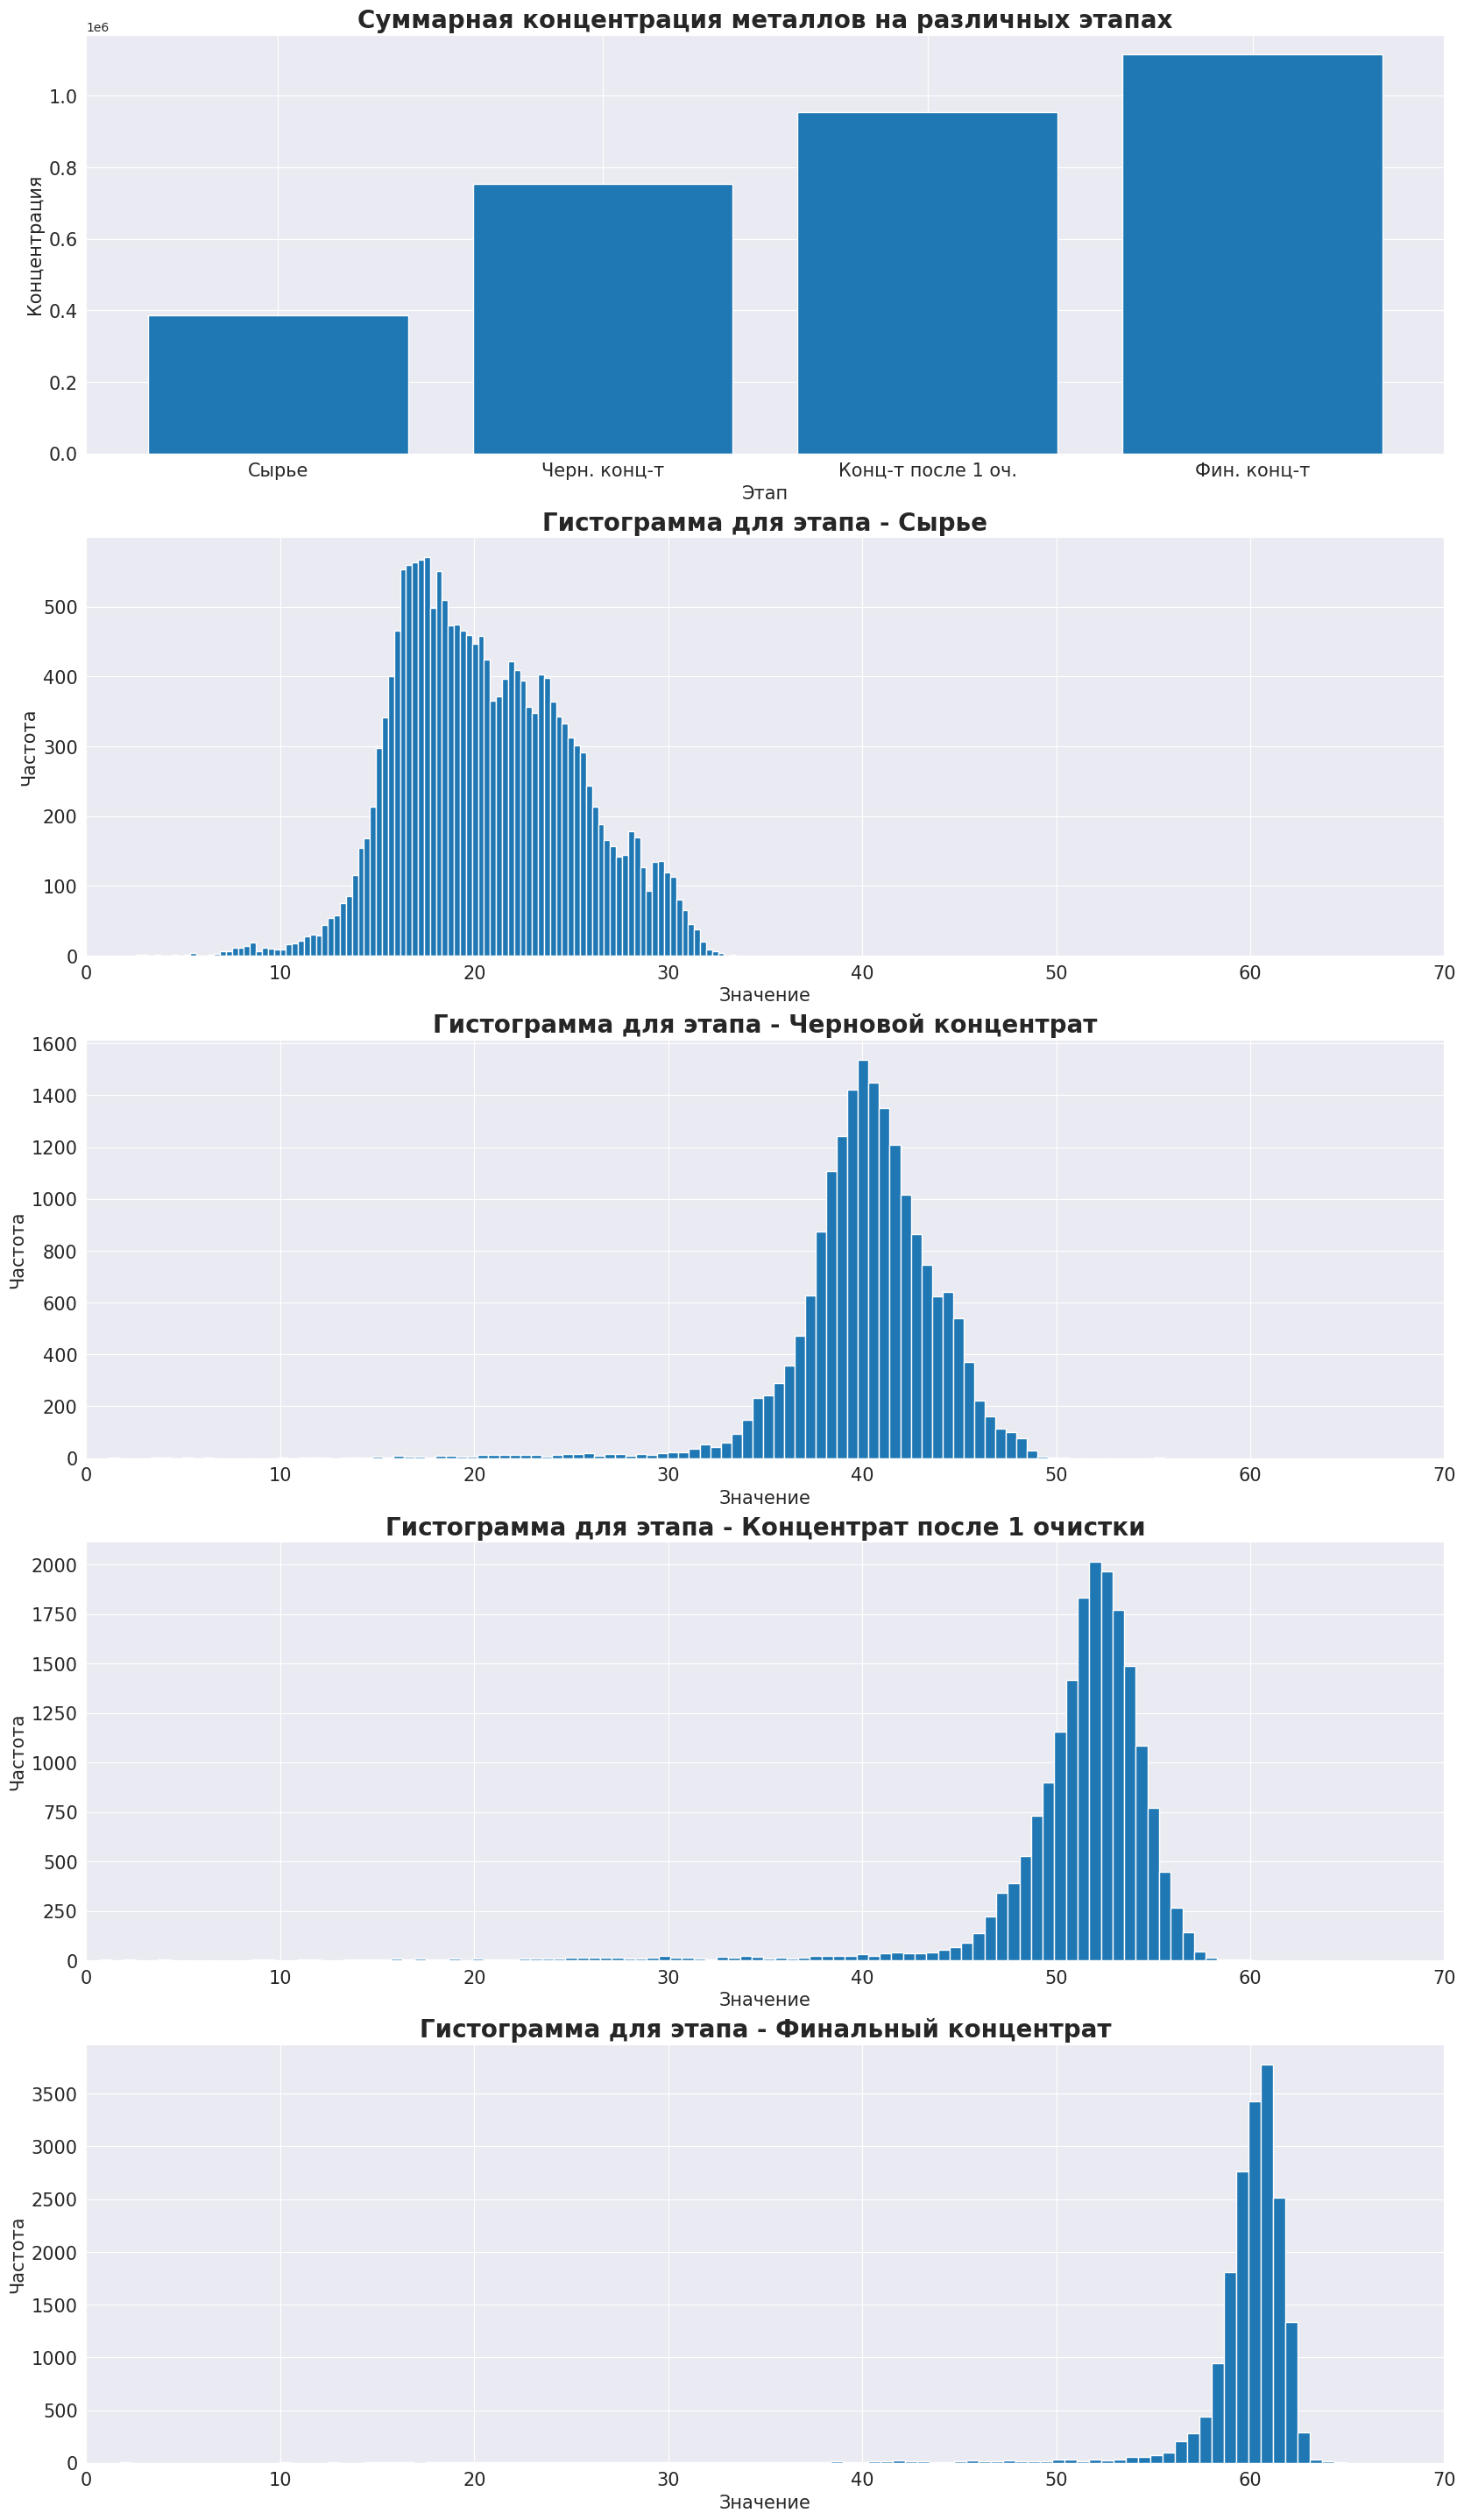

In [21]:
# Посмотрим на суммарную концентрацию металлов на каждом этапе. Т.к. это величины на единицу объема/массы - их можно суммировать
# Сырье
r_i_feed_all = df_full[['r_i_feed_au', 'r_i_feed_ag', 'r_i_feed_pb']]\
    .sum(axis='columns')

# Черн. конц-т
r_o_concentrate_all = df_full[['r_o_concentrate_au', 'r_o_concentrate_ag', 'r_o_concentrate_pb']]\
    .sum(axis='columns')

# Конц-т после 1 оч.
pc_o_concentrate_all = df_full[['pc_o_concentrate_au', 'pc_o_concentrate_ag', 'pc_o_concentrate_pb']]\
    .sum(axis='columns')

# Фин. конц-т
f_o_concentrate_all = df_full[['f_o_concentrate_au', 'f_o_concentrate_ag', 'f_o_concentrate_pb']]\
    .sum(axis='columns')

# # Удалим индексы с околонулевым содержанием металлов
r_i_feed_all.drop(index=indexes_with_no_metal, inplace=True)
r_o_concentrate_all.drop(index=indexes_with_no_metal, inplace=True)
pc_o_concentrate_all.drop(index=indexes_with_no_metal, inplace=True)
f_o_concentrate_all.drop(index=indexes_with_no_metal, inplace=True)

# Рисуем график
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(20, 36))

# Подписываем оси
ax1.set_xlabel('Этап', fontsize=15)
ax2.set_xlabel('Значение', fontsize=15)
ax3.set_xlabel('Значение', fontsize=15)
ax4.set_xlabel('Значение', fontsize=15)
ax5.set_xlabel('Значение', fontsize=15)
ax1.set_ylabel('Концентрация', fontsize=15)
ax2.set_ylabel('Частота', fontsize=15)
ax3.set_ylabel('Частота', fontsize=15)
ax4.set_ylabel('Частота', fontsize=15)
ax5.set_ylabel('Частота', fontsize=15)

# Добавляем тайтлы
ax1.set_title('Суммарная концентрация металлов на различных этапах', fontsize=20, weight='bold')
ax2.set_title('Гистограмма для этапа - Сырье', fontsize=20, weight='bold')
ax3.set_title('Гистограмма для этапа - Черновой концентрат', fontsize=20, weight='bold')
ax4.set_title('Гистограмма для этапа - Концентрат после 1 очистки', fontsize=20, weight='bold')
ax5.set_title('Гистограмма для этапа - Финальный концентрат', fontsize=20, weight='bold')


# Настраиваем тики
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax4.tick_params(axis='both', labelsize=15)
ax5.tick_params(axis='both', labelsize=15)

# Приводим к одному диапазону шкалы гистограмм
ax2.set_xlim(0,70)
ax3.set_xlim(0,70)
ax4.set_xlim(0,70)
ax5.set_xlim(0,70)

# Строим графики
ax1.bar(['Сырье', 'Черн. конц-т', 'Конц-т после 1 оч.', 'Фин. конц-т'],
        [r_i_feed_all.sum(), r_o_concentrate_all.sum(), pc_o_concentrate_all.sum(), f_o_concentrate_all.sum()])
ax2.hist(r_i_feed_all, bins=100)
ax3.hist(r_o_concentrate_all, bins=100)
ax4.hist(pc_o_concentrate_all, bins=100)
ax5.hist(f_o_concentrate_all, bins=100)

# Отображаем графики
plt.show();

### Выводы

* Визуальный анализ концентрации металлов Au, Ag и Pb на входах и выходах каждого этапа показывает, что:
    * Целевая концентрация Au, как и концентрация Pb растёт от этапа к этапу.
    * Концентрация Ag растёт на этапе флоатации, а затем снижается.
    * Абсолютный разброс по концентрации Au и Pb относительно стабилен на всех этапах.
    * Абсолютный разброс по концентрации Pb немного снижается от этапа к этапу.
    * Часть данных указывает на нулевую конентрацию металлов после флоатации, однако к финальным этапам эта доля значительно снижается. Вероятно это связано со спецификой этапа флотации (нестабильность), в результате чего на выходе из этапа получается пустышка, часть которой затем частично удаляется в хвосты каждого из этапов.
* Распределения размеров гранул в тренировочной и тестовой выборках различаются незначительно. Можно использовать эти выборки для обучения и тестирования.
* Суммарная концентрация металлов от этапа к этапам растёт, даже с учетом нестабильности первого этапа обработки.
* Разброс по суммарной конценртации металоов значительно сужается от этапа к этапу.

## Создание и обучение модели

### Предобработка данных

In [22]:
# Создадим рабочую копию датафрейма
df = df_full.copy()

In [23]:
# Удалим их из нетестовой части выборки дубликаты по финальной стадии
display(df.shape)
for index in df[df.duplicated(subset=list(df.columns)[77:])].index:
    if index not in df_test.index:
        df_full.drop(index=index, inplace=True)
display(df.shape)

(19439, 86)

(19439, 86)

In [24]:
# Создадим рабочую копию датафрейма оставим в ней только фичи из теста + таргеты для rougher и final
columns_for_model = list(df_test.columns) + ['r_o_recovery', 'f_o_recovery']
df = df[columns_for_model].sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   r_i_feed_au               19439 non-null  float64
 1   r_i_feed_ag               19439 non-null  float64
 2   r_i_feed_pb               19339 non-null  float64
 3   r_i_feed_sol              19340 non-null  float64
 4   r_i_feed_rate             19428 non-null  float64
 5   r_i_feed_size             19294 non-null  float64
 6   r_i_floatbank10_sulfate   19405 non-null  float64
 7   r_i_floatbank10_xanthate  19431 non-null  float64
 8   r_s_floatbank10_a_air     19438 non-null  float64
 9   r_s_floatbank10_a_level   19438 non-null  float64
 10  r_s_floatbank10_b_air     19438 non-null  float64
 11  r_s_floatbank10_b_level   19438 non-null  float64
 12  r_s_floatbank10_c_air     19438 non-null  float64
 13  r_s_floatbank10_c_level   19438 no

In [25]:
# Сразу выделим фичасет и таргеты (с учётом возможной утечки целевого признака для rougher)
X_rougher = df.iloc[:, 0:22]
y_rougher = df['r_o_recovery']
X_final = df.iloc[:, 0:52]
y_final = df['f_o_recovery']

In [26]:
# Выделим train, test выборки (75% и 25%)
X_rougher_train = X_rougher.loc[df_train.index]
y_rougher_train = y_rougher.loc[df_train.index]
X_rougher_test = X_rougher.loc[df_test.index]
y_rougher_test = y_rougher.loc[df_test.index]
X_final_train = X_final.loc[df_train.index]
y_final_train = y_final.loc[df_train.index]
X_final_test = X_final.loc[df_test.index]
y_final_test = y_final.loc[df_test.index]

### Расчёт метрики качества sMAPE

In [27]:
# Напишем функцию для расчёта финальной метрики sMAPE
def smape_calculator(fact: pd.Series, prediction: list):
    prediction = pd.Series(prediction, index=fact.index)
    n = fact.shape[0]
    correction = 10**-10 # на случай нулевого значения в знаменателе сделаем поправку
    return (1 / n) * 100 * 2 * (((fact - prediction).abs() + correction) /
                                (fact.abs() + prediction.abs() + correction)).sum()

# Итоговая sMAPE для двух моделей
def overall_smape_calculator(rougher, final):
    return (1 / 4) * rougher + (3 / 4) * final

### Обучение моделей и подбор лучших параметров

In [28]:
# Создадим словарь с дефолтными ограничениями
range_allowed = {}
for column in X_final_train.columns:
    range_allowed[column] = (-float('inf'), float('inf'))

# Создадим функцию для автоматической обработки выбросов
def remove_outliers(df: pd.DataFrame, range_allowed=range_allowed):
    df_transformed = df.copy()
    for column in df:
        min, max = range_allowed.get(column, (-float('inf'), float('inf')))
        if min != -float('inf') and max != float('inf'):
            df_transformed[column] = df[column].apply(lambda x: x if min < x < max else float('nan'))
    return df_transformed

# Добавим дополнительные ограничения на основе результатов визуального осмотра
range_allowed['pc_i_feed_size'] = (2, 12)

# Тест
display('Начальное количество пропусков:', X_final_train.isna().sum().sum())
display('Количество пропусков после обработки функцией:',
        remove_outliers(X_final_train, range_allowed).isna().sum().sum())

'Начальное количество пропусков:'

1420

'Количество пропусков после обработки функцией:'

1429

In [29]:
# Создадим функцию для автоматической обработки пропусков
def transform_na(X: pd.DataFrame):
    X_transformed = X.copy()
    # Сортируем по индексу/времени
    X_transformed.sort_index(inplace=True)
    # Заполняем пропуски интерполяцией
    X_transformed.interpolate(method='linear', axis='index', inplace=True)
    # На случай неудачной интерполяции заполняем остатки медианой
    X_transformed.fillna(X_transformed.median(), inplace=True)
    # Перемешиваем и возвращаем
    return X_transformed.sample(frac=1, random_state=777)

# Тест
display('Начальное количество пропусков:', X_final_train.isna().sum().sum())
display('Количество пропусков после обработки функцией:', transform_na(X_final_train).isna().sum().sum())

'Начальное количество пропусков:'

1420

'Количество пропусков после обработки функцией:'

0

In [30]:
%%time
# Начнем с rougher
results_rougher = [] # Для будущих результатов

# Рассмотрим 3 типа моделей и создадим для них param_grid
model_1 = LinearRegression()
model_2 = DecisionTreeRegressor()
model_3 = RandomForestRegressor()

param_distribution_1 = {}
param_distribution_2 = {'model__max_depth': randint(5, 20)
                        }
param_distribution_3 = {'model__max_depth': randint(5, 20),
                        'model__n_estimators': randint(1, 99)
                        }

# Объединим в лист для перебора
models_and_distrs = [('LR', model_1, param_distribution_1),
                     ('DTR', model_2, param_distribution_2),
                     ('RFR', model_3, param_distribution_3)
                     ]

for model_name, model, param_distribution in models_and_distrs:
    pipe = Pipeline([('remove_outliers',
                      FunctionTransformer(remove_outliers,
                                          kw_args={'range_allowed': range_allowed})),
                     ('transformer_na', FunctionTransformer(transform_na)),
                     ('scaler', StandardScaler()),
                     ('model', model)])

    kf = KFold(n_splits=4)
    scorer = make_scorer(smape_calculator, greater_is_better=False)
    cv = RandomizedSearchCV(estimator=pipe,
                            cv=kf,
                            scoring=scorer,
                            param_distributions=param_distribution,
                            n_jobs=-1,
                            n_iter=10,
                            verbose=3)

    cv.fit(X_rougher_train, y_rougher_train)
    display(f'Лучший результат для {model_name}: {cv.best_params_}, {-cv.best_score_/100:.2%}')
    results_rougher.append((model_name, cv.best_estimator_, cv.best_params_, -cv.best_score_))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/home/pest/miniconda3/envs/Practicum/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


'Лучший результат для LR: {}, 13.46%'

Fitting 4 folds for each of 10 candidates, totalling 40 fits


"Лучший результат для DTR: {'model__max_depth': 6}, 18.62%"

Fitting 4 folds for each of 10 candidates, totalling 40 fits


"Лучший результат для RFR: {'model__max_depth': 5, 'model__n_estimators': 92}, 14.30%"

CPU times: user 9.45 s, sys: 368 ms, total: 9.81 s
Wall time: 1min 17s


In [31]:
%%time
# То же самое с final
results_final = [] # Для будущих результатов

# Рассмотрим 3 типа моделей и создадим для них param_grid
model_1 = LinearRegression()
model_2 = DecisionTreeRegressor()
model_3 = RandomForestRegressor()

param_distribution_1 = {}
param_distribution_2 = {'model__max_depth': randint(5, 20)
                        }
param_distribution_3 = {'model__max_depth': randint(5, 20),
                        'model__n_estimators': randint(1, 99)
                        }

# Объединим в лист для перебора
models_and_distrs = [('LR', model_1, param_distribution_1),
                     ('DTR', model_2, param_distribution_2),
                     ('RFR', model_3, param_distribution_3)
                     ]

for model_name, model, param_distribution in models_and_distrs:
    pipe = Pipeline([('remove_outliers',
                      FunctionTransformer(remove_outliers,
                                          kw_args={'range_allowed': range_allowed})),
                     ('transformer_na', FunctionTransformer(transform_na)),
                     ('scaler', StandardScaler()),
                     ('model', model)])

    kf = KFold(n_splits=4)
    scorer = make_scorer(smape_calculator, greater_is_better=False)
    cv = RandomizedSearchCV(estimator=pipe,
                            cv=kf,
                            scoring=scorer,
                            param_distributions=param_distribution,
                            n_jobs=-1,
                            n_iter=10,
                            verbose=3)

    cv.fit(X_final_train, y_final_train)
    display(f'Лучший результат для {model_name}: {cv.best_params_}, {-cv.best_score_/100:.2%}')
    results_final.append((model_name, cv.best_estimator_, cv.best_params_, -cv.best_score_))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/home/pest/miniconda3/envs/Practicum/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


'Лучший результат для LR: {}, 11.68%'

Fitting 4 folds for each of 10 candidates, totalling 40 fits


"Лучший результат для DTR: {'model__max_depth': 5}, 11.88%"

Fitting 4 folds for each of 10 candidates, totalling 40 fits


"Лучший результат для RFR: {'model__max_depth': 8, 'model__n_estimators': 71}, 12.08%"

CPU times: user 24.1 s, sys: 396 ms, total: 24.5 s
Wall time: 2min 29s


### Выбор лучшей модели

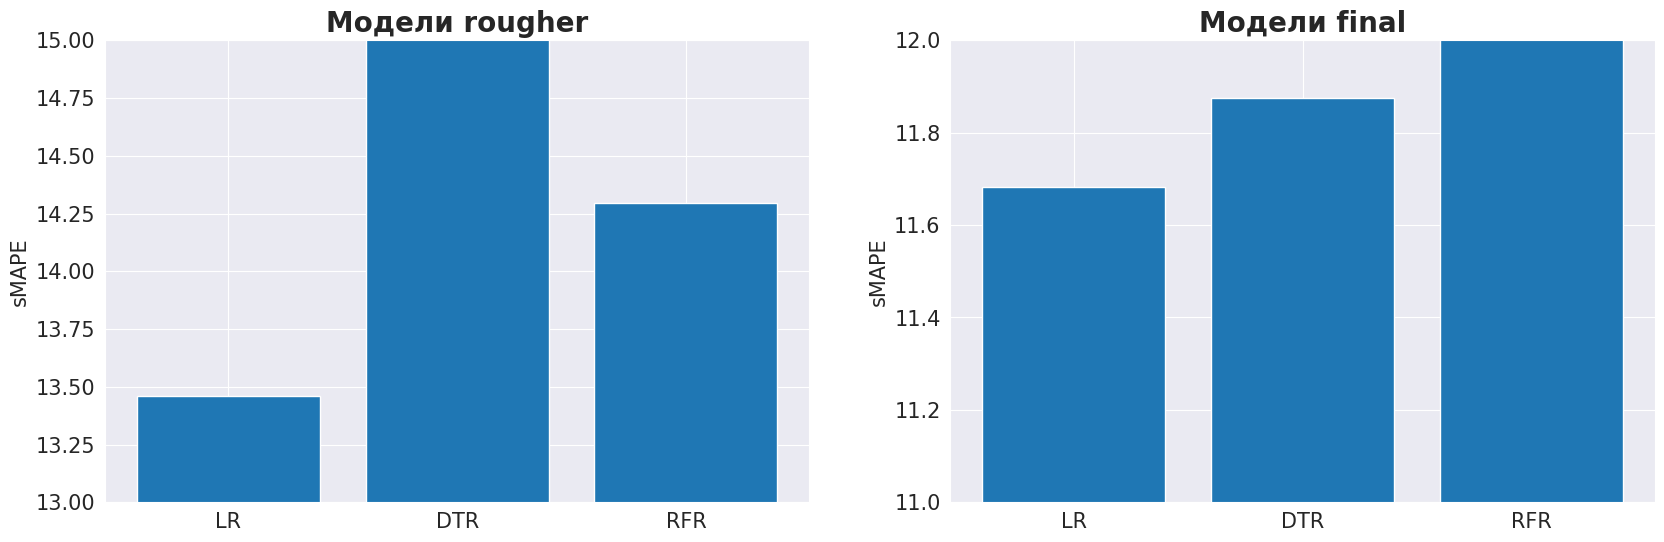

In [32]:
# Визуализируем итоговые результаты по моделям
data_for_graph_rougher = {}
data_for_graph_final = {}

for result in results_rougher:
    data_for_graph_rougher[str(result[0])] = result[3]

for result in results_final:
    data_for_graph_final[str(result[0])] = result[3]

data_for_graph_rougher = pd.Series(data_for_graph_rougher)
data_for_graph_final = pd.Series(data_for_graph_final)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.set_title('Модели rougher', fontsize=20, weight='bold')
ax2.set_title('Модели final', fontsize=20, weight='bold')
ax1.set_ylabel('sMAPE', fontsize=15)
ax2.set_ylabel('sMAPE', fontsize=15)
ax1.set_ylim(13, 15)
ax2.set_ylim(11, 12)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax1.bar(data_for_graph_rougher.index, data_for_graph_rougher.values)
ax2.bar(data_for_graph_final.index, data_for_graph_final.values)
plt.show();

In [33]:
# Выбор лучшей модели
best_model_name_rougher = None
best_model_name_final = None
best_model_rougher = None
best_model_final = None
best_params_rougher = None
best_params_final = None
best_result_rougher = float('inf')
best_result_final = float('inf')

for result in results_rougher:
    if result[3] < best_result_rougher:
        best_model_name_rougher = result[0]
        best_model_rougher = result[1]
        best_params_rougher = result[2]
        best_result_rougher = result[3]

for result in results_final:
    if result[3] < best_result_final:
        best_model_name_final = result[0]
        best_model_final = result[1]
        best_params_final = result[2]
        best_result_final = result[3]

display(f'Лучшая модель для этапа rougher: {best_model_name_rougher}, {best_params_rougher}')
display(f'sMAPE лучшей модели для этапа rougher: {best_result_rougher/100:0.2%}')
display(f'Лучшая модель для этапа final: {best_model_name_final}, {best_params_final}')
display(f'sMAPE лучшей модели для этапа final: {best_result_final/100:0.2%}')

'Лучшая модель для этапа rougher: LR, {}'

'sMAPE лучшей модели для этапа rougher: 13.46%'

'Лучшая модель для этапа final: LR, {}'

'sMAPE лучшей модели для этапа final: 11.68%'

### Итоговое тестирование

In [34]:
# Cнова обучим модели на всей тренировочной выборке и посчитаем смапе для rougher и final
pipe_rougher = best_model_rougher
pipe_rougher.fit(X_rougher_train, y_rougher_train)
y_rougher_predicted = pipe_rougher.predict(X_rougher_test)
smape_rougher = smape_calculator(y_rougher_test, y_rougher_predicted)

pipe_final = best_model_final
pipe_final.fit(X_final_train, y_final_train)
y_final_predicted = pipe_final.predict(X_final_test)
smape_final = smape_calculator(y_final_test, y_final_predicted)

# Посмотрим на финальный результат
overall_smape = overall_smape_calculator(smape_rougher, smape_final)

display(f'Итоговый smape: {overall_smape/100:.2%}')

'Итоговый smape: 8.86%'

### Выводы

* Проведена предобработка данных:
    * Изначальные данные разбиты на тренировочную и тестовую выборки согласно оригинальной разбивке.
    * Создана функция для автоматического поиска выбросов и замены их на NA.
    * Создана функция для автоматической обработки пропусков методом линейной интерполяции, а там, где это невозможно - заполнением медианным значением.
    * Для прогнозирования на этапе rougher выбраны только те параметры, которые предшествуют этому этапу, чтобы избежать утечки целевого признака.
* Созданы функции для расчёта промежуточных и итоговой sMAPE. Для устранения возможного деления на ноль введена поправка.
* Протестированы 3 вида моделей для предсказания recovery на 2 этапах: `LR`, `DTR` и `RFR`. В широком диапазоне проведен подбор гиперпараметров для DTR и RFR. Кроссвалидация показала, что особых преимуществ по выбранной метрике модели деревьев не дают ни в одном из двух прогнозов.
* **Итоговой лучшей модели для предсказания recovery на этапах rougher и final выбрана `LinearRegression`.**
* Проведено финальное тестирование на тестовой выборке с результатом по итоговой sMAPE в размере 8.86%.

## Общие выводы по проекту

* Проведена загрузка и первоначальный осмотр данных. Около 20 000 семплов, 86 непрерывных показателей, незначительная доля пропусков, наличие выбросов по некоторым столбцам. В целевых столбцах пропусков нет.
* Визуальный осмотр первоначальных данных показывает различный характер распределения показателей, а так же наличие по некоторым из них пиков в районе нулевого значения. Скорее всего это связано с природой проводимых над сырьем манипуляций.
* Проверен расчёт эффективности обогащения. Ошибок не выявлено.
* Проведен исследовательский анализ данных в части концентрации металлов на различных этапах обработки, а так же в части распределения размеров гранул:
    * Концентрация Au, как и суммарная концентрация металлов растёт на каждом этапе.
    * После этапа флотации в части данных появляется нулевая концентрация металлов. Вероятнее всего это связано с нестабильностью процесса флотации.
* Проведена предобработка данных, в т.ч. автоматическое заполнение пропусков методом интерполяции.
* Для прогнозирования результатов rougher и final на тестовой выборке обучены модели LR, DTR и RFR в широком диапазоне гиперпараметров. **Для обоих прогнозов лучше всего показала себя модель LinearRegression**.
* Финальное тестирование на отдельной выборке показало итоговый результат с выбранными моделями sMAPE: 8.85%.